In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 21.3MB/s 
     |████████████████████████████████| 163kB 53.1MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 81kB 13.3MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 143kB 50.0MB/s 
     |████████████████████████████████| 112kB 44.2MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=bda10ceb5e5dfe2781eff4fad5241ae41c40cd59ea8253ff1f3eea0a178ac868
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
from glob import glob
from keras import optimizers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os

In [ ]:
path = glob("kaibara/*/")
data = []
label = []
total = 0
x = 32
y = 18

def append_data(directory, total):
  files = os.listdir(directory)
  print(files)
  for image in files:
    if image.endswith(".jpg"):
      image = cv2.imread(directory + image)
      image = cv2.resize(image, (x, y))
      image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image_gs = image_gs.flatten()
      data.append(image_gs)
      label.append(total)

for i in path:
    append_data(i, total)
    total += 1

['yamaoka_171.jpg', 'tomii_159.jpg', 'kurita_164.jpg', 'yamaoka_172.jpg', 'kurita_165.jpg', 'yamaoka_173.jpg', 'tomii_160.jpg', 'tomii_161.jpg', 'tomii_162.jpg', 'yamaoka_174.jpg', 'tomii_163.jpg', 'tomii_164.jpg', 'tomii_165.jpg', 'yamaoka_175.jpg', 'kurita_166.jpg', 'yamaoka_176.jpg', 'ohhara_193.jpg', 'ohhara_194.jpg', 'ohhara_195.jpg', 'ohhara_196.jpg', 'ohhara_198.jpg', 'ohhara_199.jpg', 'ohhara_001.jpg', 'ohhara_002.jpg', 'ohhara_003.jpg', 'ohhara_004.jpg', 'ohhara_005.jpg', 'ohhara_006.jpg', 'tanimura_053.jpg', 'ohhara_007.jpg', 'ohhara_008.jpg', 'yamaoka_177.jpg', 'kurita_167.jpg', 'tomii_166.jpg', 'tomii_167.jpg', 'tomii_168.jpg', 'tomii_169.jpg', 'tomii_170.jpg', 'tanimura_054.jpg', 'tanimura_056.jpg', 'ohhara_013.jpg', 'tomii_171.jpg', 'ohhara_014.jpg', 'ohhara_015.jpg', 'tanimura_057.jpg', 'tanimura_058.jpg', 'tanimura_059.jpg', 'tomii_172.jpg', 'tomii_173.jpg', 'ohhara_016.jpg', 'tomii_174.jpg', 'tomii_175.jpg', 'tomii_176.jpg', 'tomii_177.jpg', 'tomii_178.jpg', 'tomii_179

In [ ]:
data = np.array(data, dtype=np.float64)
label = np.array(label, dtype=np.float64)

train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=1, stratify=label, test_size=0.1)

train_data = train_data.reshape((len(train_data)), x, y, 1)
test_data = test_data.reshape((len(test_data)), x, y, 1)

train_data /= 255
test_data /= 255

train_label = to_categorical(train_label, num_classes=2)
test_label = to_categorical(test_label, num_classes=2)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(1152, 32, 18, 1)
(1152, 2)
(129, 32, 18, 1)
(129, 2)


In [ ]:
model_list = []
result_list = []

def create_model(layer, filter_size, filters, activation, dropout_rate):
  model = model = models.Sequential()
  model.add(layers.Conv2D(16, (filter_size, filter_size), activation="relu", padding="same", input_shape=(x, y, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
  model.add(layers.Flatten())
  for i in range(layer):
    model.add(layers.Dense(filters, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=dropout_rate))
  model.add(layers.Dense(2, activation="softmax"))
  return model

def optimisation(choice):
  K.clear_session()
  layer = choice.suggest_int("layer", 1, 8)
  filter_size = choice.suggest_int("filter_size", 3, 7, 2)
  filters = choice.suggest_int("filters", 32, 256, 32)
  optimizer = choice.suggest_categorical("optimizer", ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"])
  activation = choice.suggest_categorical("activation", ["softmax", "elu", "selu", "softplus", "softsign", "relu", "tanh", "sigmoid", "hard_sigmoid", "linear"])
  dropout_rate = choice.suggest_uniform("dropout_rate", 0.25, 0.5)
  model = create_model(layer, filter_size, filters, activation, dropout_rate)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  result = model.fit(train_data, train_label, batch_size=batchsize, epochs=epoch, verbose=2, validation_data=(test_data, test_label))
  model_list.append(model)
  result_list.append(result)
  return 1 - result.history["val_accuracy"][-1]

In [ ]:
batchsize = train_data.shape[0] // 64
print(batchsize)
epoch = 16
study = optuna.create_study()
study.optimize(optimisation, n_trials=256)

[I 2021-03-17 08:09:58,294] A new study created in memory with name: no-name-eca67424-e17e-481b-9347-9643e67f5188


18
Epoch 1/16
64/64 - 33s - loss: 0.7778 - accuracy: 0.6276 - val_loss: 0.5392 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5466 - accuracy: 0.7396 - val_loss: 0.6070 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.4148 - accuracy: 0.8116 - val_loss: 0.6713 - val_accuracy: 0.5581
Epoch 4/16
64/64 - 0s - loss: 0.3596 - accuracy: 0.8429 - val_loss: 0.4989 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.3090 - accuracy: 0.8750 - val_loss: 0.4915 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2682 - accuracy: 0.8993 - val_loss: 0.4659 - val_accuracy: 0.8062
Epoch 7/16
64/64 - 0s - loss: 0.2217 - accuracy: 0.9201 - val_loss: 0.3028 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2053 - accuracy: 0.9245 - val_loss: 0.2270 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1946 - accuracy: 0.9280 - val_loss: 0.2182 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1801 - accuracy: 0.9349 - val_loss: 0.1922 - val_accuracy: 0.9225
Epoch 11/16
64/

[I 2021-03-17 08:10:40,530] Trial 0 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.30416618652233074}. Best is trial 0 with value: 0.07751935720443726.


Epoch 1/16
64/64 - 3s - loss: 0.9462 - accuracy: 0.5920 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6246 - accuracy: 0.7170 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4596 - accuracy: 0.8108 - val_loss: 0.4045 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3977 - accuracy: 0.8394 - val_loss: 0.5803 - val_accuracy: 0.7907
Epoch 5/16
64/64 - 0s - loss: 0.3611 - accuracy: 0.8611 - val_loss: 0.4459 - val_accuracy: 0.9302
Epoch 6/16
64/64 - 1s - loss: 0.3246 - accuracy: 0.8793 - val_loss: 0.4590 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 1s - loss: 0.2573 - accuracy: 0.8898 - val_loss: 0.3876 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2505 - accuracy: 0.9062 - val_loss: 0.6186 - val_accuracy: 0.7209
Epoch 9/16
64/64 - 1s - loss: 0.2590 - accuracy: 0.9054 - val_loss: 0.2426 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 1s - loss: 0.2236 - accuracy: 0.9141 - val_loss: 0.1657 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:52,391] Trial 1 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.4873658290521653}. Best is trial 1 with value: 0.06976741552352905.


Epoch 1/16
64/64 - 2s - loss: 0.7360 - accuracy: 0.6615 - val_loss: 0.4719 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4218 - accuracy: 0.8056 - val_loss: 0.3867 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2875 - accuracy: 0.8741 - val_loss: 0.3613 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2404 - accuracy: 0.9019 - val_loss: 0.3220 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.1914 - accuracy: 0.9288 - val_loss: 0.3497 - val_accuracy: 0.9457
Epoch 6/16
64/64 - 0s - loss: 0.1556 - accuracy: 0.9418 - val_loss: 0.2733 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1559 - accuracy: 0.9410 - val_loss: 0.2104 - val_accuracy: 0.9535
Epoch 8/16
64/64 - 0s - loss: 0.1226 - accuracy: 0.9549 - val_loss: 0.2031 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1183 - accuracy: 0.9601 - val_loss: 0.2380 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0940 - accuracy: 0.9644 - val_loss: 0.2560 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 08:10:58,910] Trial 2 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 96, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.27814967851649236}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 2s - loss: 0.7012 - accuracy: 0.6606 - val_loss: 0.5823 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.4516 - accuracy: 0.8116 - val_loss: 0.3907 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3080 - accuracy: 0.8637 - val_loss: 0.3803 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2435 - accuracy: 0.9036 - val_loss: 0.3121 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.2348 - accuracy: 0.9036 - val_loss: 0.2862 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1848 - accuracy: 0.9297 - val_loss: 0.2152 - val_accuracy: 0.9457
Epoch 7/16
64/64 - 0s - loss: 0.1634 - accuracy: 0.9401 - val_loss: 0.2192 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1103 - accuracy: 0.9601 - val_loss: 0.1823 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1249 - accuracy: 0.9549 - val_loss: 0.2127 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1154 - accuracy: 0.9514 - val_loss: 0.1958 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:05,440] Trial 3 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.32573382540316276}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 2s - loss: 0.8061 - accuracy: 0.5512 - val_loss: 0.5097 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6415 - accuracy: 0.6753 - val_loss: 0.4919 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5440 - accuracy: 0.7465 - val_loss: 0.4460 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5230 - accuracy: 0.7847 - val_loss: 0.4276 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4970 - accuracy: 0.7969 - val_loss: 0.4284 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4851 - accuracy: 0.8168 - val_loss: 0.4164 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4697 - accuracy: 0.8142 - val_loss: 0.4189 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4706 - accuracy: 0.8238 - val_loss: 0.4148 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4536 - accuracy: 0.8281 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4540 - accuracy: 0.8281 - val_loss: 0.4142 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:12,536] Trial 4 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adam', 'activation': 'tanh', 'dropout_rate': 0.2618920418234765}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 1.1134 - accuracy: 0.5148 - val_loss: 0.4798 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.1165 - accuracy: 0.5208 - val_loss: 0.5187 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.0236 - accuracy: 0.5312 - val_loss: 0.5785 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.0416 - accuracy: 0.5269 - val_loss: 0.6646 - val_accuracy: 0.7829
Epoch 5/16
64/64 - 0s - loss: 0.9312 - accuracy: 0.5686 - val_loss: 0.7685 - val_accuracy: 0.2248
Epoch 6/16
64/64 - 0s - loss: 0.9694 - accuracy: 0.5790 - val_loss: 0.8606 - val_accuracy: 0.1705
Epoch 7/16
64/64 - 0s - loss: 0.9444 - accuracy: 0.5503 - val_loss: 0.9266 - val_accuracy: 0.2248
Epoch 8/16
64/64 - 0s - loss: 0.9883 - accuracy: 0.5486 - val_loss: 0.9447 - val_accuracy: 0.2558
Epoch 9/16
64/64 - 0s - loss: 0.9622 - accuracy: 0.5755 - val_loss: 0.9113 - val_accuracy: 0.3256
Epoch 10/16
64/64 - 0s - loss: 0.9564 - accuracy: 0.5634 - val_loss: 0.8820 - val_accuracy: 0.4031
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:17,065] Trial 5 finished with value: 0.43410855531692505 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adadelta', 'activation': 'hard_sigmoid', 'dropout_rate': 0.293297866382756}. Best is trial 2 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.6237 - accuracy: 0.6580 - val_loss: 0.6391 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5392 - accuracy: 0.7500 - val_loss: 0.6162 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4668 - accuracy: 0.8177 - val_loss: 0.6009 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4167 - accuracy: 0.8689 - val_loss: 0.5914 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3942 - accuracy: 0.8828 - val_loss: 0.5832 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3584 - accuracy: 0.8932 - val_loss: 0.5673 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3289 - accuracy: 0.9149 - val_loss: 0.5294 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.3217 - accuracy: 0.9175 - val_loss: 0.4776 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2969 - accuracy: 0.9288 - val_loss: 0.4085 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2769 - accuracy: 0.9479 - val_loss: 0.3484 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:20,680] Trial 6 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.35236483877471747}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 1.2151 - accuracy: 0.5174 - val_loss: 0.7008 - val_accuracy: 0.5504
Epoch 2/16
64/64 - 0s - loss: 1.2952 - accuracy: 0.5026 - val_loss: 0.5783 - val_accuracy: 0.7752
Epoch 3/16
64/64 - 0s - loss: 1.2717 - accuracy: 0.4931 - val_loss: 0.6020 - val_accuracy: 0.7287
Epoch 4/16
64/64 - 0s - loss: 1.2247 - accuracy: 0.5043 - val_loss: 0.7396 - val_accuracy: 0.6589
Epoch 5/16
64/64 - 0s - loss: 1.3186 - accuracy: 0.5182 - val_loss: 0.8816 - val_accuracy: 0.5504
Epoch 6/16
64/64 - 0s - loss: 1.2877 - accuracy: 0.4878 - val_loss: 1.0721 - val_accuracy: 0.4651
Epoch 7/16
64/64 - 0s - loss: 1.2666 - accuracy: 0.5104 - val_loss: 1.2051 - val_accuracy: 0.4574
Epoch 8/16
64/64 - 0s - loss: 1.3076 - accuracy: 0.5061 - val_loss: 1.1750 - val_accuracy: 0.4961
Epoch 9/16
64/64 - 0s - loss: 1.2403 - accuracy: 0.5278 - val_loss: 1.1436 - val_accuracy: 0.5271
Epoch 10/16
64/64 - 0s - loss: 1.2447 - accuracy: 0.5182 - val_loss: 1.1089 - val_accuracy: 0.5581
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:28,278] Trial 7 finished with value: 0.41860467195510864 and parameters: {'layer': 7, 'filter_size': 7, 'filters': 64, 'optimizer': 'Adadelta', 'activation': 'tanh', 'dropout_rate': 0.33730135905954983}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8656 - accuracy: 0.5842 - val_loss: 0.6656 - val_accuracy: 0.6667
Epoch 2/16
64/64 - 0s - loss: 0.6603 - accuracy: 0.6962 - val_loss: 0.5272 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.5236 - accuracy: 0.7344 - val_loss: 0.4465 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.4627 - accuracy: 0.7977 - val_loss: 0.3899 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.4032 - accuracy: 0.8116 - val_loss: 0.3792 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3186 - accuracy: 0.8698 - val_loss: 0.3231 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3026 - accuracy: 0.8733 - val_loss: 0.2829 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.3005 - accuracy: 0.8819 - val_loss: 0.2484 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2667 - accuracy: 0.8898 - val_loss: 0.2165 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2494 - accuracy: 0.8967 - val_loss: 0.2175 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:33,302] Trial 8 finished with value: 0.10852712392807007 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.39298932717120416}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9586 - accuracy: 0.5998 - val_loss: 0.4811 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7377 - accuracy: 0.6641 - val_loss: 0.3612 - val_accuracy: 0.8837
Epoch 3/16
64/64 - 0s - loss: 0.5845 - accuracy: 0.7326 - val_loss: 0.3485 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.5256 - accuracy: 0.7726 - val_loss: 0.3044 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.4407 - accuracy: 0.8090 - val_loss: 0.3390 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.4133 - accuracy: 0.8238 - val_loss: 0.2969 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.4331 - accuracy: 0.8247 - val_loss: 0.2771 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3420 - accuracy: 0.8533 - val_loss: 0.2854 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.3419 - accuracy: 0.8620 - val_loss: 0.2254 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.3275 - accuracy: 0.8646 - val_loss: 0.2682 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:38,780] Trial 9 finished with value: 0.05426359176635742 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.47962401110761727}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.6331 - accuracy: 0.6979 - val_loss: 0.6280 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5344 - accuracy: 0.8056 - val_loss: 0.5935 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4831 - accuracy: 0.8429 - val_loss: 0.5740 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8698 - val_loss: 0.5619 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4025 - accuracy: 0.8906 - val_loss: 0.5568 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3604 - accuracy: 0.9062 - val_loss: 0.5281 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3433 - accuracy: 0.9132 - val_loss: 0.4854 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3188 - accuracy: 0.9262 - val_loss: 0.4503 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2937 - accuracy: 0.9358 - val_loss: 0.3966 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2800 - accuracy: 0.9366 - val_loss: 0.3453 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:42,639] Trial 10 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.4090605481589645}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9824 - accuracy: 0.5894 - val_loss: 0.6964 - val_accuracy: 0.4806
Epoch 2/16
64/64 - 0s - loss: 0.6957 - accuracy: 0.6736 - val_loss: 0.6715 - val_accuracy: 0.5659
Epoch 3/16
64/64 - 0s - loss: 0.6309 - accuracy: 0.7031 - val_loss: 0.6651 - val_accuracy: 0.5969
Epoch 4/16
64/64 - 0s - loss: 0.5400 - accuracy: 0.7587 - val_loss: 0.8303 - val_accuracy: 0.3721
Epoch 5/16
64/64 - 0s - loss: 0.4664 - accuracy: 0.7951 - val_loss: 0.8150 - val_accuracy: 0.4341
Epoch 6/16
64/64 - 0s - loss: 0.4489 - accuracy: 0.8116 - val_loss: 0.8815 - val_accuracy: 0.4341
Epoch 7/16
64/64 - 0s - loss: 0.4045 - accuracy: 0.8307 - val_loss: 0.6818 - val_accuracy: 0.6357
Epoch 8/16
64/64 - 0s - loss: 0.4237 - accuracy: 0.8073 - val_loss: 0.5552 - val_accuracy: 0.7597
Epoch 9/16
64/64 - 0s - loss: 0.3786 - accuracy: 0.8255 - val_loss: 0.4533 - val_accuracy: 0.8295
Epoch 10/16
64/64 - 0s - loss: 0.3622 - accuracy: 0.8464 - val_loss: 0.3716 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:46,283] Trial 11 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adagrad', 'activation': 'softsign', 'dropout_rate': 0.45650446863283006}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8467 - accuracy: 0.6215 - val_loss: 0.5165 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5825 - accuracy: 0.7274 - val_loss: 0.5254 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.5089 - accuracy: 0.7630 - val_loss: 0.3981 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.4288 - accuracy: 0.8082 - val_loss: 0.4366 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.4143 - accuracy: 0.8316 - val_loss: 0.4548 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3770 - accuracy: 0.8359 - val_loss: 0.2861 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.3507 - accuracy: 0.8568 - val_loss: 0.3808 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3541 - accuracy: 0.8524 - val_loss: 0.3124 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3107 - accuracy: 0.8724 - val_loss: 0.3033 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2822 - accuracy: 0.8863 - val_loss: 0.2651 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:52,281] Trial 12 finished with value: 0.20930230617523193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'SGD', 'activation': 'softsign', 'dropout_rate': 0.36548759622520904}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 1.1186 - accuracy: 0.5156 - val_loss: 1.0009 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.9624 - accuracy: 0.5339 - val_loss: 0.8178 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.9155 - accuracy: 0.5564 - val_loss: 0.6913 - val_accuracy: 0.7752
Epoch 4/16
64/64 - 0s - loss: 0.8626 - accuracy: 0.5894 - val_loss: 0.6298 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.8455 - accuracy: 0.5938 - val_loss: 0.6006 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.8038 - accuracy: 0.5981 - val_loss: 0.6123 - val_accuracy: 0.7364
Epoch 7/16
64/64 - 0s - loss: 0.7819 - accuracy: 0.6215 - val_loss: 0.5760 - val_accuracy: 0.7287
Epoch 8/16
64/64 - 0s - loss: 0.7800 - accuracy: 0.5964 - val_loss: 0.6267 - val_accuracy: 0.6512
Epoch 9/16
64/64 - 0s - loss: 0.7378 - accuracy: 0.6267 - val_loss: 0.5967 - val_accuracy: 0.7132
Epoch 10/16
64/64 - 0s - loss: 0.6859 - accuracy: 0.6597 - val_loss: 0.5180 - val_accuracy: 0.7287
Epoch 11/16
64/64 -

[I 2021-03-17 08:11:59,847] Trial 13 finished with value: 0.22480618953704834 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adagrad', 'activation': 'sigmoid', 'dropout_rate': 0.4311099576431912}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5574 - accuracy: 0.8090 - val_loss: 0.4915 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4100 - accuracy: 0.8542 - val_loss: 0.4359 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3694 - accuracy: 0.8524 - val_loss: 0.4303 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3406 - accuracy: 0.8637 - val_loss: 0.4285 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3124 - accuracy: 0.8767 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3117 - accuracy: 0.8750 - val_loss: 0.4257 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2848 - accuracy: 0.8898 - val_loss: 0.3948 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2718 - accuracy: 0.8898 - val_loss: 0.4177 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2413 - accuracy: 0.9141 - val_loss: 0.3297 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2074 - accuracy: 0.9340 - val_loss: 0.2641 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:04,189] Trial 14 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.49816481572776883}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 1.1460 - accuracy: 0.5191 - val_loss: 0.6463 - val_accuracy: 0.8140
Epoch 2/16
64/64 - 0s - loss: 1.0106 - accuracy: 0.5521 - val_loss: 0.5429 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.9262 - accuracy: 0.5964 - val_loss: 0.5680 - val_accuracy: 0.7907
Epoch 4/16
64/64 - 0s - loss: 0.8576 - accuracy: 0.5972 - val_loss: 0.6369 - val_accuracy: 0.6589
Epoch 5/16
64/64 - 0s - loss: 0.8500 - accuracy: 0.6276 - val_loss: 0.6859 - val_accuracy: 0.5659
Epoch 6/16
64/64 - 0s - loss: 0.7976 - accuracy: 0.6050 - val_loss: 0.5987 - val_accuracy: 0.7519
Epoch 7/16
64/64 - 0s - loss: 0.8155 - accuracy: 0.6267 - val_loss: 0.6064 - val_accuracy: 0.6977
Epoch 8/16
64/64 - 0s - loss: 0.7630 - accuracy: 0.6406 - val_loss: 0.5361 - val_accuracy: 0.7829
Epoch 9/16
64/64 - 0s - loss: 0.7478 - accuracy: 0.6510 - val_loss: 0.5167 - val_accuracy: 0.7984
Epoch 10/16
64/64 - 0s - loss: 0.7205 - accuracy: 0.6484 - val_loss: 0.4678 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:10,294] Trial 15 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'relu', 'dropout_rate': 0.36209983896258235}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5902 - accuracy: 0.7595 - val_loss: 0.5261 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4545 - accuracy: 0.8542 - val_loss: 0.4542 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3961 - accuracy: 0.8550 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3791 - accuracy: 0.8568 - val_loss: 0.4271 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3584 - accuracy: 0.8559 - val_loss: 0.4228 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3228 - accuracy: 0.8672 - val_loss: 0.4107 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3132 - accuracy: 0.8672 - val_loss: 0.3959 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2758 - accuracy: 0.8984 - val_loss: 0.3516 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.8932 - val_loss: 0.3199 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2479 - accuracy: 0.9054 - val_loss: 0.3403 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:14,634] Trial 16 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.45556881688886836}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5417 - accuracy: 0.7847 - val_loss: 0.4582 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4123 - accuracy: 0.8446 - val_loss: 0.4120 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4235 - accuracy: 0.8420 - val_loss: 0.4252 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3809 - accuracy: 0.8576 - val_loss: 0.3762 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3899 - accuracy: 0.8559 - val_loss: 0.3847 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3866 - accuracy: 0.8481 - val_loss: 0.4379 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.3847 - accuracy: 0.8411 - val_loss: 0.3800 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.3753 - accuracy: 0.8342 - val_loss: 0.3702 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3644 - accuracy: 0.8585 - val_loss: 0.4062 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.3813 - accuracy: 0.8611 - val_loss: 0.3788 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:18,696] Trial 17 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.4310975872183748}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7183 - accuracy: 0.6693 - val_loss: 0.8044 - val_accuracy: 0.2558
Epoch 2/16
64/64 - 0s - loss: 0.4517 - accuracy: 0.8021 - val_loss: 0.5643 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3026 - accuracy: 0.8776 - val_loss: 0.6714 - val_accuracy: 0.5271
Epoch 4/16
64/64 - 0s - loss: 0.2477 - accuracy: 0.8984 - val_loss: 0.4133 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.1660 - accuracy: 0.9392 - val_loss: 0.3840 - val_accuracy: 0.9302
Epoch 6/16
64/64 - 0s - loss: 0.1601 - accuracy: 0.9418 - val_loss: 0.3116 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.1274 - accuracy: 0.9470 - val_loss: 0.3162 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.0830 - accuracy: 0.9757 - val_loss: 0.2244 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0727 - accuracy: 0.9818 - val_loss: 0.2071 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0673 - accuracy: 0.9757 - val_loss: 0.2543 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:24,859] Trial 18 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3411080825479998}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7582 - accuracy: 0.5608 - val_loss: 0.6591 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6283 - accuracy: 0.7231 - val_loss: 0.6394 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5860 - accuracy: 0.8038 - val_loss: 0.6253 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5751 - accuracy: 0.8247 - val_loss: 0.6153 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5494 - accuracy: 0.8299 - val_loss: 0.6089 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5372 - accuracy: 0.8542 - val_loss: 0.6046 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5133 - accuracy: 0.8602 - val_loss: 0.5986 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4953 - accuracy: 0.8733 - val_loss: 0.5787 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4821 - accuracy: 0.8863 - val_loss: 0.5531 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.4692 - accuracy: 0.8837 - val_loss: 0.5142 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:29,647] Trial 19 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 32, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.38169968666331844}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5461 - accuracy: 0.7752 - val_loss: 0.4787 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4003 - accuracy: 0.8550 - val_loss: 0.4381 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3199 - accuracy: 0.8793 - val_loss: 0.4273 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2858 - accuracy: 0.8993 - val_loss: 0.4145 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2459 - accuracy: 0.9123 - val_loss: 0.4129 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2322 - accuracy: 0.9132 - val_loss: 0.3874 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2019 - accuracy: 0.9271 - val_loss: 0.2961 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1824 - accuracy: 0.9366 - val_loss: 0.3386 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1616 - accuracy: 0.9444 - val_loss: 0.2196 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1688 - accuracy: 0.9453 - val_loss: 0.2883 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:33,590] Trial 20 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 64, 'optimizer': 'SGD', 'activation': 'softmax', 'dropout_rate': 0.45240509613311447}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7580 - accuracy: 0.6372 - val_loss: 0.5835 - val_accuracy: 0.8217
Epoch 2/16
64/64 - 0s - loss: 0.4506 - accuracy: 0.7943 - val_loss: 0.6580 - val_accuracy: 0.5659
Epoch 3/16
64/64 - 0s - loss: 0.3146 - accuracy: 0.8733 - val_loss: 0.4550 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.2373 - accuracy: 0.9062 - val_loss: 0.3654 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.1868 - accuracy: 0.9314 - val_loss: 0.3920 - val_accuracy: 0.9535
Epoch 6/16
64/64 - 0s - loss: 0.1702 - accuracy: 0.9375 - val_loss: 0.2385 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.1356 - accuracy: 0.9444 - val_loss: 0.2373 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1252 - accuracy: 0.9444 - val_loss: 0.3290 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1068 - accuracy: 0.9592 - val_loss: 0.1891 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0802 - accuracy: 0.9644 - val_loss: 0.2458 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:39,972] Trial 21 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.332463692846426}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7089 - accuracy: 0.6502 - val_loss: 0.6968 - val_accuracy: 0.4109
Epoch 2/16
64/64 - 0s - loss: 0.4166 - accuracy: 0.8099 - val_loss: 0.7343 - val_accuracy: 0.3953
Epoch 3/16
64/64 - 0s - loss: 0.3057 - accuracy: 0.8741 - val_loss: 0.5016 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2316 - accuracy: 0.9123 - val_loss: 1.1030 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.1880 - accuracy: 0.9288 - val_loss: 0.5292 - val_accuracy: 0.8140
Epoch 6/16
64/64 - 0s - loss: 0.1658 - accuracy: 0.9436 - val_loss: 0.3490 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.1256 - accuracy: 0.9592 - val_loss: 0.5357 - val_accuracy: 0.7132
Epoch 8/16
64/64 - 0s - loss: 0.1011 - accuracy: 0.9644 - val_loss: 0.7778 - val_accuracy: 0.6202
Epoch 9/16
64/64 - 0s - loss: 0.0978 - accuracy: 0.9635 - val_loss: 0.1499 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0742 - accuracy: 0.9731 - val_loss: 0.1606 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:46,072] Trial 22 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.33742000917874804}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7410 - accuracy: 0.6519 - val_loss: 0.6858 - val_accuracy: 0.4961
Epoch 2/16
64/64 - 0s - loss: 0.4773 - accuracy: 0.7804 - val_loss: 0.7118 - val_accuracy: 0.4186
Epoch 3/16
64/64 - 0s - loss: 0.3611 - accuracy: 0.8420 - val_loss: 0.5831 - val_accuracy: 0.7054
Epoch 4/16
64/64 - 0s - loss: 0.2715 - accuracy: 0.8958 - val_loss: 0.4473 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2227 - accuracy: 0.9123 - val_loss: 0.4930 - val_accuracy: 0.8217
Epoch 6/16
64/64 - 0s - loss: 0.1757 - accuracy: 0.9366 - val_loss: 0.3797 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.1456 - accuracy: 0.9470 - val_loss: 0.3675 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1424 - accuracy: 0.9497 - val_loss: 0.2782 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1095 - accuracy: 0.9618 - val_loss: 0.3561 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.0875 - accuracy: 0.9653 - val_loss: 0.2033 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:52,364] Trial 23 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.36306705131646955}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.5363 - accuracy: 0.8264 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4165 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3972 - accuracy: 0.8464 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3791 - accuracy: 0.8403 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3771 - accuracy: 0.8481 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3851 - accuracy: 0.8455 - val_loss: 0.4342 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4005 - accuracy: 0.8429 - val_loss: 0.4237 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3641 - accuracy: 0.8524 - val_loss: 0.4237 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3984 - accuracy: 0.8516 - val_loss: 0.4128 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3882 - accuracy: 0.8524 - val_loss: 0.4165 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:12:59,506] Trial 24 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'softmax', 'dropout_rate': 0.30684723221400617}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7218 - accuracy: 0.6510 - val_loss: 1.7497 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4751 - accuracy: 0.7691 - val_loss: 1.6462 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.3598 - accuracy: 0.8446 - val_loss: 1.2573 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.3050 - accuracy: 0.8802 - val_loss: 1.1078 - val_accuracy: 0.1783
Epoch 5/16
64/64 - 0s - loss: 0.2299 - accuracy: 0.9253 - val_loss: 0.7587 - val_accuracy: 0.4264
Epoch 6/16
64/64 - 0s - loss: 0.2122 - accuracy: 0.9271 - val_loss: 0.6285 - val_accuracy: 0.6202
Epoch 7/16
64/64 - 0s - loss: 0.1465 - accuracy: 0.9644 - val_loss: 0.3400 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.1355 - accuracy: 0.9531 - val_loss: 0.2994 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.1186 - accuracy: 0.9635 - val_loss: 0.2663 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0936 - accuracy: 0.9774 - val_loss: 0.3224 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:03,299] Trial 25 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.40355574153503837}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8306 - accuracy: 0.6233 - val_loss: 0.5551 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.4940 - accuracy: 0.7769 - val_loss: 0.5902 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.3654 - accuracy: 0.8550 - val_loss: 0.7096 - val_accuracy: 0.4109
Epoch 4/16
64/64 - 0s - loss: 0.2913 - accuracy: 0.8819 - val_loss: 0.3906 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2388 - accuracy: 0.9036 - val_loss: 0.3500 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2429 - accuracy: 0.8993 - val_loss: 0.3228 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1723 - accuracy: 0.9340 - val_loss: 0.2842 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1767 - accuracy: 0.9323 - val_loss: 0.2217 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1690 - accuracy: 0.9444 - val_loss: 0.2040 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1149 - accuracy: 0.9653 - val_loss: 0.1720 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:07,922] Trial 26 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.35046438189693296}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5719 - accuracy: 0.7778 - val_loss: 0.4993 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3020 - accuracy: 0.8924 - val_loss: 0.4142 - val_accuracy: 0.8140
Epoch 3/16
64/64 - 0s - loss: 0.2327 - accuracy: 0.9097 - val_loss: 0.4977 - val_accuracy: 0.7984
Epoch 4/16
64/64 - 0s - loss: 0.2154 - accuracy: 0.9193 - val_loss: 0.6981 - val_accuracy: 0.7829
Epoch 5/16
64/64 - 0s - loss: 0.1502 - accuracy: 0.9479 - val_loss: 0.8023 - val_accuracy: 0.7752
Epoch 6/16
64/64 - 0s - loss: 0.1000 - accuracy: 0.9627 - val_loss: 0.3840 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.0755 - accuracy: 0.9757 - val_loss: 0.2713 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.0955 - accuracy: 0.9688 - val_loss: 0.2867 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0707 - accuracy: 0.9757 - val_loss: 0.2854 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0506 - accuracy: 0.9861 - val_loss: 0.4100 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:12,748] Trial 27 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.3158303557079469}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8473 - accuracy: 0.6285 - val_loss: 1.2524 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4755 - accuracy: 0.7769 - val_loss: 0.5709 - val_accuracy: 0.7752
Epoch 3/16
64/64 - 0s - loss: 0.3799 - accuracy: 0.8316 - val_loss: 0.4451 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3161 - accuracy: 0.8550 - val_loss: 0.4979 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8854 - val_loss: 0.4535 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.2293 - accuracy: 0.9097 - val_loss: 0.4275 - val_accuracy: 0.7907
Epoch 7/16
64/64 - 0s - loss: 0.2001 - accuracy: 0.9201 - val_loss: 0.2226 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1877 - accuracy: 0.9219 - val_loss: 0.2866 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1832 - accuracy: 0.9236 - val_loss: 0.1634 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1568 - accuracy: 0.9401 - val_loss: 0.2525 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:17,611] Trial 28 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.41647681202700215}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8174 - accuracy: 0.6363 - val_loss: 0.4881 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5536 - accuracy: 0.7422 - val_loss: 0.4138 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4213 - accuracy: 0.8273 - val_loss: 0.3908 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3874 - accuracy: 0.8316 - val_loss: 0.3743 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3680 - accuracy: 0.8516 - val_loss: 0.4097 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3229 - accuracy: 0.8733 - val_loss: 0.5680 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3199 - accuracy: 0.8724 - val_loss: 0.4068 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.3076 - accuracy: 0.8724 - val_loss: 0.4719 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3498 - accuracy: 0.8655 - val_loss: 0.3212 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3041 - accuracy: 0.8819 - val_loss: 0.4376 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:24,392] Trial 29 finished with value: 0.1860465407371521 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.38821716211686685}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.2168 - accuracy: 0.4844 - val_loss: 0.4303 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.1467 - accuracy: 0.4983 - val_loss: 0.5468 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.1141 - accuracy: 0.5043 - val_loss: 0.8359 - val_accuracy: 0.1705
Epoch 4/16
64/64 - 0s - loss: 1.1589 - accuracy: 0.4965 - val_loss: 1.1432 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 1.1355 - accuracy: 0.5095 - val_loss: 1.3428 - val_accuracy: 0.1550
Epoch 6/16
64/64 - 0s - loss: 1.0949 - accuracy: 0.5295 - val_loss: 1.4489 - val_accuracy: 0.1550
Epoch 7/16
64/64 - 0s - loss: 1.1355 - accuracy: 0.5234 - val_loss: 1.4581 - val_accuracy: 0.1705
Epoch 8/16
64/64 - 0s - loss: 1.0714 - accuracy: 0.5330 - val_loss: 1.3670 - val_accuracy: 0.1860
Epoch 9/16
64/64 - 0s - loss: 1.0665 - accuracy: 0.5512 - val_loss: 1.2478 - val_accuracy: 0.2326
Epoch 10/16
64/64 - 0s - loss: 1.0649 - accuracy: 0.5200 - val_loss: 1.1342 - val_accuracy: 0.2713
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:29,563] Trial 30 finished with value: 0.5736434161663055 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adadelta', 'activation': 'softplus', 'dropout_rate': 0.2905686564872813}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0109 - accuracy: 0.5590 - val_loss: 0.5113 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7543 - accuracy: 0.6562 - val_loss: 0.5013 - val_accuracy: 0.8140
Epoch 3/16
64/64 - 0s - loss: 0.6750 - accuracy: 0.7135 - val_loss: 0.5031 - val_accuracy: 0.7519
Epoch 4/16
64/64 - 0s - loss: 0.5951 - accuracy: 0.7335 - val_loss: 0.5622 - val_accuracy: 0.6512
Epoch 5/16
64/64 - 0s - loss: 0.5590 - accuracy: 0.7465 - val_loss: 0.7255 - val_accuracy: 0.5504
Epoch 6/16
64/64 - 0s - loss: 0.4796 - accuracy: 0.7760 - val_loss: 0.3357 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.4706 - accuracy: 0.8056 - val_loss: 0.3145 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4488 - accuracy: 0.8134 - val_loss: 0.3410 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4215 - accuracy: 0.8203 - val_loss: 0.3003 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.4040 - accuracy: 0.8316 - val_loss: 0.2983 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:34,868] Trial 31 finished with value: 0.13178294897079468 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.4774396267547867}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5694 - accuracy: 0.8255 - val_loss: 0.4910 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4414 - accuracy: 0.8438 - val_loss: 0.4357 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3940 - accuracy: 0.8455 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3783 - accuracy: 0.8550 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3561 - accuracy: 0.8533 - val_loss: 0.4216 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3416 - accuracy: 0.8620 - val_loss: 0.4207 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3294 - accuracy: 0.8733 - val_loss: 0.4130 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2904 - accuracy: 0.8932 - val_loss: 0.3893 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2822 - accuracy: 0.8941 - val_loss: 0.3804 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3146 - accuracy: 0.8819 - val_loss: 0.2942 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:39,293] Trial 32 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4966268681512319}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9465 - accuracy: 0.5781 - val_loss: 0.4422 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7215 - accuracy: 0.6684 - val_loss: 0.3812 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.5444 - accuracy: 0.7491 - val_loss: 0.4626 - val_accuracy: 0.8062
Epoch 4/16
64/64 - 0s - loss: 0.5498 - accuracy: 0.7656 - val_loss: 0.6057 - val_accuracy: 0.5969
Epoch 5/16
64/64 - 0s - loss: 0.4685 - accuracy: 0.7934 - val_loss: 1.2579 - val_accuracy: 0.4574
Epoch 6/16
64/64 - 0s - loss: 0.4339 - accuracy: 0.8203 - val_loss: 0.8260 - val_accuracy: 0.5504
Epoch 7/16
64/64 - 0s - loss: 0.4223 - accuracy: 0.8264 - val_loss: 1.1494 - val_accuracy: 0.5116
Epoch 8/16
64/64 - 0s - loss: 0.3867 - accuracy: 0.8411 - val_loss: 0.2722 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3547 - accuracy: 0.8516 - val_loss: 0.3226 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3224 - accuracy: 0.8672 - val_loss: 0.2640 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:45,013] Trial 33 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.4707481608983379}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5749 - accuracy: 0.8090 - val_loss: 0.4991 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4298 - accuracy: 0.8550 - val_loss: 0.4401 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3934 - accuracy: 0.8472 - val_loss: 0.4212 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3712 - accuracy: 0.8568 - val_loss: 0.4141 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3511 - accuracy: 0.8602 - val_loss: 0.3870 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3321 - accuracy: 0.8707 - val_loss: 0.3655 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3067 - accuracy: 0.8776 - val_loss: 0.3444 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2816 - accuracy: 0.8915 - val_loss: 0.3298 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2654 - accuracy: 0.9045 - val_loss: 0.2800 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2475 - accuracy: 0.9019 - val_loss: 0.3037 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:48,848] Trial 34 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4979263707288154}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0659 - accuracy: 0.5408 - val_loss: 0.7254 - val_accuracy: 0.2713
Epoch 2/16
64/64 - 0s - loss: 0.9200 - accuracy: 0.5790 - val_loss: 0.7176 - val_accuracy: 0.3488
Epoch 3/16
64/64 - 0s - loss: 0.8401 - accuracy: 0.6137 - val_loss: 0.7697 - val_accuracy: 0.2093
Epoch 4/16
64/64 - 0s - loss: 0.7993 - accuracy: 0.6172 - val_loss: 0.6856 - val_accuracy: 0.5194
Epoch 5/16
64/64 - 0s - loss: 0.8297 - accuracy: 0.6181 - val_loss: 0.7260 - val_accuracy: 0.4186
Epoch 6/16
64/64 - 0s - loss: 0.7817 - accuracy: 0.6484 - val_loss: 0.7256 - val_accuracy: 0.4186
Epoch 7/16
64/64 - 0s - loss: 0.7683 - accuracy: 0.6337 - val_loss: 0.6478 - val_accuracy: 0.6124
Epoch 8/16
64/64 - 0s - loss: 0.6992 - accuracy: 0.6693 - val_loss: 0.5194 - val_accuracy: 0.8217
Epoch 9/16
64/64 - 0s - loss: 0.7523 - accuracy: 0.6450 - val_loss: 0.5119 - val_accuracy: 0.7984
Epoch 10/16
64/64 - 0s - loss: 0.6882 - accuracy: 0.6606 - val_loss: 0.4501 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 08:13:54,519] Trial 35 finished with value: 0.11627906560897827 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adagrad', 'activation': 'linear', 'dropout_rate': 0.34917513521291504}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8955 - accuracy: 0.6215 - val_loss: 0.4638 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5798 - accuracy: 0.7622 - val_loss: 0.4202 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4962 - accuracy: 0.7899 - val_loss: 0.4374 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.4455 - accuracy: 0.8385 - val_loss: 0.7085 - val_accuracy: 0.4729
Epoch 5/16
64/64 - 0s - loss: 0.3183 - accuracy: 0.8733 - val_loss: 1.2198 - val_accuracy: 0.2791
Epoch 6/16
64/64 - 0s - loss: 0.2946 - accuracy: 0.8802 - val_loss: 0.7552 - val_accuracy: 0.5426
Epoch 7/16
64/64 - 1s - loss: 0.2513 - accuracy: 0.9071 - val_loss: 0.8175 - val_accuracy: 0.5814
Epoch 8/16
64/64 - 0s - loss: 0.2468 - accuracy: 0.9219 - val_loss: 0.9223 - val_accuracy: 0.6202
Epoch 9/16
64/64 - 0s - loss: 0.2123 - accuracy: 0.9175 - val_loss: 0.1971 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2036 - accuracy: 0.9253 - val_loss: 0.3837 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 08:14:03,540] Trial 36 finished with value: 0.05426359176635742 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.4529598929808259}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5603 - accuracy: 0.7812 - val_loss: 0.4916 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4050 - accuracy: 0.8611 - val_loss: 0.4449 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3422 - accuracy: 0.8715 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2909 - accuracy: 0.8872 - val_loss: 0.4307 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2641 - accuracy: 0.9010 - val_loss: 0.4284 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2190 - accuracy: 0.9306 - val_loss: 0.4217 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2078 - accuracy: 0.9236 - val_loss: 0.4054 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1780 - accuracy: 0.9366 - val_loss: 0.3718 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2006 - accuracy: 0.9245 - val_loss: 0.3354 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1550 - accuracy: 0.9540 - val_loss: 0.2875 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:14:07,979] Trial 37 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 96, 'optimizer': 'SGD', 'activation': 'softmax', 'dropout_rate': 0.31765893385487937}. Best is trial 6 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8724 - accuracy: 0.6007 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7088 - accuracy: 0.6675 - val_loss: 0.4478 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5495 - accuracy: 0.7630 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4814 - accuracy: 0.7899 - val_loss: 0.4734 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.4540 - accuracy: 0.8134 - val_loss: 0.4402 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3915 - accuracy: 0.8333 - val_loss: 0.3949 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3398 - accuracy: 0.8602 - val_loss: 0.3817 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.3507 - accuracy: 0.8681 - val_loss: 0.3598 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3143 - accuracy: 0.8724 - val_loss: 0.2494 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2743 - accuracy: 0.9002 - val_loss: 0.2404 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:14:16,335] Trial 38 finished with value: 0.031007766723632812 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.44412336439171024}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8246 - accuracy: 0.5885 - val_loss: 0.4658 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.5973 - accuracy: 0.7049 - val_loss: 0.4523 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4578 - accuracy: 0.7969 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3406 - accuracy: 0.8767 - val_loss: 0.3932 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3173 - accuracy: 0.8793 - val_loss: 0.3379 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2714 - accuracy: 0.9028 - val_loss: 0.2817 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2641 - accuracy: 0.9002 - val_loss: 0.2360 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2405 - accuracy: 0.9071 - val_loss: 0.3150 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2266 - accuracy: 0.9193 - val_loss: 0.1774 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.2079 - accuracy: 0.9141 - val_loss: 0.2660 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:14:24,813] Trial 39 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.2602461577152378}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 1.0573 - accuracy: 0.5642 - val_loss: 0.4569 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7214 - accuracy: 0.6736 - val_loss: 0.4024 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6219 - accuracy: 0.7318 - val_loss: 0.4278 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5703 - accuracy: 0.7691 - val_loss: 0.4123 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5639 - accuracy: 0.7839 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5340 - accuracy: 0.8090 - val_loss: 0.4162 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5144 - accuracy: 0.8116 - val_loss: 0.4214 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4801 - accuracy: 0.8238 - val_loss: 0.4268 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4891 - accuracy: 0.8264 - val_loss: 0.3741 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4854 - accuracy: 0.8142 - val_loss: 0.4095 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:14:34,072] Trial 40 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'tanh', 'dropout_rate': 0.4337517356310039}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.9005 - accuracy: 0.5946 - val_loss: 0.4427 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6452 - accuracy: 0.7066 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5916 - accuracy: 0.7569 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5028 - accuracy: 0.7873 - val_loss: 0.4402 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4865 - accuracy: 0.8116 - val_loss: 0.5511 - val_accuracy: 0.7907
Epoch 6/16
64/64 - 0s - loss: 0.4852 - accuracy: 0.8030 - val_loss: 0.6295 - val_accuracy: 0.6357
Epoch 7/16
64/64 - 0s - loss: 0.4350 - accuracy: 0.8290 - val_loss: 0.4301 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.4268 - accuracy: 0.8194 - val_loss: 0.4754 - val_accuracy: 0.8140
Epoch 9/16
64/64 - 1s - loss: 0.3986 - accuracy: 0.8247 - val_loss: 0.4406 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 1s - loss: 0.3775 - accuracy: 0.8446 - val_loss: 0.4652 - val_accuracy: 0.7829
Epoch 11/16
64/64 -

[I 2021-03-17 08:14:43,724] Trial 41 finished with value: 0.062015533447265625 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.46784975896078906}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8617 - accuracy: 0.5564 - val_loss: 0.4624 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6345 - accuracy: 0.6840 - val_loss: 0.4399 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5389 - accuracy: 0.7743 - val_loss: 0.4418 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4799 - accuracy: 0.7986 - val_loss: 0.4467 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4343 - accuracy: 0.8203 - val_loss: 0.5045 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.4197 - accuracy: 0.8203 - val_loss: 0.4656 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3969 - accuracy: 0.8385 - val_loss: 0.5086 - val_accuracy: 0.7829
Epoch 8/16
64/64 - 0s - loss: 0.3676 - accuracy: 0.8377 - val_loss: 0.3847 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3516 - accuracy: 0.8472 - val_loss: 0.2900 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.3276 - accuracy: 0.8681 - val_loss: 0.2819 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:14:52,149] Trial 42 finished with value: 0.05426359176635742 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.44560988535312285}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 1.0090 - accuracy: 0.5729 - val_loss: 0.5190 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7056 - accuracy: 0.6554 - val_loss: 0.4334 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5901 - accuracy: 0.7396 - val_loss: 0.4244 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5246 - accuracy: 0.7899 - val_loss: 0.4228 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4509 - accuracy: 0.8151 - val_loss: 0.4692 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.4233 - accuracy: 0.8290 - val_loss: 0.4394 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.4042 - accuracy: 0.8316 - val_loss: 0.3841 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.3368 - accuracy: 0.8420 - val_loss: 0.3377 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2987 - accuracy: 0.8793 - val_loss: 0.2784 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3184 - accuracy: 0.8776 - val_loss: 0.2494 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:15:00,637] Trial 43 finished with value: 0.09302324056625366 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.44126449989869365}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.9618 - accuracy: 0.5807 - val_loss: 0.4307 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6800 - accuracy: 0.6823 - val_loss: 0.4378 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.5557 - accuracy: 0.7717 - val_loss: 0.4460 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5212 - accuracy: 0.7882 - val_loss: 0.4959 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.4603 - accuracy: 0.8194 - val_loss: 0.6831 - val_accuracy: 0.5039
Epoch 6/16
64/64 - 0s - loss: 0.4381 - accuracy: 0.8264 - val_loss: 0.8732 - val_accuracy: 0.3333
Epoch 7/16
64/64 - 0s - loss: 0.3508 - accuracy: 0.8507 - val_loss: 0.7808 - val_accuracy: 0.4264
Epoch 8/16
64/64 - 0s - loss: 0.3457 - accuracy: 0.8472 - val_loss: 0.9370 - val_accuracy: 0.4729
Epoch 9/16
64/64 - 0s - loss: 0.2816 - accuracy: 0.8802 - val_loss: 0.3503 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2918 - accuracy: 0.8767 - val_loss: 0.2420 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:15:09,929] Trial 44 finished with value: 0.04651165008544922 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 96, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.41815264526325624}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8534 - accuracy: 0.6007 - val_loss: 0.4387 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6082 - accuracy: 0.7031 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5350 - accuracy: 0.7665 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5112 - accuracy: 0.7908 - val_loss: 0.4593 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4392 - accuracy: 0.8116 - val_loss: 0.5205 - val_accuracy: 0.8062
Epoch 6/16
64/64 - 0s - loss: 0.4134 - accuracy: 0.8325 - val_loss: 0.7064 - val_accuracy: 0.4884
Epoch 7/16
64/64 - 0s - loss: 0.3558 - accuracy: 0.8533 - val_loss: 0.6780 - val_accuracy: 0.5814
Epoch 8/16
64/64 - 0s - loss: 0.3568 - accuracy: 0.8550 - val_loss: 0.6516 - val_accuracy: 0.6047
Epoch 9/16
64/64 - 0s - loss: 0.2983 - accuracy: 0.8845 - val_loss: 0.3886 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 1s - loss: 0.2727 - accuracy: 0.8880 - val_loss: 0.3455 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:15:18,888] Trial 45 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 96, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.4174729865142469}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 1.1103 - accuracy: 0.5113 - val_loss: 0.8187 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 1.1046 - accuracy: 0.5104 - val_loss: 0.8191 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.0983 - accuracy: 0.5078 - val_loss: 0.8031 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 1.0114 - accuracy: 0.5339 - val_loss: 0.8111 - val_accuracy: 0.1705
Epoch 5/16
64/64 - 0s - loss: 1.1249 - accuracy: 0.4861 - val_loss: 0.8237 - val_accuracy: 0.1860
Epoch 6/16
64/64 - 0s - loss: 1.1094 - accuracy: 0.5000 - val_loss: 0.8212 - val_accuracy: 0.2403
Epoch 7/16
64/64 - 0s - loss: 1.1026 - accuracy: 0.4957 - val_loss: 0.8065 - val_accuracy: 0.2791
Epoch 8/16
64/64 - 0s - loss: 1.0650 - accuracy: 0.5165 - val_loss: 0.7747 - val_accuracy: 0.3333
Epoch 9/16
64/64 - 0s - loss: 1.0804 - accuracy: 0.5104 - val_loss: 0.7876 - val_accuracy: 0.3256
Epoch 10/16
64/64 - 0s - loss: 1.1251 - accuracy: 0.4939 - val_loss: 0.7724 - val_accuracy: 0.3798
Epoch 11/16
64/64 -

[I 2021-03-17 08:15:26,990] Trial 46 finished with value: 0.4418604373931885 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.4043301649288632}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 1.0888 - accuracy: 0.5182 - val_loss: 0.8283 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.8838 - accuracy: 0.5816 - val_loss: 0.8069 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.9190 - accuracy: 0.5642 - val_loss: 0.8483 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.8748 - accuracy: 0.5642 - val_loss: 0.8276 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.8419 - accuracy: 0.5911 - val_loss: 0.7880 - val_accuracy: 0.1860
Epoch 6/16
64/64 - 0s - loss: 0.7969 - accuracy: 0.6007 - val_loss: 0.7363 - val_accuracy: 0.3488
Epoch 7/16
64/64 - 0s - loss: 0.7961 - accuracy: 0.5981 - val_loss: 0.6457 - val_accuracy: 0.6434
Epoch 8/16
64/64 - 0s - loss: 0.7723 - accuracy: 0.6007 - val_loss: 0.6166 - val_accuracy: 0.6744
Epoch 9/16
64/64 - 0s - loss: 0.7156 - accuracy: 0.6641 - val_loss: 0.5835 - val_accuracy: 0.7597
Epoch 10/16
64/64 - 0s - loss: 0.7245 - accuracy: 0.6432 - val_loss: 0.5196 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 08:15:33,732] Trial 47 finished with value: 0.09302324056625366 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'linear', 'dropout_rate': 0.369287669203354}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 4s - loss: 0.8405 - accuracy: 0.5885 - val_loss: 0.5004 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6132 - accuracy: 0.7040 - val_loss: 0.4349 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.5267 - accuracy: 0.7630 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5405 - accuracy: 0.7882 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5152 - accuracy: 0.7969 - val_loss: 0.4047 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.4509 - accuracy: 0.8168 - val_loss: 0.3969 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4543 - accuracy: 0.8160 - val_loss: 0.3567 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4100 - accuracy: 0.8316 - val_loss: 0.3475 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4017 - accuracy: 0.8255 - val_loss: 0.3312 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3999 - accuracy: 0.8238 - val_loss: 0.3264 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:15:45,802] Trial 48 finished with value: 0.10852712392807007 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.35330746233661803}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8497 - accuracy: 0.5955 - val_loss: 2.1261 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5468 - accuracy: 0.7405 - val_loss: 0.9995 - val_accuracy: 0.1938
Epoch 3/16
64/64 - 0s - loss: 0.4546 - accuracy: 0.8073 - val_loss: 0.7436 - val_accuracy: 0.3411
Epoch 4/16
64/64 - 0s - loss: 0.3972 - accuracy: 0.8194 - val_loss: 0.6442 - val_accuracy: 0.5659
Epoch 5/16
64/64 - 0s - loss: 0.2984 - accuracy: 0.8663 - val_loss: 0.6033 - val_accuracy: 0.6822
Epoch 6/16
64/64 - 0s - loss: 0.2701 - accuracy: 0.8872 - val_loss: 0.7854 - val_accuracy: 0.4961
Epoch 7/16
64/64 - 0s - loss: 0.2441 - accuracy: 0.9045 - val_loss: 0.3575 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2135 - accuracy: 0.9115 - val_loss: 0.2533 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2145 - accuracy: 0.9193 - val_loss: 0.2305 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2191 - accuracy: 0.9210 - val_loss: 0.1455 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:15:51,597] Trial 49 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.3788684477554606}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9404 - accuracy: 0.5781 - val_loss: 0.5000 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7302 - accuracy: 0.6510 - val_loss: 0.4306 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5998 - accuracy: 0.7240 - val_loss: 0.4288 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5376 - accuracy: 0.7865 - val_loss: 0.4265 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5302 - accuracy: 0.7917 - val_loss: 0.4221 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5244 - accuracy: 0.8212 - val_loss: 0.4298 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4939 - accuracy: 0.8212 - val_loss: 0.4241 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4794 - accuracy: 0.8212 - val_loss: 0.4207 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4805 - accuracy: 0.8325 - val_loss: 0.4225 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4730 - accuracy: 0.8342 - val_loss: 0.4172 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:15:59,790] Trial 50 finished with value: 0.1550387740135193 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'tanh', 'dropout_rate': 0.46281054889193446}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8067 - accuracy: 0.6328 - val_loss: 0.8824 - val_accuracy: 0.2326
Epoch 2/16
64/64 - 0s - loss: 0.5716 - accuracy: 0.7292 - val_loss: 1.0511 - val_accuracy: 0.2481
Epoch 3/16
64/64 - 0s - loss: 0.4183 - accuracy: 0.8255 - val_loss: 0.8029 - val_accuracy: 0.3023
Epoch 4/16
64/64 - 0s - loss: 0.3817 - accuracy: 0.8255 - val_loss: 1.1081 - val_accuracy: 0.2481
Epoch 5/16
64/64 - 0s - loss: 0.3386 - accuracy: 0.8655 - val_loss: 0.4119 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.2763 - accuracy: 0.8872 - val_loss: 0.3540 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2662 - accuracy: 0.8845 - val_loss: 0.2531 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2122 - accuracy: 0.9175 - val_loss: 0.2258 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2148 - accuracy: 0.9167 - val_loss: 0.1943 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1801 - accuracy: 0.9271 - val_loss: 0.1678 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:16:05,916] Trial 51 finished with value: 0.09302324056625366 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.37609631055277004}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8597 - accuracy: 0.6007 - val_loss: 1.0399 - val_accuracy: 0.2093
Epoch 2/16
64/64 - 0s - loss: 0.5376 - accuracy: 0.7578 - val_loss: 0.7699 - val_accuracy: 0.2791
Epoch 3/16
64/64 - 0s - loss: 0.3946 - accuracy: 0.8307 - val_loss: 1.4830 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.3199 - accuracy: 0.8602 - val_loss: 0.6824 - val_accuracy: 0.5349
Epoch 5/16
64/64 - 0s - loss: 0.3119 - accuracy: 0.8698 - val_loss: 0.4774 - val_accuracy: 0.7752
Epoch 6/16
64/64 - 0s - loss: 0.2404 - accuracy: 0.9036 - val_loss: 0.3002 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2001 - accuracy: 0.9219 - val_loss: 0.2755 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1829 - accuracy: 0.9366 - val_loss: 0.3652 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1977 - accuracy: 0.9219 - val_loss: 0.2410 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1501 - accuracy: 0.9444 - val_loss: 0.3716 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 08:16:11,863] Trial 52 finished with value: 0.04651165008544922 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.39253408360378206}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9092 - accuracy: 0.5851 - val_loss: 0.5161 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5853 - accuracy: 0.7257 - val_loss: 0.3694 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.4595 - accuracy: 0.7943 - val_loss: 0.3952 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.3580 - accuracy: 0.8446 - val_loss: 0.3246 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3241 - accuracy: 0.8672 - val_loss: 0.2976 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.2739 - accuracy: 0.8785 - val_loss: 0.2524 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2656 - accuracy: 0.9019 - val_loss: 0.2849 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2091 - accuracy: 0.9158 - val_loss: 0.3380 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2066 - accuracy: 0.9201 - val_loss: 0.2542 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1922 - accuracy: 0.9193 - val_loss: 0.2539 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:16:18,172] Trial 53 finished with value: 0.09302324056625366 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.4214378119045841}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 1.0704 - accuracy: 0.5339 - val_loss: 0.5970 - val_accuracy: 0.7054
Epoch 2/16
64/64 - 0s - loss: 0.9680 - accuracy: 0.5625 - val_loss: 0.8421 - val_accuracy: 0.2636
Epoch 3/16
64/64 - 0s - loss: 0.9172 - accuracy: 0.5903 - val_loss: 1.1092 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.8398 - accuracy: 0.6224 - val_loss: 1.0447 - val_accuracy: 0.1705
Epoch 5/16
64/64 - 0s - loss: 0.7930 - accuracy: 0.6328 - val_loss: 0.8524 - val_accuracy: 0.3876
Epoch 6/16
64/64 - 0s - loss: 0.7804 - accuracy: 0.6319 - val_loss: 0.7124 - val_accuracy: 0.4884
Epoch 7/16
64/64 - 0s - loss: 0.6957 - accuracy: 0.6840 - val_loss: 0.5945 - val_accuracy: 0.6589
Epoch 8/16
64/64 - 0s - loss: 0.7163 - accuracy: 0.6615 - val_loss: 0.5192 - val_accuracy: 0.7597
Epoch 9/16
64/64 - 0s - loss: 0.7099 - accuracy: 0.6693 - val_loss: 0.4683 - val_accuracy: 0.7829
Epoch 10/16
64/64 - 0s - loss: 0.6488 - accuracy: 0.6910 - val_loss: 0.4175 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 08:16:23,995] Trial 54 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.3917064399955687}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9521 - accuracy: 0.5747 - val_loss: 0.5208 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6622 - accuracy: 0.6962 - val_loss: 0.4399 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5651 - accuracy: 0.7665 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5115 - accuracy: 0.7891 - val_loss: 0.4245 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5162 - accuracy: 0.7839 - val_loss: 0.4065 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5086 - accuracy: 0.7943 - val_loss: 0.3840 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8264 - val_loss: 0.3778 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8212 - val_loss: 0.3058 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.4407 - accuracy: 0.8142 - val_loss: 0.2956 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.4127 - accuracy: 0.8290 - val_loss: 0.3536 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 08:16:31,275] Trial 55 finished with value: 0.3798449635505676 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.3971482639970993}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.5165 - accuracy: 0.8333 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4208 - accuracy: 0.8429 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4363 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8446 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4341 - accuracy: 0.8438 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4266 - accuracy: 0.8438 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4232 - accuracy: 0.8438 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4181 - accuracy: 0.8438 - val_loss: 0.4278 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4157 - accuracy: 0.8429 - val_loss: 0.4369 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:16:40,099] Trial 56 finished with value: 0.1550387740135193 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'softmax', 'dropout_rate': 0.4257975832496098}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 1.0085 - accuracy: 0.5833 - val_loss: 0.5838 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7175 - accuracy: 0.6450 - val_loss: 0.4420 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5754 - accuracy: 0.7439 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5206 - accuracy: 0.7734 - val_loss: 0.4230 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4732 - accuracy: 0.7986 - val_loss: 0.4119 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4383 - accuracy: 0.8247 - val_loss: 0.3960 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4260 - accuracy: 0.8325 - val_loss: 0.3848 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4082 - accuracy: 0.8351 - val_loss: 0.3560 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3991 - accuracy: 0.8316 - val_loss: 0.3410 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3851 - accuracy: 0.8325 - val_loss: 0.3303 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:16:46,233] Trial 57 finished with value: 0.14728683233261108 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 96, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.4417516164420069}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6520 - accuracy: 0.6649 - val_loss: 0.5082 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3671 - accuracy: 0.8403 - val_loss: 0.4108 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2445 - accuracy: 0.9149 - val_loss: 0.3834 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1702 - accuracy: 0.9332 - val_loss: 0.3733 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1212 - accuracy: 0.9618 - val_loss: 0.3867 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1054 - accuracy: 0.9670 - val_loss: 0.3670 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1135 - accuracy: 0.9557 - val_loss: 0.2303 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0717 - accuracy: 0.9800 - val_loss: 0.1880 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.0657 - accuracy: 0.9792 - val_loss: 0.4211 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0665 - accuracy: 0.9800 - val_loss: 0.1784 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:16:50,272] Trial 58 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.40867744026030245}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9461 - accuracy: 0.5712 - val_loss: 0.8531 - val_accuracy: 0.2093
Epoch 2/16
64/64 - 0s - loss: 0.7719 - accuracy: 0.6441 - val_loss: 0.7869 - val_accuracy: 0.3178
Epoch 3/16
64/64 - 0s - loss: 0.7538 - accuracy: 0.6545 - val_loss: 0.6899 - val_accuracy: 0.5891
Epoch 4/16
64/64 - 0s - loss: 0.6979 - accuracy: 0.6753 - val_loss: 0.7613 - val_accuracy: 0.4186
Epoch 5/16
64/64 - 0s - loss: 0.6619 - accuracy: 0.6858 - val_loss: 0.5888 - val_accuracy: 0.7132
Epoch 6/16
64/64 - 0s - loss: 0.6432 - accuracy: 0.7023 - val_loss: 0.5189 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.6246 - accuracy: 0.6997 - val_loss: 0.3965 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.5953 - accuracy: 0.7109 - val_loss: 0.3294 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.5692 - accuracy: 0.7266 - val_loss: 0.3767 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.5349 - accuracy: 0.7543 - val_loss: 0.4198 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:16:55,260] Trial 59 finished with value: 0.1860465407371521 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.3398048911998722}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 4s - loss: 0.4994 - accuracy: 0.8368 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3878 - accuracy: 0.8464 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.3737 - accuracy: 0.8507 - val_loss: 0.4364 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.3498 - accuracy: 0.8698 - val_loss: 0.4396 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3329 - accuracy: 0.8785 - val_loss: 0.4440 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3445 - accuracy: 0.8689 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.3400 - accuracy: 0.8776 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3004 - accuracy: 0.8828 - val_loss: 0.4471 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2913 - accuracy: 0.9010 - val_loss: 0.4403 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:17:05,909] Trial 60 finished with value: 0.062015533447265625 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.38536364154082114}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.7591 - accuracy: 0.6476 - val_loss: 1.0197 - val_accuracy: 0.1860
Epoch 2/16
64/64 - 0s - loss: 0.5114 - accuracy: 0.7595 - val_loss: 0.6899 - val_accuracy: 0.4961
Epoch 3/16
64/64 - 0s - loss: 0.3721 - accuracy: 0.8429 - val_loss: 1.0684 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.3044 - accuracy: 0.8724 - val_loss: 1.2182 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 0.2791 - accuracy: 0.8854 - val_loss: 0.8354 - val_accuracy: 0.3178
Epoch 6/16
64/64 - 0s - loss: 0.2333 - accuracy: 0.9158 - val_loss: 0.7011 - val_accuracy: 0.5736
Epoch 7/16
64/64 - 0s - loss: 0.2067 - accuracy: 0.9184 - val_loss: 0.8246 - val_accuracy: 0.5736
Epoch 8/16
64/64 - 0s - loss: 0.1754 - accuracy: 0.9262 - val_loss: 0.4709 - val_accuracy: 0.7752
Epoch 9/16
64/64 - 0s - loss: 0.1512 - accuracy: 0.9401 - val_loss: 0.8584 - val_accuracy: 0.6512
Epoch 10/16
64/64 - 0s - loss: 0.1447 - accuracy: 0.9462 - val_loss: 0.7961 - val_accuracy: 0.6279
Epoch 11/16
64/64 -

[I 2021-03-17 08:17:12,096] Trial 61 finished with value: 0.1705426573753357 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.32536054050728863}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8382 - accuracy: 0.5616 - val_loss: 0.7694 - val_accuracy: 0.3643
Epoch 2/16
64/64 - 0s - loss: 0.5693 - accuracy: 0.7144 - val_loss: 0.8756 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.4908 - accuracy: 0.7691 - val_loss: 0.7587 - val_accuracy: 0.3566
Epoch 4/16
64/64 - 0s - loss: 0.4065 - accuracy: 0.8264 - val_loss: 0.6773 - val_accuracy: 0.5349
Epoch 5/16
64/64 - 0s - loss: 0.3586 - accuracy: 0.8490 - val_loss: 0.8178 - val_accuracy: 0.3178
Epoch 6/16
64/64 - 0s - loss: 0.3231 - accuracy: 0.8498 - val_loss: 0.5085 - val_accuracy: 0.7752
Epoch 7/16
64/64 - 0s - loss: 0.2955 - accuracy: 0.8793 - val_loss: 0.3253 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2850 - accuracy: 0.8767 - val_loss: 0.2630 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2290 - accuracy: 0.9089 - val_loss: 0.3001 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2141 - accuracy: 0.9089 - val_loss: 0.3372 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:17:18,095] Trial 62 finished with value: 0.13953489065170288 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.37607544031572004}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5308 - accuracy: 0.8351 - val_loss: 0.4707 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3757 - accuracy: 0.8585 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3342 - accuracy: 0.8655 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3055 - accuracy: 0.8767 - val_loss: 0.4306 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2397 - accuracy: 0.9149 - val_loss: 0.4288 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2156 - accuracy: 0.9280 - val_loss: 0.4210 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2019 - accuracy: 0.9306 - val_loss: 0.3890 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1741 - accuracy: 0.9436 - val_loss: 0.3763 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1468 - accuracy: 0.9505 - val_loss: 0.3144 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1261 - accuracy: 0.9627 - val_loss: 0.2710 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:17:22,823] Trial 63 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.48893136918071795}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8436 - accuracy: 0.6111 - val_loss: 1.6844 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5444 - accuracy: 0.7448 - val_loss: 1.0701 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.4135 - accuracy: 0.8168 - val_loss: 1.9066 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.3751 - accuracy: 0.8290 - val_loss: 1.8749 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.2952 - accuracy: 0.8750 - val_loss: 1.2336 - val_accuracy: 0.2558
Epoch 6/16
64/64 - 0s - loss: 0.2815 - accuracy: 0.8845 - val_loss: 1.3618 - val_accuracy: 0.2713
Epoch 7/16
64/64 - 0s - loss: 0.2408 - accuracy: 0.9002 - val_loss: 0.4753 - val_accuracy: 0.7674
Epoch 8/16
64/64 - 0s - loss: 0.2192 - accuracy: 0.9080 - val_loss: 0.2979 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1908 - accuracy: 0.9245 - val_loss: 0.1895 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1746 - accuracy: 0.9401 - val_loss: 0.2942 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:17:28,787] Trial 64 finished with value: 0.09302324056625366 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.35582159251897055}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8975 - accuracy: 0.5373 - val_loss: 0.4729 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6821 - accuracy: 0.6493 - val_loss: 0.4728 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5848 - accuracy: 0.7135 - val_loss: 0.4676 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5290 - accuracy: 0.7743 - val_loss: 0.4573 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4760 - accuracy: 0.7986 - val_loss: 0.4499 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4306 - accuracy: 0.8281 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4415 - accuracy: 0.8247 - val_loss: 0.4451 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4333 - accuracy: 0.8255 - val_loss: 0.4262 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4171 - accuracy: 0.8281 - val_loss: 0.4217 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3833 - accuracy: 0.8377 - val_loss: 0.3440 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:17:37,559] Trial 65 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.44778793362553165}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8609 - accuracy: 0.6450 - val_loss: 0.4259 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5640 - accuracy: 0.7595 - val_loss: 0.4139 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4550 - accuracy: 0.8325 - val_loss: 1.1858 - val_accuracy: 0.1860
Epoch 4/16
64/64 - 0s - loss: 0.3879 - accuracy: 0.8550 - val_loss: 1.4802 - val_accuracy: 0.2868
Epoch 5/16
64/64 - 0s - loss: 0.3309 - accuracy: 0.8863 - val_loss: 1.0141 - val_accuracy: 0.3798
Epoch 6/16
64/64 - 0s - loss: 0.3427 - accuracy: 0.8802 - val_loss: 0.8675 - val_accuracy: 0.4961
Epoch 7/16
64/64 - 0s - loss: 0.2533 - accuracy: 0.9019 - val_loss: 0.4821 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.2509 - accuracy: 0.9141 - val_loss: 0.5758 - val_accuracy: 0.7132
Epoch 9/16
64/64 - 0s - loss: 0.2247 - accuracy: 0.9210 - val_loss: 0.3329 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2287 - accuracy: 0.9280 - val_loss: 0.4181 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:17:46,492] Trial 66 finished with value: 0.10077518224716187 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.4521476807230033}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.7636 - accuracy: 0.6545 - val_loss: 0.4340 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5324 - accuracy: 0.7708 - val_loss: 0.4191 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8299 - val_loss: 0.6144 - val_accuracy: 0.6899
Epoch 4/16
64/64 - 0s - loss: 0.3652 - accuracy: 0.8637 - val_loss: 0.5267 - val_accuracy: 0.7597
Epoch 5/16
64/64 - 0s - loss: 0.3085 - accuracy: 0.8811 - val_loss: 0.4148 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2738 - accuracy: 0.8924 - val_loss: 0.2993 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2453 - accuracy: 0.9062 - val_loss: 0.2329 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1849 - accuracy: 0.9349 - val_loss: 0.2133 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1791 - accuracy: 0.9332 - val_loss: 0.1576 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1648 - accuracy: 0.9444 - val_loss: 0.2012 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:17:55,272] Trial 67 finished with value: 0.08527129888534546 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.34331853757585223}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.9439 - accuracy: 0.5859 - val_loss: 0.4497 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6068 - accuracy: 0.7370 - val_loss: 0.4519 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4850 - accuracy: 0.7804 - val_loss: 0.3986 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3709 - accuracy: 0.8472 - val_loss: 0.3642 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3272 - accuracy: 0.8689 - val_loss: 0.3593 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2635 - accuracy: 0.9028 - val_loss: 0.2669 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2597 - accuracy: 0.9036 - val_loss: 0.2382 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2322 - accuracy: 0.9097 - val_loss: 0.1971 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1836 - accuracy: 0.9253 - val_loss: 0.1994 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1546 - accuracy: 0.9384 - val_loss: 0.1631 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:03,946] Trial 68 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.46065840326969587}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7680 - accuracy: 0.6398 - val_loss: 0.9190 - val_accuracy: 0.2093
Epoch 2/16
64/64 - 0s - loss: 0.4937 - accuracy: 0.7734 - val_loss: 0.8876 - val_accuracy: 0.1628
Epoch 3/16
64/64 - 0s - loss: 0.3949 - accuracy: 0.8377 - val_loss: 0.8045 - val_accuracy: 0.2946
Epoch 4/16
64/64 - 0s - loss: 0.3295 - accuracy: 0.8542 - val_loss: 0.5217 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2966 - accuracy: 0.8750 - val_loss: 0.8797 - val_accuracy: 0.4109
Epoch 6/16
64/64 - 0s - loss: 0.2376 - accuracy: 0.9019 - val_loss: 0.4679 - val_accuracy: 0.7907
Epoch 7/16
64/64 - 0s - loss: 0.1924 - accuracy: 0.9262 - val_loss: 0.4638 - val_accuracy: 0.7752
Epoch 8/16
64/64 - 0s - loss: 0.1820 - accuracy: 0.9288 - val_loss: 0.2405 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1647 - accuracy: 0.9401 - val_loss: 0.3057 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1721 - accuracy: 0.9375 - val_loss: 0.1812 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:09,444] Trial 69 finished with value: 0.11627906560897827 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.39699490717864244}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5466 - accuracy: 0.8377 - val_loss: 0.4620 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4086 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3519 - accuracy: 0.8516 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2929 - accuracy: 0.8819 - val_loss: 0.4357 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.9158 - val_loss: 0.4498 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1873 - accuracy: 0.9349 - val_loss: 0.4576 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1621 - accuracy: 0.9453 - val_loss: 0.4532 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1375 - accuracy: 0.9557 - val_loss: 0.4418 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1254 - accuracy: 0.9583 - val_loss: 0.3706 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1041 - accuracy: 0.9635 - val_loss: 0.3055 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:14,507] Trial 70 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4817466854434709}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5060 - accuracy: 0.8168 - val_loss: 0.4650 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3499 - accuracy: 0.8759 - val_loss: 0.4266 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3149 - accuracy: 0.8733 - val_loss: 0.4207 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2859 - accuracy: 0.8793 - val_loss: 0.4070 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2480 - accuracy: 0.9045 - val_loss: 0.3928 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2044 - accuracy: 0.9297 - val_loss: 0.3647 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1975 - accuracy: 0.9271 - val_loss: 0.3218 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1658 - accuracy: 0.9540 - val_loss: 0.2837 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1590 - accuracy: 0.9462 - val_loss: 0.2454 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1203 - accuracy: 0.9670 - val_loss: 0.2123 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:18,767] Trial 71 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4324969194283024}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5593 - accuracy: 0.8194 - val_loss: 0.4865 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4120 - accuracy: 0.8516 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3589 - accuracy: 0.8585 - val_loss: 0.4300 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3418 - accuracy: 0.8550 - val_loss: 0.4289 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3108 - accuracy: 0.8776 - val_loss: 0.4225 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2929 - accuracy: 0.8741 - val_loss: 0.4185 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.9019 - val_loss: 0.3876 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2258 - accuracy: 0.9184 - val_loss: 0.3547 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2219 - accuracy: 0.9227 - val_loss: 0.2931 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2079 - accuracy: 0.9262 - val_loss: 0.2786 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:23,344] Trial 72 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4707360741450504}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5229 - accuracy: 0.8142 - val_loss: 0.4744 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3546 - accuracy: 0.8724 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2612 - accuracy: 0.8993 - val_loss: 0.4353 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1880 - accuracy: 0.9410 - val_loss: 0.4444 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1651 - accuracy: 0.9497 - val_loss: 0.4454 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1349 - accuracy: 0.9583 - val_loss: 0.4366 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1043 - accuracy: 0.9705 - val_loss: 0.4044 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0915 - accuracy: 0.9722 - val_loss: 0.3717 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0716 - accuracy: 0.9809 - val_loss: 0.3055 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0646 - accuracy: 0.9835 - val_loss: 0.2131 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:27,880] Trial 73 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.36607281818515097}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5286 - accuracy: 0.8099 - val_loss: 0.4812 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3579 - accuracy: 0.8759 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2913 - accuracy: 0.8828 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2458 - accuracy: 0.9080 - val_loss: 0.4374 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2101 - accuracy: 0.9271 - val_loss: 0.4362 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1795 - accuracy: 0.9262 - val_loss: 0.4228 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1569 - accuracy: 0.9436 - val_loss: 0.4033 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1320 - accuracy: 0.9575 - val_loss: 0.3605 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1113 - accuracy: 0.9653 - val_loss: 0.2653 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0911 - accuracy: 0.9740 - val_loss: 0.2168 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:32,680] Trial 74 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3606645733807981}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5423 - accuracy: 0.8229 - val_loss: 0.4818 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3821 - accuracy: 0.8646 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3279 - accuracy: 0.8733 - val_loss: 0.4309 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2762 - accuracy: 0.8950 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2401 - accuracy: 0.9175 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2183 - accuracy: 0.9201 - val_loss: 0.4151 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1885 - accuracy: 0.9323 - val_loss: 0.3905 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1575 - accuracy: 0.9479 - val_loss: 0.3308 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1707 - accuracy: 0.9462 - val_loss: 0.3614 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1219 - accuracy: 0.9592 - val_loss: 0.2514 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:37,357] Trial 75 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3715288503812236}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5431 - accuracy: 0.8325 - val_loss: 0.4628 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3752 - accuracy: 0.8490 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3032 - accuracy: 0.8776 - val_loss: 0.4384 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2704 - accuracy: 0.8924 - val_loss: 0.4454 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2328 - accuracy: 0.9106 - val_loss: 0.4513 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1859 - accuracy: 0.9366 - val_loss: 0.4574 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1675 - accuracy: 0.9453 - val_loss: 0.4646 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1417 - accuracy: 0.9505 - val_loss: 0.4522 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1098 - accuracy: 0.9653 - val_loss: 0.4176 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0827 - accuracy: 0.9766 - val_loss: 0.2803 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:42,416] Trial 76 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.33057755149093976}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8672 - accuracy: 0.6693 - val_loss: 0.4360 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.3801 - accuracy: 0.8264 - val_loss: 0.3864 - val_accuracy: 0.8295
Epoch 3/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8793 - val_loss: 0.3493 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.2278 - accuracy: 0.9106 - val_loss: 0.3101 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.1587 - accuracy: 0.9505 - val_loss: 0.3052 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1283 - accuracy: 0.9688 - val_loss: 0.2636 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1058 - accuracy: 0.9696 - val_loss: 0.2465 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.0791 - accuracy: 0.9800 - val_loss: 0.1920 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.0741 - accuracy: 0.9783 - val_loss: 0.2300 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0591 - accuracy: 0.9861 - val_loss: 0.2142 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:46,353] Trial 77 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.34619876295095525}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5271 - accuracy: 0.8455 - val_loss: 0.4576 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3469 - accuracy: 0.8559 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2666 - accuracy: 0.8898 - val_loss: 0.4422 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2054 - accuracy: 0.9253 - val_loss: 0.4587 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1833 - accuracy: 0.9366 - val_loss: 0.4729 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1394 - accuracy: 0.9540 - val_loss: 0.4864 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1191 - accuracy: 0.9575 - val_loss: 0.5038 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0968 - accuracy: 0.9714 - val_loss: 0.4900 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0942 - accuracy: 0.9696 - val_loss: 0.4472 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0885 - accuracy: 0.9757 - val_loss: 0.3432 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:51,691] Trial 78 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.33219308043872336}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5368 - accuracy: 0.8255 - val_loss: 0.4847 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3644 - accuracy: 0.8663 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2912 - accuracy: 0.8819 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2577 - accuracy: 0.9010 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2095 - accuracy: 0.9210 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1791 - accuracy: 0.9418 - val_loss: 0.4372 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1764 - accuracy: 0.9358 - val_loss: 0.3950 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1396 - accuracy: 0.9609 - val_loss: 0.3436 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1079 - accuracy: 0.9696 - val_loss: 0.2797 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1060 - accuracy: 0.9688 - val_loss: 0.2020 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:18:56,467] Trial 79 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.30253323533160603}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.5265 - accuracy: 0.8290 - val_loss: 0.4686 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3765 - accuracy: 0.8594 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3188 - accuracy: 0.8802 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2997 - accuracy: 0.8828 - val_loss: 0.4285 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2721 - accuracy: 0.8863 - val_loss: 0.4304 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9036 - val_loss: 0.4111 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2163 - accuracy: 0.9175 - val_loss: 0.3983 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1860 - accuracy: 0.9358 - val_loss: 0.3926 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1790 - accuracy: 0.9332 - val_loss: 0.3306 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1437 - accuracy: 0.9497 - val_loss: 0.2322 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:02,319] Trial 80 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3298724423640461}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6957 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6947 - accuracy: 0.5095 - val_loss: 0.6941 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.6936 - accuracy: 0.5087 - val_loss: 0.6927 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6933 - accuracy: 0.5087 - val_loss: 0.6915 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6887 - accuracy: 0.5642 - val_loss: 0.6905 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6904 - accuracy: 0.5391 - val_loss: 0.6895 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.6891 - accuracy: 0.5512 - val_loss: 0.6886 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.6897 - accuracy: 0.5599 - val_loss: 0.6876 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.6877 - accuracy: 0.5790 - val_loss: 0.6867 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.6867 - accuracy: 0.5634 - val_loss: 0.6858 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:07,653] Trial 81 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adadelta', 'activation': 'softmax', 'dropout_rate': 0.46973838598292383}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8263 - accuracy: 0.6458 - val_loss: 0.4435 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5168 - accuracy: 0.7743 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4040 - accuracy: 0.8377 - val_loss: 0.4090 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3335 - accuracy: 0.8594 - val_loss: 0.3744 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3082 - accuracy: 0.8698 - val_loss: 0.3575 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2401 - accuracy: 0.9036 - val_loss: 0.2759 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2093 - accuracy: 0.9280 - val_loss: 0.2572 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1858 - accuracy: 0.9340 - val_loss: 0.2334 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1708 - accuracy: 0.9488 - val_loss: 0.3532 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1496 - accuracy: 0.9462 - val_loss: 0.2516 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:12,550] Trial 82 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3579944112458873}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6310 - accuracy: 0.6745 - val_loss: 0.6292 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5178 - accuracy: 0.8255 - val_loss: 0.6080 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4679 - accuracy: 0.8637 - val_loss: 0.5937 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4157 - accuracy: 0.8976 - val_loss: 0.5820 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3898 - accuracy: 0.8924 - val_loss: 0.5654 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3502 - accuracy: 0.9349 - val_loss: 0.5440 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3314 - accuracy: 0.9271 - val_loss: 0.5072 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3099 - accuracy: 0.9401 - val_loss: 0.4547 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2910 - accuracy: 0.9505 - val_loss: 0.4000 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2707 - accuracy: 0.9523 - val_loss: 0.3493 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:16,452] Trial 83 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.36624622996540235}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7098 - accuracy: 0.6580 - val_loss: 0.4394 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4794 - accuracy: 0.7839 - val_loss: 0.4371 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3629 - accuracy: 0.8507 - val_loss: 0.4266 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3087 - accuracy: 0.8611 - val_loss: 0.3934 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2463 - accuracy: 0.9097 - val_loss: 0.3442 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.1957 - accuracy: 0.9314 - val_loss: 0.2488 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1661 - accuracy: 0.9410 - val_loss: 0.2440 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1382 - accuracy: 0.9540 - val_loss: 0.2639 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1463 - accuracy: 0.9505 - val_loss: 0.2718 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0979 - accuracy: 0.9644 - val_loss: 0.2777 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:21,592] Trial 84 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.25004573433096267}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.7081 - accuracy: 0.6858 - val_loss: 0.4853 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4205 - accuracy: 0.8151 - val_loss: 0.3966 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.8915 - val_loss: 0.5829 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2102 - accuracy: 0.9227 - val_loss: 0.6362 - val_accuracy: 0.6357
Epoch 5/16
64/64 - 0s - loss: 0.1762 - accuracy: 0.9349 - val_loss: 0.5046 - val_accuracy: 0.7984
Epoch 6/16
64/64 - 0s - loss: 0.1181 - accuracy: 0.9627 - val_loss: 0.3486 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.1081 - accuracy: 0.9635 - val_loss: 0.3200 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1019 - accuracy: 0.9601 - val_loss: 0.2814 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0667 - accuracy: 0.9748 - val_loss: 0.2583 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0629 - accuracy: 0.9748 - val_loss: 0.2685 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:28,133] Trial 85 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.3176962240426618}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7405 - accuracy: 0.6771 - val_loss: 0.4092 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4222 - accuracy: 0.8359 - val_loss: 0.4077 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3315 - accuracy: 0.8733 - val_loss: 0.4158 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2556 - accuracy: 0.9097 - val_loss: 0.4220 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2119 - accuracy: 0.9323 - val_loss: 0.4121 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1614 - accuracy: 0.9453 - val_loss: 0.3917 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1473 - accuracy: 0.9488 - val_loss: 0.3565 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1318 - accuracy: 0.9557 - val_loss: 0.3462 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1074 - accuracy: 0.9670 - val_loss: 0.2170 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0923 - accuracy: 0.9722 - val_loss: 0.2567 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:31,992] Trial 86 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.32473086240299553}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7578 - accuracy: 0.6580 - val_loss: 0.4501 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5080 - accuracy: 0.7613 - val_loss: 0.3999 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3771 - accuracy: 0.8385 - val_loss: 0.3539 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3137 - accuracy: 0.8741 - val_loss: 0.3348 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2934 - accuracy: 0.8741 - val_loss: 0.3945 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2464 - accuracy: 0.9080 - val_loss: 0.2948 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2188 - accuracy: 0.9141 - val_loss: 0.4194 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.1938 - accuracy: 0.9323 - val_loss: 0.4235 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.2094 - accuracy: 0.9253 - val_loss: 0.2004 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1765 - accuracy: 0.9366 - val_loss: 0.4007 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:36,565] Trial 87 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'SGD', 'activation': 'softsign', 'dropout_rate': 0.383090142195607}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9712 - accuracy: 0.5642 - val_loss: 0.6660 - val_accuracy: 0.5426
Epoch 2/16
64/64 - 0s - loss: 0.7911 - accuracy: 0.6311 - val_loss: 0.5710 - val_accuracy: 0.7752
Epoch 3/16
64/64 - 0s - loss: 0.6960 - accuracy: 0.6806 - val_loss: 0.7246 - val_accuracy: 0.4806
Epoch 4/16
64/64 - 0s - loss: 0.6269 - accuracy: 0.7127 - val_loss: 0.5432 - val_accuracy: 0.7132
Epoch 5/16
64/64 - 0s - loss: 0.5902 - accuracy: 0.7170 - val_loss: 0.5426 - val_accuracy: 0.7209
Epoch 6/16
64/64 - 0s - loss: 0.5959 - accuracy: 0.7075 - val_loss: 0.5653 - val_accuracy: 0.6977
Epoch 7/16
64/64 - 0s - loss: 0.5957 - accuracy: 0.7248 - val_loss: 0.3221 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.5716 - accuracy: 0.7509 - val_loss: 0.3706 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.5199 - accuracy: 0.7700 - val_loss: 0.3389 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.5184 - accuracy: 0.7726 - val_loss: 0.3726 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:41,580] Trial 88 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'tanh', 'dropout_rate': 0.3375568852554878}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5582 - accuracy: 0.7908 - val_loss: 0.5106 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4313 - accuracy: 0.8542 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3727 - accuracy: 0.8559 - val_loss: 0.4137 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3331 - accuracy: 0.8750 - val_loss: 0.3898 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3173 - accuracy: 0.8802 - val_loss: 0.3880 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3208 - accuracy: 0.8733 - val_loss: 0.3650 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3097 - accuracy: 0.8811 - val_loss: 0.2897 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3121 - accuracy: 0.8837 - val_loss: 0.3375 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2749 - accuracy: 0.8976 - val_loss: 0.3143 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.8967 - val_loss: 0.2666 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:45,562] Trial 89 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.47578912309988575}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.5172 - accuracy: 0.8255 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4034 - accuracy: 0.8411 - val_loss: 0.4307 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3964 - accuracy: 0.8446 - val_loss: 0.4285 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3963 - accuracy: 0.8507 - val_loss: 0.4278 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4051 - accuracy: 0.8394 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3999 - accuracy: 0.8507 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4220 - accuracy: 0.8481 - val_loss: 0.4284 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4341 - accuracy: 0.8438 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4354 - accuracy: 0.8446 - val_loss: 0.4291 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4362 - accuracy: 0.8438 - val_loss: 0.4294 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:19:52,601] Trial 90 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softmax', 'dropout_rate': 0.41198626143016936}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9480 - accuracy: 0.5747 - val_loss: 0.4311 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6923 - accuracy: 0.6849 - val_loss: 0.4291 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5892 - accuracy: 0.7465 - val_loss: 0.4249 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5366 - accuracy: 0.7865 - val_loss: 0.4230 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4746 - accuracy: 0.8047 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4330 - accuracy: 0.8194 - val_loss: 0.4050 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3879 - accuracy: 0.8351 - val_loss: 0.3923 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.3324 - accuracy: 0.8620 - val_loss: 0.2860 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3302 - accuracy: 0.8681 - val_loss: 0.2614 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2817 - accuracy: 0.8837 - val_loss: 0.2423 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:01,489] Trial 91 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.4267943383757438}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.0781 - accuracy: 0.5564 - val_loss: 0.5965 - val_accuracy: 0.7519
Epoch 2/16
64/64 - 0s - loss: 0.7969 - accuracy: 0.6519 - val_loss: 0.4986 - val_accuracy: 0.8140
Epoch 3/16
64/64 - 0s - loss: 0.7167 - accuracy: 0.6693 - val_loss: 0.4664 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.5982 - accuracy: 0.7144 - val_loss: 0.3574 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.5430 - accuracy: 0.7648 - val_loss: 0.3257 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.5268 - accuracy: 0.7648 - val_loss: 0.3184 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.5134 - accuracy: 0.7717 - val_loss: 0.3078 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.4473 - accuracy: 0.8134 - val_loss: 0.2975 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.4274 - accuracy: 0.8177 - val_loss: 0.2635 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.4019 - accuracy: 0.8342 - val_loss: 0.2823 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:07,006] Trial 92 finished with value: 0.11627906560897827 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.4872100914761024}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8921 - accuracy: 0.6198 - val_loss: 0.4453 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.5993 - accuracy: 0.7483 - val_loss: 0.4372 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4936 - accuracy: 0.7960 - val_loss: 0.4202 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4382 - accuracy: 0.8273 - val_loss: 0.3447 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3480 - accuracy: 0.8724 - val_loss: 0.2883 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.3037 - accuracy: 0.8906 - val_loss: 0.2945 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.9175 - val_loss: 0.2016 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2402 - accuracy: 0.9115 - val_loss: 0.1988 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.9106 - val_loss: 0.2684 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2048 - accuracy: 0.9167 - val_loss: 0.3793 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:16,401] Trial 93 finished with value: 0.05426359176635742 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.4606690855844565}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9687 - accuracy: 0.5625 - val_loss: 0.5270 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7693 - accuracy: 0.6484 - val_loss: 0.4946 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.6237 - accuracy: 0.6901 - val_loss: 0.4306 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.5614 - accuracy: 0.7526 - val_loss: 0.4157 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.4565 - accuracy: 0.7821 - val_loss: 0.3426 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.4503 - accuracy: 0.7925 - val_loss: 0.3401 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.4366 - accuracy: 0.8194 - val_loss: 0.3122 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3679 - accuracy: 0.8455 - val_loss: 0.3330 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3618 - accuracy: 0.8568 - val_loss: 0.3045 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3578 - accuracy: 0.8446 - val_loss: 0.2483 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:21,476] Trial 94 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.4372128264531994}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8679 - accuracy: 0.6120 - val_loss: 0.4619 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5273 - accuracy: 0.7674 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4782 - accuracy: 0.8134 - val_loss: 0.8710 - val_accuracy: 0.3256
Epoch 4/16
64/64 - 0s - loss: 0.4077 - accuracy: 0.8385 - val_loss: 0.4109 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3410 - accuracy: 0.8715 - val_loss: 0.6624 - val_accuracy: 0.6589
Epoch 6/16
64/64 - 1s - loss: 0.3092 - accuracy: 0.8872 - val_loss: 0.8048 - val_accuracy: 0.4884
Epoch 7/16
64/64 - 0s - loss: 0.3082 - accuracy: 0.8967 - val_loss: 0.6013 - val_accuracy: 0.6047
Epoch 8/16
64/64 - 0s - loss: 0.2624 - accuracy: 0.8993 - val_loss: 1.2923 - val_accuracy: 0.5039
Epoch 9/16
64/64 - 0s - loss: 0.2272 - accuracy: 0.9175 - val_loss: 0.5097 - val_accuracy: 0.8295
Epoch 10/16
64/64 - 1s - loss: 0.1825 - accuracy: 0.9306 - val_loss: 0.4119 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:31,288] Trial 95 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.46066806264239935}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8327 - accuracy: 0.6016 - val_loss: 0.8473 - val_accuracy: 0.1860
Epoch 2/16
64/64 - 0s - loss: 0.5629 - accuracy: 0.7309 - val_loss: 0.8329 - val_accuracy: 0.3798
Epoch 3/16
64/64 - 0s - loss: 0.4758 - accuracy: 0.7969 - val_loss: 0.9919 - val_accuracy: 0.1783
Epoch 4/16
64/64 - 0s - loss: 0.3743 - accuracy: 0.8316 - val_loss: 1.3329 - val_accuracy: 0.1860
Epoch 5/16
64/64 - 0s - loss: 0.3613 - accuracy: 0.8438 - val_loss: 0.4157 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.3129 - accuracy: 0.8663 - val_loss: 0.4677 - val_accuracy: 0.8140
Epoch 7/16
64/64 - 0s - loss: 0.2424 - accuracy: 0.8993 - val_loss: 0.4613 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 0.2328 - accuracy: 0.9115 - val_loss: 0.6638 - val_accuracy: 0.6822
Epoch 9/16
64/64 - 0s - loss: 0.2084 - accuracy: 0.9193 - val_loss: 0.6364 - val_accuracy: 0.6822
Epoch 10/16
64/64 - 0s - loss: 0.2159 - accuracy: 0.9158 - val_loss: 0.4168 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:37,811] Trial 96 finished with value: 0.1627907156944275 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.37876730519500185}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8120 - accuracy: 0.5929 - val_loss: 0.6018 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.6333 - accuracy: 0.6858 - val_loss: 0.5311 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.4900 - accuracy: 0.7760 - val_loss: 0.4300 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.4042 - accuracy: 0.8325 - val_loss: 0.3634 - val_accuracy: 0.9147
Epoch 5/16
64/64 - 0s - loss: 0.3678 - accuracy: 0.8290 - val_loss: 0.3156 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.3329 - accuracy: 0.8637 - val_loss: 0.2727 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.3063 - accuracy: 0.8828 - val_loss: 0.2345 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2742 - accuracy: 0.8941 - val_loss: 0.2419 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.9071 - val_loss: 0.1970 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2463 - accuracy: 0.9054 - val_loss: 0.2076 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:42,252] Trial 97 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.35080566858389944}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9520 - accuracy: 0.6120 - val_loss: 0.4763 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6346 - accuracy: 0.6970 - val_loss: 0.3931 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4890 - accuracy: 0.7700 - val_loss: 0.3494 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3696 - accuracy: 0.8394 - val_loss: 0.3278 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3597 - accuracy: 0.8446 - val_loss: 0.3261 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2847 - accuracy: 0.8759 - val_loss: 0.3198 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2630 - accuracy: 0.8906 - val_loss: 0.2535 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2252 - accuracy: 0.9089 - val_loss: 0.2650 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2261 - accuracy: 0.9071 - val_loss: 0.1961 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1851 - accuracy: 0.9332 - val_loss: 0.1853 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:46,621] Trial 98 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.3521728543830372}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7353 - accuracy: 0.5087 - val_loss: 0.6948 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.7343 - accuracy: 0.5148 - val_loss: 0.6936 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.7144 - accuracy: 0.5304 - val_loss: 0.6928 - val_accuracy: 0.7519
Epoch 4/16
64/64 - 0s - loss: 0.7064 - accuracy: 0.5321 - val_loss: 0.6925 - val_accuracy: 0.7132
Epoch 5/16
64/64 - 0s - loss: 0.7025 - accuracy: 0.5556 - val_loss: 0.6927 - val_accuracy: 0.5736
Epoch 6/16
64/64 - 0s - loss: 0.6990 - accuracy: 0.5530 - val_loss: 0.6941 - val_accuracy: 0.4264
Epoch 7/16
64/64 - 0s - loss: 0.6908 - accuracy: 0.5616 - val_loss: 0.6959 - val_accuracy: 0.4496
Epoch 8/16
64/64 - 0s - loss: 0.6807 - accuracy: 0.5703 - val_loss: 0.6956 - val_accuracy: 0.4806
Epoch 9/16
64/64 - 0s - loss: 0.6884 - accuracy: 0.5530 - val_loss: 0.6930 - val_accuracy: 0.5271
Epoch 10/16
64/64 - 0s - loss: 0.6813 - accuracy: 0.5781 - val_loss: 0.6876 - val_accuracy: 0.5426
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:51,173] Trial 99 finished with value: 0.3643410801887512 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adadelta', 'activation': 'softmax', 'dropout_rate': 0.3431841120129135}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6423 - accuracy: 0.7214 - val_loss: 0.5684 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5186 - accuracy: 0.8464 - val_loss: 0.4997 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4554 - accuracy: 0.8646 - val_loss: 0.4475 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3941 - accuracy: 0.8628 - val_loss: 0.4119 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3567 - accuracy: 0.8776 - val_loss: 0.3807 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3208 - accuracy: 0.8828 - val_loss: 0.3457 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3155 - accuracy: 0.8785 - val_loss: 0.3142 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2714 - accuracy: 0.9045 - val_loss: 0.3080 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2677 - accuracy: 0.8993 - val_loss: 0.2737 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2331 - accuracy: 0.9201 - val_loss: 0.2591 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:55,144] Trial 100 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.36573029584313455}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5187 - accuracy: 0.8333 - val_loss: 0.4715 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3649 - accuracy: 0.8498 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3092 - accuracy: 0.8733 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2415 - accuracy: 0.9193 - val_loss: 0.4343 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2040 - accuracy: 0.9340 - val_loss: 0.4295 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1704 - accuracy: 0.9444 - val_loss: 0.4128 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1566 - accuracy: 0.9462 - val_loss: 0.3925 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1486 - accuracy: 0.9444 - val_loss: 0.3062 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1309 - accuracy: 0.9566 - val_loss: 0.3452 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1239 - accuracy: 0.9601 - val_loss: 0.2853 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:20:59,749] Trial 101 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2926341423923149}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5397 - accuracy: 0.8238 - val_loss: 0.4793 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3861 - accuracy: 0.8576 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3204 - accuracy: 0.8689 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2883 - accuracy: 0.8906 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2655 - accuracy: 0.8950 - val_loss: 0.4304 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2251 - accuracy: 0.9167 - val_loss: 0.4136 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2086 - accuracy: 0.9280 - val_loss: 0.4139 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1780 - accuracy: 0.9340 - val_loss: 0.3705 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1370 - accuracy: 0.9583 - val_loss: 0.3309 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1352 - accuracy: 0.9540 - val_loss: 0.2336 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:04,566] Trial 102 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2758189212012712}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9440 - accuracy: 0.5686 - val_loss: 0.8891 - val_accuracy: 0.2093
Epoch 2/16
64/64 - 0s - loss: 0.6080 - accuracy: 0.7005 - val_loss: 0.7042 - val_accuracy: 0.4341
Epoch 3/16
64/64 - 0s - loss: 0.4706 - accuracy: 0.7856 - val_loss: 0.6690 - val_accuracy: 0.4729
Epoch 4/16
64/64 - 0s - loss: 0.3814 - accuracy: 0.8281 - val_loss: 1.0167 - val_accuracy: 0.2713
Epoch 5/16
64/64 - 0s - loss: 0.3935 - accuracy: 0.8290 - val_loss: 0.5760 - val_accuracy: 0.6589
Epoch 6/16
64/64 - 0s - loss: 0.3415 - accuracy: 0.8568 - val_loss: 0.4246 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.3053 - accuracy: 0.8776 - val_loss: 0.3382 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.9002 - val_loss: 0.2181 - val_accuracy: 0.9612
Epoch 9/16
64/64 - 0s - loss: 0.2408 - accuracy: 0.8993 - val_loss: 0.1770 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.2430 - accuracy: 0.8976 - val_loss: 0.2936 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:10,510] Trial 103 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.37169356384253477}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5312 - accuracy: 0.8281 - val_loss: 0.4746 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3511 - accuracy: 0.8759 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2606 - accuracy: 0.9045 - val_loss: 0.4349 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1974 - accuracy: 0.9366 - val_loss: 0.4438 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1500 - accuracy: 0.9592 - val_loss: 0.4425 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1105 - accuracy: 0.9696 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0918 - accuracy: 0.9766 - val_loss: 0.4061 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0647 - accuracy: 0.9896 - val_loss: 0.3657 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0689 - accuracy: 0.9809 - val_loss: 0.3039 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0447 - accuracy: 0.9905 - val_loss: 0.1790 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:15,141] Trial 104 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3028200440436161}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.1827 - accuracy: 0.5243 - val_loss: 0.8000 - val_accuracy: 0.3488
Epoch 2/16
64/64 - 0s - loss: 1.0408 - accuracy: 0.5616 - val_loss: 0.7989 - val_accuracy: 0.3566
Epoch 3/16
64/64 - 0s - loss: 0.9209 - accuracy: 0.5903 - val_loss: 0.9023 - val_accuracy: 0.2713
Epoch 4/16
64/64 - 0s - loss: 0.8999 - accuracy: 0.6085 - val_loss: 0.9602 - val_accuracy: 0.2791
Epoch 5/16
64/64 - 0s - loss: 0.9041 - accuracy: 0.5868 - val_loss: 0.8791 - val_accuracy: 0.3411
Epoch 6/16
64/64 - 0s - loss: 0.8564 - accuracy: 0.6259 - val_loss: 0.6086 - val_accuracy: 0.6589
Epoch 7/16
64/64 - 0s - loss: 0.8122 - accuracy: 0.6389 - val_loss: 0.4903 - val_accuracy: 0.7829
Epoch 8/16
64/64 - 0s - loss: 0.7768 - accuracy: 0.6554 - val_loss: 0.4424 - val_accuracy: 0.8062
Epoch 9/16
64/64 - 0s - loss: 0.7345 - accuracy: 0.6424 - val_loss: 0.5580 - val_accuracy: 0.7519
Epoch 10/16
64/64 - 0s - loss: 0.7483 - accuracy: 0.6519 - val_loss: 0.4500 - val_accuracy: 0.8217
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:21,035] Trial 105 finished with value: 0.09302324056625366 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.38907224619735026}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.4859 - accuracy: 0.8351 - val_loss: 0.4602 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3111 - accuracy: 0.8915 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2202 - accuracy: 0.9219 - val_loss: 0.4379 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1677 - accuracy: 0.9497 - val_loss: 0.4498 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1182 - accuracy: 0.9679 - val_loss: 0.4562 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1126 - accuracy: 0.9696 - val_loss: 0.4486 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0891 - accuracy: 0.9783 - val_loss: 0.4388 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0618 - accuracy: 0.9861 - val_loss: 0.3936 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0590 - accuracy: 0.9905 - val_loss: 0.2978 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0548 - accuracy: 0.9852 - val_loss: 0.2333 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:25,503] Trial 106 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2840981428199783}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8726 - accuracy: 0.6432 - val_loss: 0.6007 - val_accuracy: 0.8217
Epoch 2/16
64/64 - 0s - loss: 0.4865 - accuracy: 0.7917 - val_loss: 0.4432 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3530 - accuracy: 0.8490 - val_loss: 0.3863 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2854 - accuracy: 0.8811 - val_loss: 0.3201 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2371 - accuracy: 0.9045 - val_loss: 0.3685 - val_accuracy: 0.9302
Epoch 6/16
64/64 - 0s - loss: 0.2265 - accuracy: 0.9132 - val_loss: 0.2808 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1725 - accuracy: 0.9358 - val_loss: 0.2688 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1398 - accuracy: 0.9470 - val_loss: 0.1954 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1390 - accuracy: 0.9523 - val_loss: 0.3137 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1128 - accuracy: 0.9635 - val_loss: 0.2296 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:33,154] Trial 107 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.45450485810757657}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8034 - accuracy: 0.6189 - val_loss: 0.7933 - val_accuracy: 0.2093
Epoch 2/16
64/64 - 0s - loss: 0.5398 - accuracy: 0.7413 - val_loss: 0.6256 - val_accuracy: 0.7752
Epoch 3/16
64/64 - 0s - loss: 0.4542 - accuracy: 0.7925 - val_loss: 0.5426 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 0.3908 - accuracy: 0.8359 - val_loss: 0.5413 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.3020 - accuracy: 0.8750 - val_loss: 0.4923 - val_accuracy: 0.9225
Epoch 6/16
64/64 - 0s - loss: 0.2631 - accuracy: 0.8967 - val_loss: 0.3524 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2197 - accuracy: 0.9193 - val_loss: 0.3466 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1840 - accuracy: 0.9253 - val_loss: 0.3180 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1831 - accuracy: 0.9280 - val_loss: 0.2179 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1527 - accuracy: 0.9384 - val_loss: 0.2039 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:38,461] Trial 108 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.3469447843868843}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8968 - accuracy: 0.5729 - val_loss: 1.4275 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6054 - accuracy: 0.7196 - val_loss: 0.9506 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.4401 - accuracy: 0.7908 - val_loss: 0.9586 - val_accuracy: 0.1783
Epoch 4/16
64/64 - 0s - loss: 0.4089 - accuracy: 0.8108 - val_loss: 0.7663 - val_accuracy: 0.3178
Epoch 5/16
64/64 - 0s - loss: 0.3377 - accuracy: 0.8498 - val_loss: 0.8511 - val_accuracy: 0.3643
Epoch 6/16
64/64 - 0s - loss: 0.3020 - accuracy: 0.8672 - val_loss: 0.2965 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2828 - accuracy: 0.8750 - val_loss: 0.3392 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2219 - accuracy: 0.9002 - val_loss: 0.2225 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2198 - accuracy: 0.9080 - val_loss: 0.2781 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2181 - accuracy: 0.9141 - val_loss: 0.1687 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:44,298] Trial 109 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.3982530782167427}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.0337 - accuracy: 0.5660 - val_loss: 0.5750 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8523 - accuracy: 0.6172 - val_loss: 0.4112 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.7111 - accuracy: 0.6580 - val_loss: 0.3622 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.6523 - accuracy: 0.6970 - val_loss: 0.4446 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.5921 - accuracy: 0.7396 - val_loss: 0.2863 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.4860 - accuracy: 0.7951 - val_loss: 0.2761 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.4398 - accuracy: 0.7977 - val_loss: 0.2988 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.4123 - accuracy: 0.8194 - val_loss: 0.2964 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3859 - accuracy: 0.8325 - val_loss: 0.2759 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3873 - accuracy: 0.8385 - val_loss: 0.2603 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:49,491] Trial 110 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.4657023350871855}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.9267 - accuracy: 0.6146 - val_loss: 0.4298 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6706 - accuracy: 0.7057 - val_loss: 0.4265 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5553 - accuracy: 0.7665 - val_loss: 0.4371 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4779 - accuracy: 0.8038 - val_loss: 1.1737 - val_accuracy: 0.1705
Epoch 5/16
64/64 - 0s - loss: 0.4283 - accuracy: 0.8368 - val_loss: 2.0194 - val_accuracy: 0.1550
Epoch 6/16
64/64 - 0s - loss: 0.3555 - accuracy: 0.8602 - val_loss: 0.6674 - val_accuracy: 0.6047
Epoch 7/16
64/64 - 0s - loss: 0.3262 - accuracy: 0.8637 - val_loss: 0.7051 - val_accuracy: 0.5891
Epoch 8/16
64/64 - 1s - loss: 0.2795 - accuracy: 0.8950 - val_loss: 0.4593 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.2856 - accuracy: 0.8932 - val_loss: 0.6985 - val_accuracy: 0.6977
Epoch 10/16
64/64 - 0s - loss: 0.2130 - accuracy: 0.9106 - val_loss: 0.4278 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:21:58,656] Trial 111 finished with value: 0.09302324056625366 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.47431644167541354}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9018 - accuracy: 0.6024 - val_loss: 0.5198 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6517 - accuracy: 0.7092 - val_loss: 0.4679 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5131 - accuracy: 0.7561 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4560 - accuracy: 0.8064 - val_loss: 0.3840 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.3821 - accuracy: 0.8455 - val_loss: 0.3225 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3641 - accuracy: 0.8490 - val_loss: 0.2775 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3198 - accuracy: 0.8663 - val_loss: 0.2465 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2747 - accuracy: 0.8872 - val_loss: 0.2439 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2896 - accuracy: 0.8906 - val_loss: 0.2531 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2437 - accuracy: 0.9045 - val_loss: 0.2197 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:03,366] Trial 112 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3561216935391947}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9176 - accuracy: 0.5625 - val_loss: 0.5005 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6942 - accuracy: 0.6649 - val_loss: 0.4472 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5334 - accuracy: 0.7509 - val_loss: 0.4411 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5315 - accuracy: 0.7682 - val_loss: 0.4389 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5055 - accuracy: 0.8064 - val_loss: 0.4439 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4777 - accuracy: 0.8142 - val_loss: 0.4449 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4504 - accuracy: 0.8186 - val_loss: 0.4475 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4344 - accuracy: 0.8255 - val_loss: 0.4180 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4195 - accuracy: 0.8299 - val_loss: 0.3732 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3983 - accuracy: 0.8420 - val_loss: 0.3403 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:11,934] Trial 113 finished with value: 0.09302324056625366 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.4948728327945422}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7203 - accuracy: 0.6832 - val_loss: 0.4716 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4501 - accuracy: 0.8073 - val_loss: 0.4192 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3427 - accuracy: 0.8602 - val_loss: 0.3859 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2771 - accuracy: 0.9028 - val_loss: 0.3387 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2317 - accuracy: 0.9089 - val_loss: 0.3313 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2149 - accuracy: 0.9141 - val_loss: 0.2457 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1774 - accuracy: 0.9366 - val_loss: 0.2292 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1363 - accuracy: 0.9557 - val_loss: 0.2373 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1412 - accuracy: 0.9523 - val_loss: 0.2931 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1067 - accuracy: 0.9583 - val_loss: 0.2971 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:16,647] Trial 114 finished with value: 0.031007766723632812 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.30599117494736044}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.9432 - accuracy: 0.5816 - val_loss: 0.4802 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6630 - accuracy: 0.7049 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6488 - accuracy: 0.7500 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5513 - accuracy: 0.7873 - val_loss: 0.4366 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5384 - accuracy: 0.7899 - val_loss: 0.4377 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5026 - accuracy: 0.8151 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5206 - accuracy: 0.8099 - val_loss: 0.4294 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5133 - accuracy: 0.8073 - val_loss: 0.4109 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4947 - accuracy: 0.8220 - val_loss: 0.4002 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4789 - accuracy: 0.8273 - val_loss: 0.4181 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:27,294] Trial 115 finished with value: 0.1550387740135193 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4468705452709494}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8427 - accuracy: 0.7135 - val_loss: 0.4157 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3792 - accuracy: 0.8655 - val_loss: 0.4027 - val_accuracy: 0.8217
Epoch 3/16
64/64 - 0s - loss: 0.2888 - accuracy: 0.9080 - val_loss: 0.3953 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 0.2210 - accuracy: 0.9340 - val_loss: 0.3838 - val_accuracy: 0.8140
Epoch 5/16
64/64 - 0s - loss: 0.1900 - accuracy: 0.9427 - val_loss: 0.3806 - val_accuracy: 0.8217
Epoch 6/16
64/64 - 0s - loss: 0.1419 - accuracy: 0.9644 - val_loss: 0.3085 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1231 - accuracy: 0.9688 - val_loss: 0.2771 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1008 - accuracy: 0.9774 - val_loss: 0.3058 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0827 - accuracy: 0.9835 - val_loss: 0.2024 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0620 - accuracy: 0.9861 - val_loss: 0.2054 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:31,345] Trial 116 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.30625167079417615}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8217 - accuracy: 0.6328 - val_loss: 0.5476 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4850 - accuracy: 0.7769 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3913 - accuracy: 0.8238 - val_loss: 0.3909 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3038 - accuracy: 0.8793 - val_loss: 0.3453 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2750 - accuracy: 0.8976 - val_loss: 0.2875 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2556 - accuracy: 0.8967 - val_loss: 0.2889 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1867 - accuracy: 0.9366 - val_loss: 0.2277 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1796 - accuracy: 0.9410 - val_loss: 0.2404 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1580 - accuracy: 0.9410 - val_loss: 0.2197 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1455 - accuracy: 0.9479 - val_loss: 0.2503 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:35,826] Trial 117 finished with value: 0.038759708404541016 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3589254620069863}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7118 - accuracy: 0.6554 - val_loss: 0.4360 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4329 - accuracy: 0.8177 - val_loss: 0.4123 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3469 - accuracy: 0.8507 - val_loss: 0.3828 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2872 - accuracy: 0.8889 - val_loss: 0.3492 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2288 - accuracy: 0.9271 - val_loss: 0.2865 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1849 - accuracy: 0.9392 - val_loss: 0.2436 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1662 - accuracy: 0.9453 - val_loss: 0.2167 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1499 - accuracy: 0.9531 - val_loss: 0.1861 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1237 - accuracy: 0.9566 - val_loss: 0.1981 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0946 - accuracy: 0.9766 - val_loss: 0.1703 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:40,519] Trial 118 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3147072924056738}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7812 - accuracy: 0.6415 - val_loss: 0.4270 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4372 - accuracy: 0.8021 - val_loss: 0.4191 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3250 - accuracy: 0.8585 - val_loss: 0.3927 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2752 - accuracy: 0.8924 - val_loss: 0.3641 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2235 - accuracy: 0.9245 - val_loss: 0.3647 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.2069 - accuracy: 0.9158 - val_loss: 0.2529 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1970 - accuracy: 0.9280 - val_loss: 0.2118 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1655 - accuracy: 0.9392 - val_loss: 0.2907 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1516 - accuracy: 0.9549 - val_loss: 0.2239 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1435 - accuracy: 0.9462 - val_loss: 0.1893 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:44,760] Trial 119 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.35017315490539397}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9436 - accuracy: 0.5920 - val_loss: 0.5076 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7257 - accuracy: 0.6580 - val_loss: 0.5301 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6768 - accuracy: 0.6719 - val_loss: 0.5518 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6422 - accuracy: 0.7005 - val_loss: 0.5536 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.5717 - accuracy: 0.7431 - val_loss: 0.5350 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.5261 - accuracy: 0.7613 - val_loss: 0.6148 - val_accuracy: 0.6434
Epoch 7/16
64/64 - 0s - loss: 0.5103 - accuracy: 0.7595 - val_loss: 0.4302 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.4748 - accuracy: 0.7830 - val_loss: 0.4393 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.4771 - accuracy: 0.7865 - val_loss: 0.4645 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.4592 - accuracy: 0.7943 - val_loss: 0.3422 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:49,161] Trial 120 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3624268682371132}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9581 - accuracy: 0.5668 - val_loss: 0.6137 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6647 - accuracy: 0.6832 - val_loss: 0.4860 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5645 - accuracy: 0.7413 - val_loss: 0.4418 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5360 - accuracy: 0.7795 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5038 - accuracy: 0.8073 - val_loss: 0.4252 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5073 - accuracy: 0.7925 - val_loss: 0.4228 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4833 - accuracy: 0.8099 - val_loss: 0.4380 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4929 - accuracy: 0.8168 - val_loss: 0.4033 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4849 - accuracy: 0.8247 - val_loss: 0.4157 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4840 - accuracy: 0.8186 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:22:56,064] Trial 121 finished with value: 0.13178294897079468 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.37340068464046017}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7189 - accuracy: 0.6623 - val_loss: 1.0523 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4850 - accuracy: 0.7700 - val_loss: 0.7707 - val_accuracy: 0.2403
Epoch 3/16
64/64 - 0s - loss: 0.3489 - accuracy: 0.8576 - val_loss: 0.6300 - val_accuracy: 0.7132
Epoch 4/16
64/64 - 0s - loss: 0.2887 - accuracy: 0.8724 - val_loss: 0.4744 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2405 - accuracy: 0.9045 - val_loss: 0.4573 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2054 - accuracy: 0.9253 - val_loss: 0.4467 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.1702 - accuracy: 0.9418 - val_loss: 0.2959 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1473 - accuracy: 0.9444 - val_loss: 0.2538 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1077 - accuracy: 0.9661 - val_loss: 0.2611 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1243 - accuracy: 0.9566 - val_loss: 0.1727 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:00,698] Trial 122 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3689581617291098}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.7498 - accuracy: 0.6259 - val_loss: 0.5658 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4907 - accuracy: 0.7786 - val_loss: 0.4727 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4735 - accuracy: 0.8125 - val_loss: 0.4462 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4341 - accuracy: 0.8342 - val_loss: 0.4375 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4404 - accuracy: 0.8316 - val_loss: 0.4031 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4148 - accuracy: 0.8281 - val_loss: 0.3838 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.4253 - accuracy: 0.8403 - val_loss: 0.4149 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4153 - accuracy: 0.8403 - val_loss: 0.4563 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4306 - accuracy: 0.8368 - val_loss: 1.8163 - val_accuracy: 0.4186
Epoch 10/16
64/64 - 0s - loss: 0.4107 - accuracy: 0.8359 - val_loss: 0.4170 - val_accuracy: 0.7907
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:07,691] Trial 123 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3398473782786242}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7223 - accuracy: 0.6632 - val_loss: 0.4509 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4415 - accuracy: 0.8099 - val_loss: 0.4024 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3334 - accuracy: 0.8655 - val_loss: 0.3797 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2523 - accuracy: 0.9115 - val_loss: 0.3584 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2073 - accuracy: 0.9280 - val_loss: 0.3444 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1620 - accuracy: 0.9488 - val_loss: 0.3149 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1297 - accuracy: 0.9644 - val_loss: 0.3659 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0900 - accuracy: 0.9844 - val_loss: 0.2811 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0874 - accuracy: 0.9792 - val_loss: 0.1944 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0705 - accuracy: 0.9852 - val_loss: 0.2115 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:11,751] Trial 124 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3607374686654419}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5216 - accuracy: 0.8351 - val_loss: 0.4678 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3653 - accuracy: 0.8594 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3374 - accuracy: 0.8628 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3142 - accuracy: 0.8620 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2973 - accuracy: 0.8767 - val_loss: 0.4208 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2516 - accuracy: 0.9002 - val_loss: 0.4161 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2044 - accuracy: 0.9193 - val_loss: 0.3977 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2051 - accuracy: 0.9227 - val_loss: 0.3562 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1689 - accuracy: 0.9392 - val_loss: 0.2734 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1753 - accuracy: 0.9366 - val_loss: 0.2240 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:16,752] Trial 125 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.31250840429734505}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5397 - accuracy: 0.8212 - val_loss: 0.4838 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3405 - accuracy: 0.8941 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2533 - accuracy: 0.9071 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1960 - accuracy: 0.9323 - val_loss: 0.4397 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1566 - accuracy: 0.9523 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1239 - accuracy: 0.9653 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1320 - accuracy: 0.9557 - val_loss: 0.3985 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0944 - accuracy: 0.9774 - val_loss: 0.3346 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0761 - accuracy: 0.9783 - val_loss: 0.2614 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0777 - accuracy: 0.9809 - val_loss: 0.2372 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:21,321] Trial 126 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.2993712822831885}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7878 - accuracy: 0.6398 - val_loss: 0.5392 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.5323 - accuracy: 0.7413 - val_loss: 0.3750 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4464 - accuracy: 0.7934 - val_loss: 0.3800 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3739 - accuracy: 0.8307 - val_loss: 0.3346 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3166 - accuracy: 0.8689 - val_loss: 0.2913 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2762 - accuracy: 0.9045 - val_loss: 0.2796 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2454 - accuracy: 0.9019 - val_loss: 0.2880 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2292 - accuracy: 0.9123 - val_loss: 0.2452 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1990 - accuracy: 0.9297 - val_loss: 0.2794 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2013 - accuracy: 0.9280 - val_loss: 0.2178 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:25,923] Trial 127 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.32034239723577007}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7589 - accuracy: 0.6753 - val_loss: 0.5157 - val_accuracy: 0.7984
Epoch 2/16
64/64 - 0s - loss: 0.3396 - accuracy: 0.8672 - val_loss: 0.4228 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2322 - accuracy: 0.9193 - val_loss: 0.3777 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1480 - accuracy: 0.9505 - val_loss: 0.3741 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.1177 - accuracy: 0.9557 - val_loss: 0.2977 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.0888 - accuracy: 0.9766 - val_loss: 0.3376 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.0769 - accuracy: 0.9740 - val_loss: 0.2560 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0439 - accuracy: 0.9913 - val_loss: 0.2322 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0389 - accuracy: 0.9905 - val_loss: 0.1938 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0372 - accuracy: 0.9905 - val_loss: 0.1850 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:30,046] Trial 128 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.32954588152490827}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8689 - accuracy: 0.6936 - val_loss: 0.4424 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3256 - accuracy: 0.8724 - val_loss: 0.4584 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.2254 - accuracy: 0.9271 - val_loss: 0.4037 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.1402 - accuracy: 0.9601 - val_loss: 0.3471 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.1070 - accuracy: 0.9696 - val_loss: 0.3013 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.0876 - accuracy: 0.9766 - val_loss: 0.2860 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.0874 - accuracy: 0.9800 - val_loss: 0.3558 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.0591 - accuracy: 0.9774 - val_loss: 0.2154 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.0422 - accuracy: 0.9887 - val_loss: 0.1985 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0364 - accuracy: 0.9931 - val_loss: 0.2200 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:34,030] Trial 129 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.3359310313628199}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9056 - accuracy: 0.5998 - val_loss: 0.7313 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6534 - accuracy: 0.6727 - val_loss: 0.7081 - val_accuracy: 0.3643
Epoch 3/16
64/64 - 0s - loss: 0.5411 - accuracy: 0.7405 - val_loss: 0.6629 - val_accuracy: 0.6124
Epoch 4/16
64/64 - 0s - loss: 0.5121 - accuracy: 0.7569 - val_loss: 0.7849 - val_accuracy: 0.3488
Epoch 5/16
64/64 - 0s - loss: 0.4639 - accuracy: 0.7865 - val_loss: 0.8774 - val_accuracy: 0.3488
Epoch 6/16
64/64 - 0s - loss: 0.4244 - accuracy: 0.8108 - val_loss: 0.9485 - val_accuracy: 0.3566
Epoch 7/16
64/64 - 0s - loss: 0.3998 - accuracy: 0.8186 - val_loss: 0.5423 - val_accuracy: 0.7287
Epoch 8/16
64/64 - 0s - loss: 0.3843 - accuracy: 0.8325 - val_loss: 0.2903 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.3494 - accuracy: 0.8516 - val_loss: 0.3793 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3322 - accuracy: 0.8620 - val_loss: 0.3044 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:38,041] Trial 130 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adagrad', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3232934334965438}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6271 - accuracy: 0.7344 - val_loss: 0.5647 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.2959 - accuracy: 0.8880 - val_loss: 0.4088 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.1745 - accuracy: 0.9358 - val_loss: 0.3624 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1279 - accuracy: 0.9627 - val_loss: 0.4300 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.0918 - accuracy: 0.9644 - val_loss: 0.3124 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.0719 - accuracy: 0.9774 - val_loss: 0.2564 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.0610 - accuracy: 0.9783 - val_loss: 0.3601 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0393 - accuracy: 0.9844 - val_loss: 0.2541 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0359 - accuracy: 0.9870 - val_loss: 0.1604 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.1705 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:42,733] Trial 131 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.3299018092540739}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7270 - accuracy: 0.6684 - val_loss: 0.4417 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3709 - accuracy: 0.8455 - val_loss: 0.3877 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2421 - accuracy: 0.9141 - val_loss: 0.3503 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9479 - val_loss: 0.3412 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1214 - accuracy: 0.9609 - val_loss: 0.3765 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.0889 - accuracy: 0.9757 - val_loss: 0.3429 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0718 - accuracy: 0.9809 - val_loss: 0.2165 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.0527 - accuracy: 0.9870 - val_loss: 0.2706 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0621 - accuracy: 0.9809 - val_loss: 0.3294 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0542 - accuracy: 0.9861 - val_loss: 0.2860 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:46,692] Trial 132 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.35474910317170255}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8385 - accuracy: 0.6233 - val_loss: 0.5870 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.5190 - accuracy: 0.7561 - val_loss: 0.5823 - val_accuracy: 0.7597
Epoch 3/16
64/64 - 0s - loss: 0.4049 - accuracy: 0.8177 - val_loss: 0.3677 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3306 - accuracy: 0.8602 - val_loss: 0.3097 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3062 - accuracy: 0.8750 - val_loss: 0.3175 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2622 - accuracy: 0.8984 - val_loss: 0.3513 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.2284 - accuracy: 0.9080 - val_loss: 0.3601 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 0.1850 - accuracy: 0.9210 - val_loss: 0.2111 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1999 - accuracy: 0.9193 - val_loss: 0.1987 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1627 - accuracy: 0.9358 - val_loss: 0.2990 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:23:52,534] Trial 133 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.3429339276721981}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8503 - accuracy: 0.6102 - val_loss: 0.4353 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5270 - accuracy: 0.7587 - val_loss: 0.4245 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4038 - accuracy: 0.8229 - val_loss: 0.4151 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3528 - accuracy: 0.8602 - val_loss: 1.1056 - val_accuracy: 0.1705
Epoch 5/16
64/64 - 0s - loss: 0.2743 - accuracy: 0.8924 - val_loss: 0.3804 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2010 - accuracy: 0.9323 - val_loss: 0.2962 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.9028 - val_loss: 0.4901 - val_accuracy: 0.7674
Epoch 8/16
64/64 - 0s - loss: 0.2140 - accuracy: 0.9306 - val_loss: 0.1963 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1834 - accuracy: 0.9288 - val_loss: 0.1891 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1567 - accuracy: 0.9453 - val_loss: 0.2681 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:01,023] Trial 134 finished with value: 0.038759708404541016 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.33456179773662703}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.6726 - accuracy: 0.6675 - val_loss: 0.5074 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3964 - accuracy: 0.8299 - val_loss: 0.5098 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2695 - accuracy: 0.8906 - val_loss: 0.3752 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2347 - accuracy: 0.9089 - val_loss: 0.5768 - val_accuracy: 0.6744
Epoch 5/16
64/64 - 0s - loss: 0.1667 - accuracy: 0.9271 - val_loss: 0.4602 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1348 - accuracy: 0.9427 - val_loss: 0.3540 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1173 - accuracy: 0.9609 - val_loss: 0.2024 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1200 - accuracy: 0.9583 - val_loss: 0.3176 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0879 - accuracy: 0.9714 - val_loss: 0.1561 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0780 - accuracy: 0.9722 - val_loss: 0.1791 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:06,896] Trial 135 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.3111499952569704}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.1335 - accuracy: 0.4835 - val_loss: 1.1329 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.9813 - accuracy: 0.5382 - val_loss: 1.0412 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.9507 - accuracy: 0.5391 - val_loss: 1.0899 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.9636 - accuracy: 0.5443 - val_loss: 1.1796 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 0.9382 - accuracy: 0.5495 - val_loss: 1.2049 - val_accuracy: 0.1860
Epoch 6/16
64/64 - 0s - loss: 0.9818 - accuracy: 0.5556 - val_loss: 1.2109 - val_accuracy: 0.1938
Epoch 7/16
64/64 - 0s - loss: 0.8970 - accuracy: 0.5599 - val_loss: 1.1384 - val_accuracy: 0.2171
Epoch 8/16
64/64 - 0s - loss: 0.9109 - accuracy: 0.5547 - val_loss: 1.0223 - val_accuracy: 0.2791
Epoch 9/16
64/64 - 0s - loss: 0.8876 - accuracy: 0.5877 - val_loss: 0.9243 - val_accuracy: 0.3876
Epoch 10/16
64/64 - 0s - loss: 0.8891 - accuracy: 0.5877 - val_loss: 0.8287 - val_accuracy: 0.5039
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:10,790] Trial 136 finished with value: 0.41860467195510864 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adadelta', 'activation': 'softplus', 'dropout_rate': 0.3301535176101848}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.7889 - accuracy: 0.6224 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5642 - accuracy: 0.7335 - val_loss: 0.4829 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4856 - accuracy: 0.7899 - val_loss: 0.3841 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4015 - accuracy: 0.8290 - val_loss: 0.4751 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4141 - accuracy: 0.8325 - val_loss: 0.4520 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.3584 - accuracy: 0.8472 - val_loss: 0.3441 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3485 - accuracy: 0.8533 - val_loss: 0.6261 - val_accuracy: 0.5814
Epoch 8/16
64/64 - 0s - loss: 0.3141 - accuracy: 0.8707 - val_loss: 0.4629 - val_accuracy: 0.7907
Epoch 9/16
64/64 - 0s - loss: 0.2920 - accuracy: 0.8759 - val_loss: 0.2990 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2676 - accuracy: 0.8863 - val_loss: 0.2961 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:19,113] Trial 137 finished with value: 0.14728683233261108 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softsign', 'dropout_rate': 0.33367163573582476}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.5313 - accuracy: 0.8212 - val_loss: 0.4469 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3871 - accuracy: 0.8672 - val_loss: 0.4288 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4151 - accuracy: 0.8420 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4194 - accuracy: 0.8438 - val_loss: 0.4302 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4186 - accuracy: 0.8429 - val_loss: 0.4247 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4174 - accuracy: 0.8438 - val_loss: 0.4227 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4126 - accuracy: 0.8438 - val_loss: 0.4172 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4129 - accuracy: 0.8438 - val_loss: 0.4166 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4102 - accuracy: 0.8438 - val_loss: 0.4199 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4159 - accuracy: 0.8438 - val_loss: 0.4093 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:26,019] Trial 138 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'softmax', 'dropout_rate': 0.3464078639651431}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.9166 - accuracy: 0.5903 - val_loss: 0.6492 - val_accuracy: 0.6434
Epoch 2/16
64/64 - 0s - loss: 0.6229 - accuracy: 0.7031 - val_loss: 0.6557 - val_accuracy: 0.6124
Epoch 3/16
64/64 - 0s - loss: 0.5535 - accuracy: 0.7439 - val_loss: 0.6721 - val_accuracy: 0.5271
Epoch 4/16
64/64 - 0s - loss: 0.4746 - accuracy: 0.7882 - val_loss: 0.6376 - val_accuracy: 0.6202
Epoch 5/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8108 - val_loss: 0.4306 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3998 - accuracy: 0.8377 - val_loss: 0.4087 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3569 - accuracy: 0.8550 - val_loss: 0.3072 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2981 - accuracy: 0.8767 - val_loss: 0.2412 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2936 - accuracy: 0.8793 - val_loss: 0.3217 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2674 - accuracy: 0.8958 - val_loss: 0.2749 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:34,224] Trial 139 finished with value: 0.05426359176635742 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3408221133964039}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5449 - accuracy: 0.8099 - val_loss: 0.4928 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3663 - accuracy: 0.8811 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2961 - accuracy: 0.8906 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2394 - accuracy: 0.9123 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1919 - accuracy: 0.9375 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1787 - accuracy: 0.9436 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1643 - accuracy: 0.9444 - val_loss: 0.4171 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1468 - accuracy: 0.9531 - val_loss: 0.3137 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9444 - val_loss: 0.3325 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1231 - accuracy: 0.9653 - val_loss: 0.2414 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:38,825] Trial 140 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3510573885185393}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8021 - accuracy: 0.6780 - val_loss: 0.4289 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5024 - accuracy: 0.7752 - val_loss: 0.4215 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3827 - accuracy: 0.8438 - val_loss: 0.4008 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3395 - accuracy: 0.8733 - val_loss: 0.3715 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2382 - accuracy: 0.9158 - val_loss: 0.3402 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2352 - accuracy: 0.9193 - val_loss: 0.2821 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1977 - accuracy: 0.9262 - val_loss: 0.2712 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1942 - accuracy: 0.9366 - val_loss: 0.2237 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1735 - accuracy: 0.9332 - val_loss: 0.2284 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1539 - accuracy: 0.9488 - val_loss: 0.1873 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:43,495] Trial 141 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3592570194629234}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8136 - accuracy: 0.5955 - val_loss: 0.8273 - val_accuracy: 0.3488
Epoch 2/16
64/64 - 0s - loss: 0.5297 - accuracy: 0.7578 - val_loss: 0.9203 - val_accuracy: 0.2248
Epoch 3/16
64/64 - 0s - loss: 0.4319 - accuracy: 0.8151 - val_loss: 1.1538 - val_accuracy: 0.1628
Epoch 4/16
64/64 - 0s - loss: 0.3837 - accuracy: 0.8333 - val_loss: 1.2539 - val_accuracy: 0.1783
Epoch 5/16
64/64 - 0s - loss: 0.3095 - accuracy: 0.8620 - val_loss: 0.9712 - val_accuracy: 0.3798
Epoch 6/16
64/64 - 0s - loss: 0.3157 - accuracy: 0.8733 - val_loss: 0.4378 - val_accuracy: 0.7984
Epoch 7/16
64/64 - 0s - loss: 0.2363 - accuracy: 0.9115 - val_loss: 0.8791 - val_accuracy: 0.5194
Epoch 8/16
64/64 - 0s - loss: 0.2453 - accuracy: 0.9010 - val_loss: 0.4682 - val_accuracy: 0.7829
Epoch 9/16
64/64 - 0s - loss: 0.1970 - accuracy: 0.9236 - val_loss: 0.4004 - val_accuracy: 0.8217
Epoch 10/16
64/64 - 0s - loss: 0.1661 - accuracy: 0.9271 - val_loss: 0.1948 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:49,963] Trial 142 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.3792019545745078}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8751 - accuracy: 0.6016 - val_loss: 0.9359 - val_accuracy: 0.1860
Epoch 2/16
64/64 - 0s - loss: 0.6635 - accuracy: 0.6910 - val_loss: 1.1168 - val_accuracy: 0.1628
Epoch 3/16
64/64 - 0s - loss: 0.5452 - accuracy: 0.7587 - val_loss: 1.2687 - val_accuracy: 0.1628
Epoch 4/16
64/64 - 0s - loss: 0.4602 - accuracy: 0.8021 - val_loss: 1.5157 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 0.4085 - accuracy: 0.8177 - val_loss: 0.6555 - val_accuracy: 0.5736
Epoch 6/16
64/64 - 0s - loss: 0.3391 - accuracy: 0.8533 - val_loss: 0.4132 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3226 - accuracy: 0.8524 - val_loss: 0.4409 - val_accuracy: 0.7597
Epoch 8/16
64/64 - 0s - loss: 0.2960 - accuracy: 0.8750 - val_loss: 0.2065 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2687 - accuracy: 0.8802 - val_loss: 0.2697 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2343 - accuracy: 0.8898 - val_loss: 0.2177 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:24:56,659] Trial 143 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.4398371022618206}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8571 - accuracy: 0.6163 - val_loss: 0.4353 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5844 - accuracy: 0.7370 - val_loss: 0.4112 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4216 - accuracy: 0.8359 - val_loss: 0.5193 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.3861 - accuracy: 0.8498 - val_loss: 0.3273 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3360 - accuracy: 0.8819 - val_loss: 0.3374 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2689 - accuracy: 0.8993 - val_loss: 0.2515 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2956 - accuracy: 0.8915 - val_loss: 0.3036 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.2525 - accuracy: 0.8958 - val_loss: 0.2768 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2297 - accuracy: 0.9193 - val_loss: 0.3861 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1863 - accuracy: 0.9245 - val_loss: 0.2337 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:25:05,523] Trial 144 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.456663493981138}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5330 - accuracy: 0.8203 - val_loss: 0.4764 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3723 - accuracy: 0.8672 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3069 - accuracy: 0.8707 - val_loss: 0.4311 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2488 - accuracy: 0.9010 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2094 - accuracy: 0.9245 - val_loss: 0.4344 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1745 - accuracy: 0.9427 - val_loss: 0.4221 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1527 - accuracy: 0.9549 - val_loss: 0.3894 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1092 - accuracy: 0.9705 - val_loss: 0.3264 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1054 - accuracy: 0.9766 - val_loss: 0.2564 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0931 - accuracy: 0.9740 - val_loss: 0.2095 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:25:10,035] Trial 145 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4117425719946319}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9899 - accuracy: 0.5764 - val_loss: 0.4443 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6843 - accuracy: 0.6823 - val_loss: 0.4255 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5606 - accuracy: 0.7552 - val_loss: 0.4188 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5426 - accuracy: 0.7908 - val_loss: 0.4142 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5029 - accuracy: 0.8038 - val_loss: 0.4051 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4375 - accuracy: 0.8264 - val_loss: 0.3946 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.4146 - accuracy: 0.8194 - val_loss: 0.3753 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.4029 - accuracy: 0.8247 - val_loss: 0.3528 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3367 - accuracy: 0.8611 - val_loss: 0.2511 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.3064 - accuracy: 0.8750 - val_loss: 0.2467 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:25:19,023] Trial 146 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.44726713605966734}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8465 - accuracy: 0.6059 - val_loss: 0.5270 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5735 - accuracy: 0.7431 - val_loss: 0.4581 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4829 - accuracy: 0.8012 - val_loss: 0.4711 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4173 - accuracy: 0.8394 - val_loss: 0.5216 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3688 - accuracy: 0.8429 - val_loss: 0.5541 - val_accuracy: 0.7907
Epoch 6/16
64/64 - 0s - loss: 0.3322 - accuracy: 0.8576 - val_loss: 0.3882 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2990 - accuracy: 0.8828 - val_loss: 0.2962 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.2662 - accuracy: 0.8863 - val_loss: 0.3676 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2614 - accuracy: 0.8976 - val_loss: 0.3335 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2141 - accuracy: 0.9175 - val_loss: 0.1942 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:25:27,356] Trial 147 finished with value: 0.04651165008544922 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.32715830004640817}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.7746 - accuracy: 0.6259 - val_loss: 0.4572 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5107 - accuracy: 0.7665 - val_loss: 0.4236 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4144 - accuracy: 0.8203 - val_loss: 0.5926 - val_accuracy: 0.8062
Epoch 4/16
64/64 - 0s - loss: 0.3480 - accuracy: 0.8585 - val_loss: 1.2679 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 0.2996 - accuracy: 0.8750 - val_loss: 2.4257 - val_accuracy: 0.1550
Epoch 6/16
64/64 - 0s - loss: 0.2774 - accuracy: 0.8924 - val_loss: 1.0838 - val_accuracy: 0.3953
Epoch 7/16
64/64 - 0s - loss: 0.2116 - accuracy: 0.9227 - val_loss: 0.6020 - val_accuracy: 0.6822
Epoch 8/16
64/64 - 0s - loss: 0.2314 - accuracy: 0.9123 - val_loss: 0.5399 - val_accuracy: 0.7209
Epoch 9/16
64/64 - 0s - loss: 0.1699 - accuracy: 0.9366 - val_loss: 0.2471 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1632 - accuracy: 0.9444 - val_loss: 0.1992 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:25:36,102] Trial 148 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.32415961849899183}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8361 - accuracy: 0.5729 - val_loss: 0.5800 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.5626 - accuracy: 0.7352 - val_loss: 0.4457 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4784 - accuracy: 0.7977 - val_loss: 0.4158 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.4118 - accuracy: 0.8359 - val_loss: 0.4087 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3658 - accuracy: 0.8568 - val_loss: 0.4053 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3432 - accuracy: 0.8637 - val_loss: 0.4144 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2782 - accuracy: 0.8854 - val_loss: 0.4310 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2534 - accuracy: 0.9045 - val_loss: 0.3559 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2465 - accuracy: 0.9019 - val_loss: 0.2998 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2041 - accuracy: 0.9175 - val_loss: 0.2294 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:25:45,577] Trial 149 finished with value: 0.04651165008544922 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.33704216566853457}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8026 - accuracy: 0.5807 - val_loss: 0.5024 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6452 - accuracy: 0.6866 - val_loss: 0.5498 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5125 - accuracy: 0.7726 - val_loss: 0.5468 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.4419 - accuracy: 0.8099 - val_loss: 0.4282 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3784 - accuracy: 0.8377 - val_loss: 0.4588 - val_accuracy: 0.8140
Epoch 6/16
64/64 - 0s - loss: 0.3388 - accuracy: 0.8681 - val_loss: 0.3600 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2881 - accuracy: 0.8915 - val_loss: 0.3084 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2698 - accuracy: 0.8872 - val_loss: 0.2323 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2433 - accuracy: 0.9054 - val_loss: 0.2199 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2325 - accuracy: 0.9106 - val_loss: 0.2065 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:25:54,533] Trial 150 finished with value: 0.09302324056625366 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.33737111850606}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8093 - accuracy: 0.5825 - val_loss: 0.4514 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5984 - accuracy: 0.7023 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4771 - accuracy: 0.7995 - val_loss: 0.4247 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4424 - accuracy: 0.8082 - val_loss: 0.4220 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.3759 - accuracy: 0.8429 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.3378 - accuracy: 0.8594 - val_loss: 0.3330 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 1s - loss: 0.3107 - accuracy: 0.8793 - val_loss: 0.3195 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2533 - accuracy: 0.9019 - val_loss: 0.3133 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.8898 - val_loss: 0.2031 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2203 - accuracy: 0.9193 - val_loss: 0.2929 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 08:26:05,426] Trial 151 finished with value: 0.062015533447265625 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.33063864413689276}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8318 - accuracy: 0.5859 - val_loss: 0.4362 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5822 - accuracy: 0.7257 - val_loss: 0.4279 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4829 - accuracy: 0.7908 - val_loss: 0.4219 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4362 - accuracy: 0.8160 - val_loss: 0.4661 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3701 - accuracy: 0.8472 - val_loss: 0.4657 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.3287 - accuracy: 0.8594 - val_loss: 0.4139 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.3146 - accuracy: 0.8759 - val_loss: 0.4168 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 0.2791 - accuracy: 0.8898 - val_loss: 0.5096 - val_accuracy: 0.7132
Epoch 9/16
64/64 - 0s - loss: 0.2538 - accuracy: 0.8958 - val_loss: 0.3992 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2414 - accuracy: 0.8984 - val_loss: 0.2623 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:26:14,436] Trial 152 finished with value: 0.06976741552352905 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.33361755628062073}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8674 - accuracy: 0.5686 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6013 - accuracy: 0.7075 - val_loss: 0.4300 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4908 - accuracy: 0.7691 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4419 - accuracy: 0.8030 - val_loss: 0.4688 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4325 - accuracy: 0.8116 - val_loss: 0.4161 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4048 - accuracy: 0.8273 - val_loss: 0.3845 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3406 - accuracy: 0.8620 - val_loss: 0.4729 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3088 - accuracy: 0.8698 - val_loss: 0.2984 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.3088 - accuracy: 0.8724 - val_loss: 0.5839 - val_accuracy: 0.6589
Epoch 10/16
64/64 - 0s - loss: 0.2670 - accuracy: 0.8880 - val_loss: 0.5599 - val_accuracy: 0.7364
Epoch 11/16
64/64 -

[I 2021-03-17 08:26:23,692] Trial 153 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.34672719235913124}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8037 - accuracy: 0.5903 - val_loss: 0.5587 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5360 - accuracy: 0.7561 - val_loss: 0.4456 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4247 - accuracy: 0.8255 - val_loss: 0.4140 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3717 - accuracy: 0.8455 - val_loss: 0.3907 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3107 - accuracy: 0.8802 - val_loss: 0.3439 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2660 - accuracy: 0.9002 - val_loss: 0.2946 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2461 - accuracy: 0.9115 - val_loss: 0.2963 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2361 - accuracy: 0.9062 - val_loss: 0.2486 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2257 - accuracy: 0.9167 - val_loss: 0.2621 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1909 - accuracy: 0.9358 - val_loss: 0.2072 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:26:31,841] Trial 154 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.32450091764854333}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9745 - accuracy: 0.5460 - val_loss: 0.6902 - val_accuracy: 0.7752
Epoch 2/16
64/64 - 0s - loss: 0.8967 - accuracy: 0.5573 - val_loss: 0.6845 - val_accuracy: 0.7984
Epoch 3/16
64/64 - 0s - loss: 0.9164 - accuracy: 0.5460 - val_loss: 0.6985 - val_accuracy: 0.3798
Epoch 4/16
64/64 - 0s - loss: 0.7897 - accuracy: 0.5972 - val_loss: 0.7180 - val_accuracy: 0.2326
Epoch 5/16
64/64 - 0s - loss: 0.7871 - accuracy: 0.6033 - val_loss: 0.7207 - val_accuracy: 0.3178
Epoch 6/16
64/64 - 0s - loss: 0.7985 - accuracy: 0.5920 - val_loss: 0.7076 - val_accuracy: 0.4729
Epoch 7/16
64/64 - 0s - loss: 0.7838 - accuracy: 0.5955 - val_loss: 0.6735 - val_accuracy: 0.6279
Epoch 8/16
64/64 - 0s - loss: 0.7260 - accuracy: 0.6215 - val_loss: 0.6501 - val_accuracy: 0.6977
Epoch 9/16
64/64 - 0s - loss: 0.7250 - accuracy: 0.6267 - val_loss: 0.6014 - val_accuracy: 0.7752
Epoch 10/16
64/64 - 0s - loss: 0.7386 - accuracy: 0.6233 - val_loss: 0.5422 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 08:26:38,922] Trial 155 finished with value: 0.09302324056625366 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adagrad', 'activation': 'softplus', 'dropout_rate': 0.31930148053962976}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7906 - accuracy: 0.6406 - val_loss: 0.4473 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5020 - accuracy: 0.7726 - val_loss: 0.3833 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3983 - accuracy: 0.8194 - val_loss: 0.3547 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.3364 - accuracy: 0.8611 - val_loss: 0.3244 - val_accuracy: 0.9147
Epoch 5/16
64/64 - 0s - loss: 0.2890 - accuracy: 0.8793 - val_loss: 0.2528 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.2672 - accuracy: 0.8828 - val_loss: 0.3329 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2383 - accuracy: 0.9080 - val_loss: 0.3382 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1954 - accuracy: 0.9158 - val_loss: 0.2295 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1811 - accuracy: 0.9323 - val_loss: 0.1686 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1670 - accuracy: 0.9358 - val_loss: 0.1711 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:26:43,956] Trial 156 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'SGD', 'activation': 'softsign', 'dropout_rate': 0.341964027412075}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5119 - accuracy: 0.8325 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4189 - accuracy: 0.8438 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4141 - accuracy: 0.8464 - val_loss: 0.4307 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4067 - accuracy: 0.8464 - val_loss: 0.4306 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4091 - accuracy: 0.8472 - val_loss: 0.4272 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3971 - accuracy: 0.8472 - val_loss: 0.4284 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3848 - accuracy: 0.8628 - val_loss: 0.4032 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3746 - accuracy: 0.8455 - val_loss: 0.3649 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3808 - accuracy: 0.8403 - val_loss: 0.4092 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3722 - accuracy: 0.8568 - val_loss: 0.3858 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:26:49,522] Trial 157 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.34825683708950445}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8420 - accuracy: 0.6155 - val_loss: 0.4616 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6024 - accuracy: 0.7109 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4797 - accuracy: 0.7925 - val_loss: 0.4248 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4784 - accuracy: 0.7891 - val_loss: 0.4019 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.4325 - accuracy: 0.8220 - val_loss: 0.3594 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.4478 - accuracy: 0.8238 - val_loss: 0.3775 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.4065 - accuracy: 0.8290 - val_loss: 0.4274 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4034 - accuracy: 0.8351 - val_loss: 0.3350 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3883 - accuracy: 0.8316 - val_loss: 0.3136 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3778 - accuracy: 0.8342 - val_loss: 0.3200 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:27:00,491] Trial 158 finished with value: 0.12403100728988647 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.3541514579135931}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8061 - accuracy: 0.6259 - val_loss: 0.5384 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5265 - accuracy: 0.7517 - val_loss: 0.4546 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4056 - accuracy: 0.8073 - val_loss: 0.4069 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3438 - accuracy: 0.8385 - val_loss: 0.3600 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2958 - accuracy: 0.8802 - val_loss: 0.3260 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2670 - accuracy: 0.8863 - val_loss: 0.2976 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2256 - accuracy: 0.9158 - val_loss: 0.2520 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1911 - accuracy: 0.9184 - val_loss: 0.2098 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2175 - accuracy: 0.9184 - val_loss: 0.1887 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1642 - accuracy: 0.9366 - val_loss: 0.1882 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:27:05,051] Trial 159 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4187763468087197}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8452 - accuracy: 0.5877 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5999 - accuracy: 0.6979 - val_loss: 0.4283 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5148 - accuracy: 0.7700 - val_loss: 0.4231 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4604 - accuracy: 0.8056 - val_loss: 0.4166 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4363 - accuracy: 0.8342 - val_loss: 0.4158 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.4150 - accuracy: 0.8247 - val_loss: 0.4474 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3686 - accuracy: 0.8498 - val_loss: 0.3549 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.3652 - accuracy: 0.8498 - val_loss: 0.3243 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3480 - accuracy: 0.8542 - val_loss: 0.2904 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2774 - accuracy: 0.8976 - val_loss: 0.2996 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:27:14,637] Trial 160 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.32823435627275016}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8455 - accuracy: 0.6102 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6330 - accuracy: 0.7057 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.5378 - accuracy: 0.7847 - val_loss: 0.4298 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4723 - accuracy: 0.8056 - val_loss: 0.4647 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.4379 - accuracy: 0.8168 - val_loss: 0.4628 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 1s - loss: 0.4066 - accuracy: 0.8333 - val_loss: 0.4443 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 1s - loss: 0.3455 - accuracy: 0.8533 - val_loss: 0.4540 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3357 - accuracy: 0.8707 - val_loss: 0.2926 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 1s - loss: 0.3021 - accuracy: 0.8785 - val_loss: 0.3066 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2465 - accuracy: 0.9071 - val_loss: 0.1976 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:27:24,541] Trial 161 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.4636782111208641}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8682 - accuracy: 0.6259 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5286 - accuracy: 0.7726 - val_loss: 0.3985 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4826 - accuracy: 0.8099 - val_loss: 0.3856 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3830 - accuracy: 0.8559 - val_loss: 0.3951 - val_accuracy: 0.9225
Epoch 5/16
64/64 - 0s - loss: 0.3346 - accuracy: 0.8681 - val_loss: 0.6982 - val_accuracy: 0.5969
Epoch 6/16
64/64 - 0s - loss: 0.2861 - accuracy: 0.8932 - val_loss: 0.4685 - val_accuracy: 0.8062
Epoch 7/16
64/64 - 0s - loss: 0.2479 - accuracy: 0.8993 - val_loss: 0.2583 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2123 - accuracy: 0.9288 - val_loss: 0.2322 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2168 - accuracy: 0.9280 - val_loss: 0.2102 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.2359 - accuracy: 0.9262 - val_loss: 0.1916 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:27:33,228] Trial 162 finished with value: 0.04651165008544922 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.4291547273420302}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.8658 - accuracy: 0.6059 - val_loss: 0.4735 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5658 - accuracy: 0.7266 - val_loss: 0.4210 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4353 - accuracy: 0.8281 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4012 - accuracy: 0.8377 - val_loss: 0.7046 - val_accuracy: 0.4651
Epoch 5/16
64/64 - 0s - loss: 0.3136 - accuracy: 0.8785 - val_loss: 0.5795 - val_accuracy: 0.7442
Epoch 6/16
64/64 - 0s - loss: 0.2660 - accuracy: 0.8993 - val_loss: 0.8939 - val_accuracy: 0.4186
Epoch 7/16
64/64 - 0s - loss: 0.2369 - accuracy: 0.8993 - val_loss: 0.7227 - val_accuracy: 0.5969
Epoch 8/16
64/64 - 0s - loss: 0.2333 - accuracy: 0.9132 - val_loss: 0.2611 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2212 - accuracy: 0.9193 - val_loss: 0.3220 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1794 - accuracy: 0.9340 - val_loss: 0.2760 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:27:42,301] Trial 163 finished with value: 0.08527129888534546 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 96, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.36609605019369007}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 4s - loss: 0.7519 - accuracy: 0.6380 - val_loss: 0.4808 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4894 - accuracy: 0.8030 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.3860 - accuracy: 0.8411 - val_loss: 0.3937 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2981 - accuracy: 0.8759 - val_loss: 0.3736 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.2710 - accuracy: 0.8984 - val_loss: 0.3130 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.2321 - accuracy: 0.9167 - val_loss: 0.2911 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2201 - accuracy: 0.9167 - val_loss: 0.2295 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1786 - accuracy: 0.9392 - val_loss: 0.2616 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2000 - accuracy: 0.9314 - val_loss: 0.2891 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 1s - loss: 0.1555 - accuracy: 0.9444 - val_loss: 0.2270 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:27:52,960] Trial 164 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.33588092652335994}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.5983 - accuracy: 0.8186 - val_loss: 0.5201 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4741 - accuracy: 0.8438 - val_loss: 0.4482 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4168 - accuracy: 0.8446 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3764 - accuracy: 0.8559 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3605 - accuracy: 0.8542 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3347 - accuracy: 0.8724 - val_loss: 0.4341 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3013 - accuracy: 0.8984 - val_loss: 0.4361 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2921 - accuracy: 0.9045 - val_loss: 0.4393 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2707 - accuracy: 0.9036 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2652 - accuracy: 0.9080 - val_loss: 0.4075 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:27:59,766] Trial 165 finished with value: 0.08527129888534546 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42443475006221776}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8356 - accuracy: 0.6484 - val_loss: 1.0012 - val_accuracy: 0.1860
Epoch 2/16
64/64 - 0s - loss: 0.5232 - accuracy: 0.7830 - val_loss: 0.5698 - val_accuracy: 0.7287
Epoch 3/16
64/64 - 0s - loss: 0.4381 - accuracy: 0.8186 - val_loss: 0.4118 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4011 - accuracy: 0.8411 - val_loss: 0.8580 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.3677 - accuracy: 0.8620 - val_loss: 0.4717 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3283 - accuracy: 0.8785 - val_loss: 0.5827 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.3134 - accuracy: 0.8759 - val_loss: 0.4554 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2826 - accuracy: 0.8932 - val_loss: 0.3134 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2950 - accuracy: 0.8880 - val_loss: 0.3411 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2615 - accuracy: 0.8967 - val_loss: 0.7195 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:04,960] Trial 166 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'tanh', 'dropout_rate': 0.4362452614502278}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8792 - accuracy: 0.6493 - val_loss: 1.2826 - val_accuracy: 0.1860
Epoch 2/16
64/64 - 0s - loss: 0.4317 - accuracy: 0.8368 - val_loss: 0.6670 - val_accuracy: 0.5039
Epoch 3/16
64/64 - 0s - loss: 0.3414 - accuracy: 0.8689 - val_loss: 0.5180 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2783 - accuracy: 0.9080 - val_loss: 0.4344 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2287 - accuracy: 0.9314 - val_loss: 0.3237 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1961 - accuracy: 0.9401 - val_loss: 0.2925 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1595 - accuracy: 0.9497 - val_loss: 0.2476 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1433 - accuracy: 0.9566 - val_loss: 0.2525 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1282 - accuracy: 0.9644 - val_loss: 0.2543 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1081 - accuracy: 0.9748 - val_loss: 0.1879 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:08,970] Trial 167 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4306610106914389}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7355 - accuracy: 0.6589 - val_loss: 0.8242 - val_accuracy: 0.2326
Epoch 2/16
64/64 - 0s - loss: 0.4603 - accuracy: 0.7960 - val_loss: 0.6611 - val_accuracy: 0.5504
Epoch 3/16
64/64 - 0s - loss: 0.3595 - accuracy: 0.8490 - val_loss: 0.4728 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.3012 - accuracy: 0.8759 - val_loss: 0.3840 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.2318 - accuracy: 0.9132 - val_loss: 0.2897 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1916 - accuracy: 0.9418 - val_loss: 0.2412 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1645 - accuracy: 0.9453 - val_loss: 0.2421 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1367 - accuracy: 0.9601 - val_loss: 0.2425 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1168 - accuracy: 0.9670 - val_loss: 0.2048 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1090 - accuracy: 0.9740 - val_loss: 0.1946 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:13,366] Trial 168 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.406067757159099}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8751 - accuracy: 0.7656 - val_loss: 1.8479 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.2910 - accuracy: 0.8967 - val_loss: 0.7043 - val_accuracy: 0.5581
Epoch 3/16
64/64 - 0s - loss: 0.2675 - accuracy: 0.8993 - val_loss: 0.2859 - val_accuracy: 0.9225
Epoch 4/16
64/64 - 0s - loss: 0.2402 - accuracy: 0.9062 - val_loss: 0.2153 - val_accuracy: 0.9147
Epoch 5/16
64/64 - 0s - loss: 0.2161 - accuracy: 0.9193 - val_loss: 0.4967 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.1810 - accuracy: 0.9366 - val_loss: 0.2736 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.1432 - accuracy: 0.9488 - val_loss: 0.2332 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9366 - val_loss: 0.2990 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1186 - accuracy: 0.9549 - val_loss: 0.3531 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1307 - accuracy: 0.9566 - val_loss: 0.2832 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:18,142] Trial 169 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.429456798690514}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6753 - accuracy: 0.7300 - val_loss: 1.1498 - val_accuracy: 0.1938
Epoch 2/16
64/64 - 0s - loss: 0.3133 - accuracy: 0.8724 - val_loss: 0.4803 - val_accuracy: 0.7674
Epoch 3/16
64/64 - 0s - loss: 0.2810 - accuracy: 0.8776 - val_loss: 0.3109 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2460 - accuracy: 0.9054 - val_loss: 0.5299 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2301 - accuracy: 0.9141 - val_loss: 0.5075 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.2102 - accuracy: 0.9141 - val_loss: 0.5829 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.1617 - accuracy: 0.9401 - val_loss: 0.5023 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.1574 - accuracy: 0.9410 - val_loss: 0.4911 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1726 - accuracy: 0.9340 - val_loss: 0.3560 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1554 - accuracy: 0.9375 - val_loss: 0.4468 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:22,875] Trial 170 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4298350477089273}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7085 - accuracy: 0.6901 - val_loss: 0.4262 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8212 - val_loss: 0.3715 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3087 - accuracy: 0.8889 - val_loss: 0.3250 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2579 - accuracy: 0.9080 - val_loss: 0.2950 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2070 - accuracy: 0.9323 - val_loss: 0.2499 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1866 - accuracy: 0.9375 - val_loss: 0.2583 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1497 - accuracy: 0.9462 - val_loss: 0.2208 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1378 - accuracy: 0.9557 - val_loss: 0.1895 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1089 - accuracy: 0.9696 - val_loss: 0.1848 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0881 - accuracy: 0.9740 - val_loss: 0.1846 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:27,066] Trial 171 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.42154353593812716}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6598 - accuracy: 0.7335 - val_loss: 0.7197 - val_accuracy: 0.3798
Epoch 2/16
64/64 - 0s - loss: 0.3470 - accuracy: 0.8602 - val_loss: 0.5117 - val_accuracy: 0.7132
Epoch 3/16
64/64 - 0s - loss: 0.2938 - accuracy: 0.8880 - val_loss: 0.3445 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2798 - accuracy: 0.8793 - val_loss: 0.4509 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2410 - accuracy: 0.8984 - val_loss: 0.5658 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.2240 - accuracy: 0.9193 - val_loss: 0.3773 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2281 - accuracy: 0.9036 - val_loss: 0.4154 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2115 - accuracy: 0.9097 - val_loss: 0.2984 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2051 - accuracy: 0.9297 - val_loss: 0.4770 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2048 - accuracy: 0.9149 - val_loss: 0.4444 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:31,893] Trial 172 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4318258305082295}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7811 - accuracy: 0.6797 - val_loss: 0.5581 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4408 - accuracy: 0.8238 - val_loss: 0.4729 - val_accuracy: 0.8837
Epoch 3/16
64/64 - 0s - loss: 0.3180 - accuracy: 0.8724 - val_loss: 0.3595 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2521 - accuracy: 0.9167 - val_loss: 0.3071 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.2160 - accuracy: 0.9210 - val_loss: 0.3038 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1841 - accuracy: 0.9410 - val_loss: 0.2721 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1562 - accuracy: 0.9514 - val_loss: 0.2199 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1303 - accuracy: 0.9627 - val_loss: 0.2318 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1207 - accuracy: 0.9661 - val_loss: 0.2253 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0986 - accuracy: 0.9705 - val_loss: 0.1817 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:35,950] Trial 173 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4820914403573774}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7050 - accuracy: 0.6806 - val_loss: 0.5385 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4627 - accuracy: 0.8134 - val_loss: 0.4196 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3510 - accuracy: 0.8663 - val_loss: 0.3734 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2924 - accuracy: 0.9002 - val_loss: 0.3227 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2369 - accuracy: 0.9358 - val_loss: 0.2866 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2100 - accuracy: 0.9280 - val_loss: 0.2608 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1679 - accuracy: 0.9479 - val_loss: 0.2826 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1578 - accuracy: 0.9479 - val_loss: 0.2593 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1404 - accuracy: 0.9635 - val_loss: 0.2085 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1158 - accuracy: 0.9722 - val_loss: 0.2493 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:39,916] Trial 174 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3564631133781927}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9125 - accuracy: 0.6771 - val_loss: 0.4303 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4013 - accuracy: 0.8307 - val_loss: 0.4213 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2833 - accuracy: 0.8967 - val_loss: 0.3719 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.2210 - accuracy: 0.9280 - val_loss: 0.3480 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.1704 - accuracy: 0.9462 - val_loss: 0.3478 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.1664 - accuracy: 0.9488 - val_loss: 0.2706 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1280 - accuracy: 0.9670 - val_loss: 0.2726 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1072 - accuracy: 0.9774 - val_loss: 0.2498 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0899 - accuracy: 0.9757 - val_loss: 0.2172 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0746 - accuracy: 0.9852 - val_loss: 0.2095 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:44,047] Trial 175 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4417225120191577}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.0778 - accuracy: 0.5373 - val_loss: 0.6779 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8996 - accuracy: 0.5929 - val_loss: 0.6262 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.8060 - accuracy: 0.6276 - val_loss: 0.6027 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.7693 - accuracy: 0.6493 - val_loss: 0.6004 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.7378 - accuracy: 0.6736 - val_loss: 0.5901 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.6937 - accuracy: 0.6936 - val_loss: 0.6179 - val_accuracy: 0.7209
Epoch 7/16
64/64 - 0s - loss: 0.6444 - accuracy: 0.7031 - val_loss: 0.5974 - val_accuracy: 0.7054
Epoch 8/16
64/64 - 0s - loss: 0.6221 - accuracy: 0.7083 - val_loss: 0.5151 - val_accuracy: 0.7984
Epoch 9/16
64/64 - 0s - loss: 0.6029 - accuracy: 0.7370 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5988 - accuracy: 0.7170 - val_loss: 0.4200 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:50,066] Trial 176 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adagrad', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4267013866599986}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8426 - accuracy: 0.6528 - val_loss: 0.7714 - val_accuracy: 0.2481
Epoch 2/16
64/64 - 0s - loss: 0.4471 - accuracy: 0.8151 - val_loss: 0.7314 - val_accuracy: 0.3876
Epoch 3/16
64/64 - 0s - loss: 0.3614 - accuracy: 0.8602 - val_loss: 0.5980 - val_accuracy: 0.7984
Epoch 4/16
64/64 - 0s - loss: 0.2961 - accuracy: 0.8837 - val_loss: 0.3928 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.2187 - accuracy: 0.9201 - val_loss: 0.3190 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.1657 - accuracy: 0.9444 - val_loss: 0.2571 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1390 - accuracy: 0.9575 - val_loss: 0.2506 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1216 - accuracy: 0.9609 - val_loss: 0.2015 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1104 - accuracy: 0.9731 - val_loss: 0.2159 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0830 - accuracy: 0.9748 - val_loss: 0.1845 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:54,306] Trial 177 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.4504887204290019}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6940 - accuracy: 0.5217 - val_loss: 0.6905 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6900 - accuracy: 0.5278 - val_loss: 0.6902 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6887 - accuracy: 0.5590 - val_loss: 0.6898 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6856 - accuracy: 0.5677 - val_loss: 0.6895 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6860 - accuracy: 0.5712 - val_loss: 0.6893 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6841 - accuracy: 0.5694 - val_loss: 0.6894 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.6828 - accuracy: 0.5677 - val_loss: 0.6897 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.6813 - accuracy: 0.5929 - val_loss: 0.6898 - val_accuracy: 0.7752
Epoch 9/16
64/64 - 0s - loss: 0.6803 - accuracy: 0.5938 - val_loss: 0.6884 - val_accuracy: 0.6899
Epoch 10/16
64/64 - 0s - loss: 0.6779 - accuracy: 0.6050 - val_loss: 0.6862 - val_accuracy: 0.6822
Epoch 11/16
64/64 -

[I 2021-03-17 08:28:59,198] Trial 178 finished with value: 0.28682172298431396 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'softmax', 'dropout_rate': 0.34389293616661737}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8051 - accuracy: 0.6571 - val_loss: 0.3830 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4443 - accuracy: 0.8134 - val_loss: 0.3486 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3260 - accuracy: 0.8611 - val_loss: 0.3068 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2578 - accuracy: 0.9089 - val_loss: 0.3444 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2423 - accuracy: 0.9089 - val_loss: 0.4072 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2044 - accuracy: 0.9227 - val_loss: 0.3017 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1400 - accuracy: 0.9497 - val_loss: 0.1745 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.1667 - accuracy: 0.9384 - val_loss: 0.2630 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1158 - accuracy: 0.9592 - val_loss: 0.2685 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1137 - accuracy: 0.9583 - val_loss: 0.4607 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:29:06,737] Trial 179 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'softsign', 'dropout_rate': 0.41366634469767793}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9810 - accuracy: 0.5747 - val_loss: 0.6196 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7124 - accuracy: 0.6762 - val_loss: 0.4756 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5754 - accuracy: 0.7344 - val_loss: 0.4341 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5568 - accuracy: 0.7526 - val_loss: 0.4180 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4829 - accuracy: 0.7908 - val_loss: 0.3972 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4072 - accuracy: 0.8307 - val_loss: 0.3719 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4563 - accuracy: 0.8125 - val_loss: 0.3447 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3965 - accuracy: 0.8446 - val_loss: 0.3139 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3994 - accuracy: 0.8359 - val_loss: 0.3233 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3537 - accuracy: 0.8490 - val_loss: 0.2533 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:29:14,307] Trial 180 finished with value: 0.09302324056625366 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4365515782875733}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7940 - accuracy: 0.7222 - val_loss: 0.5833 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.3176 - accuracy: 0.8741 - val_loss: 0.3687 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.2000 - accuracy: 0.9262 - val_loss: 0.3794 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1106 - accuracy: 0.9601 - val_loss: 0.4652 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.0946 - accuracy: 0.9705 - val_loss: 0.3551 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.0574 - accuracy: 0.9774 - val_loss: 0.2699 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.0676 - accuracy: 0.9696 - val_loss: 0.2047 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.0523 - accuracy: 0.9861 - val_loss: 0.2114 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.0316 - accuracy: 0.9870 - val_loss: 0.3377 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0337 - accuracy: 0.9922 - val_loss: 0.5020 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:29:18,870] Trial 181 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.42795379592909905}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.7916 - accuracy: 0.6285 - val_loss: 0.4432 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5576 - accuracy: 0.7500 - val_loss: 0.4201 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4352 - accuracy: 0.8220 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.3829 - accuracy: 0.8438 - val_loss: 0.5999 - val_accuracy: 0.7209
Epoch 5/16
64/64 - 1s - loss: 0.3404 - accuracy: 0.8681 - val_loss: 0.6235 - val_accuracy: 0.6512
Epoch 6/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.8984 - val_loss: 0.4310 - val_accuracy: 0.8062
Epoch 7/16
64/64 - 0s - loss: 0.2328 - accuracy: 0.9158 - val_loss: 0.5456 - val_accuracy: 0.7829
Epoch 8/16
64/64 - 0s - loss: 0.2229 - accuracy: 0.9297 - val_loss: 0.5377 - val_accuracy: 0.7364
Epoch 9/16
64/64 - 0s - loss: 0.1905 - accuracy: 0.9410 - val_loss: 0.3428 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1781 - accuracy: 0.9384 - val_loss: 0.1919 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:29:28,055] Trial 182 finished with value: 0.05426359176635742 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.44118862519171514}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5828 - accuracy: 0.8212 - val_loss: 0.5071 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4776 - accuracy: 0.8307 - val_loss: 0.4378 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4482 - accuracy: 0.8342 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4373 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4383 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4357 - accuracy: 0.8438 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4295 - accuracy: 0.8446 - val_loss: 0.4382 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4358 - accuracy: 0.8438 - val_loss: 0.4177 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4339 - accuracy: 0.8385 - val_loss: 0.4198 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4222 - accuracy: 0.8498 - val_loss: 0.4275 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 08:29:33,450] Trial 183 finished with value: 0.13953489065170288 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.4212626937575035}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7599 - accuracy: 0.6719 - val_loss: 1.1620 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.3807 - accuracy: 0.8394 - val_loss: 0.8425 - val_accuracy: 0.2636
Epoch 3/16
64/64 - 0s - loss: 0.2871 - accuracy: 0.8898 - val_loss: 0.6838 - val_accuracy: 0.4186
Epoch 4/16
64/64 - 0s - loss: 0.2151 - accuracy: 0.9167 - val_loss: 0.8446 - val_accuracy: 0.3023
Epoch 5/16
64/64 - 0s - loss: 0.1890 - accuracy: 0.9288 - val_loss: 1.2304 - val_accuracy: 0.3488
Epoch 6/16
64/64 - 0s - loss: 0.1414 - accuracy: 0.9453 - val_loss: 0.2974 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1373 - accuracy: 0.9566 - val_loss: 0.2420 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1214 - accuracy: 0.9505 - val_loss: 0.2327 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1010 - accuracy: 0.9653 - val_loss: 0.1794 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0696 - accuracy: 0.9757 - val_loss: 0.1862 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:29:38,996] Trial 184 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'selu', 'dropout_rate': 0.434347177580711}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7864 - accuracy: 0.6719 - val_loss: 0.5683 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.4515 - accuracy: 0.7960 - val_loss: 0.5929 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3493 - accuracy: 0.8594 - val_loss: 0.5828 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2868 - accuracy: 0.8976 - val_loss: 0.4666 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.2196 - accuracy: 0.9306 - val_loss: 0.4354 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.1742 - accuracy: 0.9479 - val_loss: 0.3216 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1229 - accuracy: 0.9679 - val_loss: 0.2828 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1188 - accuracy: 0.9696 - val_loss: 0.3080 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0951 - accuracy: 0.9757 - val_loss: 0.2647 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0855 - accuracy: 0.9826 - val_loss: 0.2008 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:29:43,058] Trial 185 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.34006268785793736}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.4981 - accuracy: 0.8307 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4205 - accuracy: 0.8429 - val_loss: 0.4311 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4164 - accuracy: 0.8438 - val_loss: 0.4309 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4176 - accuracy: 0.8490 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3988 - accuracy: 0.8533 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3836 - accuracy: 0.8611 - val_loss: 0.4275 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3921 - accuracy: 0.8576 - val_loss: 0.4184 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3800 - accuracy: 0.8655 - val_loss: 0.4112 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3690 - accuracy: 0.8707 - val_loss: 0.4027 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3727 - accuracy: 0.8707 - val_loss: 0.3876 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 08:29:48,778] Trial 186 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.45575833877484284}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9538 - accuracy: 0.5807 - val_loss: 0.6190 - val_accuracy: 0.7674
Epoch 2/16
64/64 - 0s - loss: 0.6389 - accuracy: 0.7066 - val_loss: 0.5973 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.5137 - accuracy: 0.7561 - val_loss: 0.5500 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.4878 - accuracy: 0.7769 - val_loss: 0.5724 - val_accuracy: 0.8140
Epoch 5/16
64/64 - 0s - loss: 0.3977 - accuracy: 0.8316 - val_loss: 0.4284 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.4029 - accuracy: 0.8299 - val_loss: 0.3084 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3581 - accuracy: 0.8550 - val_loss: 0.3233 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.3291 - accuracy: 0.8533 - val_loss: 0.2727 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2921 - accuracy: 0.8811 - val_loss: 0.2159 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2474 - accuracy: 0.9002 - val_loss: 0.1789 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:29:55,899] Trial 187 finished with value: 0.07751935720443726 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3628271498408571}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9401 - accuracy: 0.5720 - val_loss: 0.5264 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6657 - accuracy: 0.7014 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5725 - accuracy: 0.7370 - val_loss: 0.4429 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4976 - accuracy: 0.7934 - val_loss: 0.4538 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4437 - accuracy: 0.8151 - val_loss: 0.4965 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.4062 - accuracy: 0.8307 - val_loss: 0.4738 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3704 - accuracy: 0.8377 - val_loss: 0.3564 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.3287 - accuracy: 0.8611 - val_loss: 0.3769 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3113 - accuracy: 0.8724 - val_loss: 0.2702 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.3148 - accuracy: 0.8741 - val_loss: 0.2555 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:03,829] Trial 188 finished with value: 0.05426359176635742 and parameters: {'layer': 8, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.4443437427189522}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7140 - accuracy: 0.6788 - val_loss: 0.5352 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3954 - accuracy: 0.8481 - val_loss: 0.4233 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3040 - accuracy: 0.8941 - val_loss: 0.3636 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2511 - accuracy: 0.9175 - val_loss: 0.3125 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.1941 - accuracy: 0.9479 - val_loss: 0.2796 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1582 - accuracy: 0.9540 - val_loss: 0.2395 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1411 - accuracy: 0.9592 - val_loss: 0.2218 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1185 - accuracy: 0.9705 - val_loss: 0.2174 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0935 - accuracy: 0.9818 - val_loss: 0.1989 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0824 - accuracy: 0.9774 - val_loss: 0.1663 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:07,968] Trial 189 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3520774687434587}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8269 - accuracy: 0.6111 - val_loss: 1.3414 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5510 - accuracy: 0.7370 - val_loss: 0.9276 - val_accuracy: 0.1938
Epoch 3/16
64/64 - 0s - loss: 0.4326 - accuracy: 0.7986 - val_loss: 0.9508 - val_accuracy: 0.1938
Epoch 4/16
64/64 - 0s - loss: 0.3654 - accuracy: 0.8464 - val_loss: 0.8135 - val_accuracy: 0.3333
Epoch 5/16
64/64 - 0s - loss: 0.2933 - accuracy: 0.8767 - val_loss: 0.7406 - val_accuracy: 0.4496
Epoch 6/16
64/64 - 0s - loss: 0.2533 - accuracy: 0.9097 - val_loss: 0.5766 - val_accuracy: 0.6822
Epoch 7/16
64/64 - 0s - loss: 0.2280 - accuracy: 0.9019 - val_loss: 0.2818 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1953 - accuracy: 0.9245 - val_loss: 0.2790 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1619 - accuracy: 0.9418 - val_loss: 0.3105 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1687 - accuracy: 0.9401 - val_loss: 0.2306 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:12,725] Trial 190 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.35282472639185114}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7135 - accuracy: 0.6693 - val_loss: 0.6684 - val_accuracy: 0.6512
Epoch 2/16
64/64 - 0s - loss: 0.4533 - accuracy: 0.8073 - val_loss: 0.5123 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3361 - accuracy: 0.8698 - val_loss: 0.4124 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2773 - accuracy: 0.9054 - val_loss: 0.3229 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.2394 - accuracy: 0.9219 - val_loss: 0.2936 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2015 - accuracy: 0.9340 - val_loss: 0.2564 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1733 - accuracy: 0.9427 - val_loss: 0.2107 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1314 - accuracy: 0.9688 - val_loss: 0.2312 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1321 - accuracy: 0.9609 - val_loss: 0.2375 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1154 - accuracy: 0.9635 - val_loss: 0.2233 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:16,913] Trial 191 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3343698721669792}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7376 - accuracy: 0.6675 - val_loss: 0.4010 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4464 - accuracy: 0.8038 - val_loss: 0.3748 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3495 - accuracy: 0.8602 - val_loss: 0.3280 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2813 - accuracy: 0.9002 - val_loss: 0.3000 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2151 - accuracy: 0.9288 - val_loss: 0.2785 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1791 - accuracy: 0.9401 - val_loss: 0.2455 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9436 - val_loss: 0.2252 - val_accuracy: 0.9457
Epoch 8/16
64/64 - 0s - loss: 0.1545 - accuracy: 0.9479 - val_loss: 0.2015 - val_accuracy: 0.9457
Epoch 9/16
64/64 - 0s - loss: 0.1141 - accuracy: 0.9670 - val_loss: 0.1906 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.1001 - accuracy: 0.9740 - val_loss: 0.1734 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:21,054] Trial 192 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3485702742885483}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7458 - accuracy: 0.6658 - val_loss: 0.6660 - val_accuracy: 0.6047
Epoch 2/16
64/64 - 0s - loss: 0.4083 - accuracy: 0.8229 - val_loss: 0.5091 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3063 - accuracy: 0.8854 - val_loss: 0.4098 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2266 - accuracy: 0.9149 - val_loss: 0.3424 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.1934 - accuracy: 0.9340 - val_loss: 0.2663 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1468 - accuracy: 0.9575 - val_loss: 0.2282 - val_accuracy: 0.9380
Epoch 7/16
64/64 - 0s - loss: 0.1221 - accuracy: 0.9679 - val_loss: 0.1886 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.0993 - accuracy: 0.9757 - val_loss: 0.1686 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.0924 - accuracy: 0.9766 - val_loss: 0.1497 - val_accuracy: 0.9612
Epoch 10/16
64/64 - 0s - loss: 0.0703 - accuracy: 0.9852 - val_loss: 0.1481 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:25,256] Trial 193 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3583038655925321}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8009 - accuracy: 0.6181 - val_loss: 0.4656 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6318 - accuracy: 0.6997 - val_loss: 0.5033 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5635 - accuracy: 0.7370 - val_loss: 0.5884 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.5198 - accuracy: 0.7604 - val_loss: 0.5311 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.5032 - accuracy: 0.7700 - val_loss: 0.6285 - val_accuracy: 0.6279
Epoch 6/16
64/64 - 0s - loss: 0.4443 - accuracy: 0.8021 - val_loss: 0.5279 - val_accuracy: 0.7674
Epoch 7/16
64/64 - 0s - loss: 0.3975 - accuracy: 0.8281 - val_loss: 0.5355 - val_accuracy: 0.7287
Epoch 8/16
64/64 - 0s - loss: 0.3765 - accuracy: 0.8255 - val_loss: 0.3870 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.4002 - accuracy: 0.8342 - val_loss: 0.3339 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.3777 - accuracy: 0.8325 - val_loss: 0.2967 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:29,383] Trial 194 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adagrad', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3269045607842503}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5782 - accuracy: 0.7630 - val_loss: 0.5186 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4558 - accuracy: 0.8403 - val_loss: 0.4539 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3818 - accuracy: 0.8698 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3371 - accuracy: 0.8785 - val_loss: 0.4262 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3240 - accuracy: 0.8872 - val_loss: 0.4153 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3109 - accuracy: 0.8880 - val_loss: 0.4057 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2828 - accuracy: 0.9010 - val_loss: 0.3809 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2788 - accuracy: 0.9036 - val_loss: 0.3921 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.9123 - val_loss: 0.3508 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2561 - accuracy: 0.9080 - val_loss: 0.2731 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:34,326] Trial 195 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4716120427032738}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6239 - accuracy: 0.7422 - val_loss: 1.0704 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.3498 - accuracy: 0.8568 - val_loss: 0.4079 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3186 - accuracy: 0.8741 - val_loss: 0.4349 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2904 - accuracy: 0.8776 - val_loss: 0.4571 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2557 - accuracy: 0.8984 - val_loss: 0.4589 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2507 - accuracy: 0.9028 - val_loss: 0.5504 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2310 - accuracy: 0.9062 - val_loss: 0.6470 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.2208 - accuracy: 0.9193 - val_loss: 0.5265 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2081 - accuracy: 0.9201 - val_loss: 0.5405 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1932 - accuracy: 0.9314 - val_loss: 0.2857 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:38,835] Trial 196 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3392161605734347}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.8679 - accuracy: 0.5938 - val_loss: 0.6736 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6180 - accuracy: 0.7031 - val_loss: 0.4797 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5130 - accuracy: 0.7717 - val_loss: 0.4453 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4832 - accuracy: 0.7882 - val_loss: 0.4275 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4746 - accuracy: 0.8064 - val_loss: 0.4240 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4241 - accuracy: 0.8281 - val_loss: 0.3985 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4205 - accuracy: 0.8307 - val_loss: 0.3785 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3653 - accuracy: 0.8663 - val_loss: 0.3452 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3567 - accuracy: 0.8655 - val_loss: 0.3101 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3308 - accuracy: 0.8611 - val_loss: 0.2897 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:45,688] Trial 197 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 64, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.3674730797131019}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7703 - accuracy: 0.6302 - val_loss: 0.4984 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5260 - accuracy: 0.7431 - val_loss: 0.4959 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4314 - accuracy: 0.8021 - val_loss: 0.4416 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2954 - accuracy: 0.8776 - val_loss: 0.3662 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2596 - accuracy: 0.9010 - val_loss: 0.3518 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.2369 - accuracy: 0.9071 - val_loss: 0.3482 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.2003 - accuracy: 0.9210 - val_loss: 0.2665 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1680 - accuracy: 0.9358 - val_loss: 0.2685 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1616 - accuracy: 0.9401 - val_loss: 0.2157 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1305 - accuracy: 0.9627 - val_loss: 0.2030 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:51,403] Trial 198 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.31991503644736374}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.4986 - accuracy: 0.8342 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4151 - accuracy: 0.8464 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4271 - accuracy: 0.8420 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4119 - accuracy: 0.8464 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3950 - accuracy: 0.8446 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3778 - accuracy: 0.8446 - val_loss: 0.4268 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3580 - accuracy: 0.8481 - val_loss: 0.3981 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3217 - accuracy: 0.8715 - val_loss: 0.3824 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3616 - accuracy: 0.8507 - val_loss: 0.4257 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4074 - accuracy: 0.8394 - val_loss: 0.4127 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 08:30:58,997] Trial 199 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'softmax', 'dropout_rate': 0.3501096700942588}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6348 - accuracy: 0.7335 - val_loss: 1.1260 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.2715 - accuracy: 0.9028 - val_loss: 1.7684 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.1943 - accuracy: 0.9236 - val_loss: 1.4089 - val_accuracy: 0.1628
Epoch 4/16
64/64 - 0s - loss: 0.1251 - accuracy: 0.9549 - val_loss: 0.2172 - val_accuracy: 0.9380
Epoch 5/16
64/64 - 0s - loss: 0.1341 - accuracy: 0.9488 - val_loss: 0.4666 - val_accuracy: 0.8140
Epoch 6/16
64/64 - 0s - loss: 0.0707 - accuracy: 0.9731 - val_loss: 0.8119 - val_accuracy: 0.6589
Epoch 7/16
64/64 - 0s - loss: 0.0574 - accuracy: 0.9800 - val_loss: 0.2961 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.0590 - accuracy: 0.9766 - val_loss: 0.3118 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0564 - accuracy: 0.9774 - val_loss: 0.4485 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0468 - accuracy: 0.9878 - val_loss: 0.2565 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:03,633] Trial 200 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softsign', 'dropout_rate': 0.4001822344930895}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.7962 - accuracy: 0.6085 - val_loss: 0.9682 - val_accuracy: 0.1628
Epoch 2/16
64/64 - 0s - loss: 0.5862 - accuracy: 0.7057 - val_loss: 0.9111 - val_accuracy: 0.1705
Epoch 3/16
64/64 - 0s - loss: 0.4814 - accuracy: 0.7639 - val_loss: 1.1044 - val_accuracy: 0.1705
Epoch 4/16
64/64 - 0s - loss: 0.4177 - accuracy: 0.8099 - val_loss: 0.7692 - val_accuracy: 0.3101
Epoch 5/16
64/64 - 0s - loss: 0.3836 - accuracy: 0.8290 - val_loss: 0.5390 - val_accuracy: 0.7519
Epoch 6/16
64/64 - 0s - loss: 0.3175 - accuracy: 0.8576 - val_loss: 0.3822 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2898 - accuracy: 0.8793 - val_loss: 0.2872 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2680 - accuracy: 0.8837 - val_loss: 0.2435 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.8889 - val_loss: 0.2193 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2283 - accuracy: 0.9097 - val_loss: 0.2740 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:09,716] Trial 201 finished with value: 0.07751935720443726 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.3754716390541762}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5568 - accuracy: 0.8168 - val_loss: 0.4836 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4180 - accuracy: 0.8481 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3786 - accuracy: 0.8481 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3670 - accuracy: 0.8542 - val_loss: 0.4283 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3518 - accuracy: 0.8620 - val_loss: 0.4226 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3110 - accuracy: 0.8707 - val_loss: 0.4169 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2898 - accuracy: 0.8898 - val_loss: 0.3933 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2795 - accuracy: 0.8880 - val_loss: 0.3705 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.8984 - val_loss: 0.4081 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2352 - accuracy: 0.9089 - val_loss: 0.2911 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:14,461] Trial 202 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4108696462731867}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5464 - accuracy: 0.8220 - val_loss: 0.4803 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3978 - accuracy: 0.8559 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3358 - accuracy: 0.8620 - val_loss: 0.4307 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3134 - accuracy: 0.8620 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2865 - accuracy: 0.8880 - val_loss: 0.4288 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2521 - accuracy: 0.9045 - val_loss: 0.4143 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2209 - accuracy: 0.9262 - val_loss: 0.4066 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1990 - accuracy: 0.9375 - val_loss: 0.3708 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1599 - accuracy: 0.9488 - val_loss: 0.3093 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1425 - accuracy: 0.9557 - val_loss: 0.3633 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:19,153] Trial 203 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.42508084292528775}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8860 - accuracy: 0.6450 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4595 - accuracy: 0.8203 - val_loss: 0.4198 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.3707 - accuracy: 0.8611 - val_loss: 0.4054 - val_accuracy: 0.8062
Epoch 4/16
64/64 - 0s - loss: 0.2900 - accuracy: 0.9019 - val_loss: 0.3975 - val_accuracy: 0.8062
Epoch 5/16
64/64 - 0s - loss: 0.2426 - accuracy: 0.9245 - val_loss: 0.3662 - val_accuracy: 0.8062
Epoch 6/16
64/64 - 0s - loss: 0.1973 - accuracy: 0.9427 - val_loss: 0.3026 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1875 - accuracy: 0.9375 - val_loss: 0.2776 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1486 - accuracy: 0.9575 - val_loss: 0.2569 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1281 - accuracy: 0.9635 - val_loss: 0.2724 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1150 - accuracy: 0.9670 - val_loss: 0.2435 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:23,384] Trial 204 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41409593413365103}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7477 - accuracy: 0.6910 - val_loss: 0.7446 - val_accuracy: 0.3488
Epoch 2/16
64/64 - 0s - loss: 0.4520 - accuracy: 0.8064 - val_loss: 0.7455 - val_accuracy: 0.3721
Epoch 3/16
64/64 - 0s - loss: 0.3277 - accuracy: 0.8715 - val_loss: 0.5096 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2875 - accuracy: 0.9028 - val_loss: 0.4395 - val_accuracy: 0.9225
Epoch 5/16
64/64 - 0s - loss: 0.2483 - accuracy: 0.9071 - val_loss: 0.3098 - val_accuracy: 0.9225
Epoch 6/16
64/64 - 0s - loss: 0.1993 - accuracy: 0.9349 - val_loss: 0.2468 - val_accuracy: 0.9457
Epoch 7/16
64/64 - 0s - loss: 0.1601 - accuracy: 0.9540 - val_loss: 0.2296 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1404 - accuracy: 0.9592 - val_loss: 0.2202 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1240 - accuracy: 0.9583 - val_loss: 0.1817 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1036 - accuracy: 0.9688 - val_loss: 0.1697 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:27,486] Trial 205 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4204180285633711}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7052 - accuracy: 0.7031 - val_loss: 0.5487 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.4468 - accuracy: 0.8142 - val_loss: 0.4853 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3320 - accuracy: 0.8976 - val_loss: 0.3696 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2669 - accuracy: 0.9227 - val_loss: 0.3273 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2214 - accuracy: 0.9323 - val_loss: 0.2966 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2107 - accuracy: 0.9349 - val_loss: 0.2635 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1647 - accuracy: 0.9540 - val_loss: 0.2541 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1380 - accuracy: 0.9635 - val_loss: 0.2223 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1347 - accuracy: 0.9627 - val_loss: 0.1922 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1255 - accuracy: 0.9644 - val_loss: 0.2159 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:31,717] Trial 206 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4176920894714256}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6938 - accuracy: 0.7005 - val_loss: 0.6796 - val_accuracy: 0.5504
Epoch 2/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.7977 - val_loss: 0.4605 - val_accuracy: 0.8837
Epoch 3/16
64/64 - 0s - loss: 0.3584 - accuracy: 0.8438 - val_loss: 0.3542 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2753 - accuracy: 0.9097 - val_loss: 0.3245 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2209 - accuracy: 0.9262 - val_loss: 0.2888 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1807 - accuracy: 0.9401 - val_loss: 0.2972 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1600 - accuracy: 0.9505 - val_loss: 0.2700 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1296 - accuracy: 0.9609 - val_loss: 0.2855 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1264 - accuracy: 0.9644 - val_loss: 0.2675 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1032 - accuracy: 0.9731 - val_loss: 0.2440 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:35,902] Trial 207 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41861461927866456}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7366 - accuracy: 0.6545 - val_loss: 0.6066 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5023 - accuracy: 0.7934 - val_loss: 0.5607 - val_accuracy: 0.8837
Epoch 3/16
64/64 - 0s - loss: 0.4292 - accuracy: 0.8316 - val_loss: 0.4323 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.3578 - accuracy: 0.8568 - val_loss: 0.3502 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2995 - accuracy: 0.8950 - val_loss: 0.3188 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2677 - accuracy: 0.9054 - val_loss: 0.2931 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2311 - accuracy: 0.9245 - val_loss: 0.2866 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2042 - accuracy: 0.9314 - val_loss: 0.2333 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1912 - accuracy: 0.9349 - val_loss: 0.2399 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1681 - accuracy: 0.9453 - val_loss: 0.2387 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:40,058] Trial 208 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4178497470143932}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7764 - accuracy: 0.6502 - val_loss: 0.7926 - val_accuracy: 0.2636
Epoch 2/16
64/64 - 0s - loss: 0.4535 - accuracy: 0.8125 - val_loss: 0.5929 - val_accuracy: 0.7597
Epoch 3/16
64/64 - 0s - loss: 0.3359 - accuracy: 0.8819 - val_loss: 0.5679 - val_accuracy: 0.7907
Epoch 4/16
64/64 - 0s - loss: 0.2745 - accuracy: 0.9123 - val_loss: 0.4178 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2249 - accuracy: 0.9349 - val_loss: 0.3442 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1748 - accuracy: 0.9479 - val_loss: 0.2968 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1502 - accuracy: 0.9566 - val_loss: 0.2448 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1209 - accuracy: 0.9670 - val_loss: 0.2043 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1067 - accuracy: 0.9688 - val_loss: 0.1859 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0769 - accuracy: 0.9861 - val_loss: 0.2038 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:44,192] Trial 209 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4198483120058658}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9013 - accuracy: 0.6111 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5760 - accuracy: 0.7257 - val_loss: 0.4216 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4974 - accuracy: 0.7812 - val_loss: 0.4124 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4511 - accuracy: 0.8177 - val_loss: 0.4280 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 1s - loss: 0.4056 - accuracy: 0.8325 - val_loss: 0.5823 - val_accuracy: 0.7597
Epoch 6/16
64/64 - 0s - loss: 0.3441 - accuracy: 0.8498 - val_loss: 0.5902 - val_accuracy: 0.6744
Epoch 7/16
64/64 - 0s - loss: 0.3266 - accuracy: 0.8759 - val_loss: 0.3151 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2601 - accuracy: 0.8924 - val_loss: 0.3084 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2661 - accuracy: 0.8889 - val_loss: 0.2230 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2202 - accuracy: 0.9167 - val_loss: 0.1588 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:53,270] Trial 210 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.4316911996598635}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7909 - accuracy: 0.6267 - val_loss: 0.7805 - val_accuracy: 0.2326
Epoch 2/16
64/64 - 0s - loss: 0.4902 - accuracy: 0.7569 - val_loss: 0.4958 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.4192 - accuracy: 0.8142 - val_loss: 0.4035 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3155 - accuracy: 0.8767 - val_loss: 0.3459 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2550 - accuracy: 0.9184 - val_loss: 0.3209 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2190 - accuracy: 0.9245 - val_loss: 0.3076 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2033 - accuracy: 0.9280 - val_loss: 0.2690 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1558 - accuracy: 0.9540 - val_loss: 0.2327 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1511 - accuracy: 0.9497 - val_loss: 0.2309 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1288 - accuracy: 0.9644 - val_loss: 0.2073 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:31:57,539] Trial 211 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41248417288475814}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7701 - accuracy: 0.6667 - val_loss: 0.4210 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4601 - accuracy: 0.7943 - val_loss: 0.4170 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3577 - accuracy: 0.8516 - val_loss: 0.4240 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2789 - accuracy: 0.8837 - val_loss: 0.4304 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2010 - accuracy: 0.9271 - val_loss: 0.3022 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1668 - accuracy: 0.9540 - val_loss: 0.2578 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1280 - accuracy: 0.9609 - val_loss: 0.2023 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1105 - accuracy: 0.9774 - val_loss: 0.1952 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.0958 - accuracy: 0.9783 - val_loss: 0.1480 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.0814 - accuracy: 0.9800 - val_loss: 0.1696 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:01,686] Trial 212 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.42413726361442555}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7675 - accuracy: 0.6571 - val_loss: 0.6306 - val_accuracy: 0.8062
Epoch 2/16
64/64 - 0s - loss: 0.4750 - accuracy: 0.7752 - val_loss: 0.4757 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3907 - accuracy: 0.8602 - val_loss: 0.4037 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.3192 - accuracy: 0.8785 - val_loss: 0.3955 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2889 - accuracy: 0.8924 - val_loss: 0.3618 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.2274 - accuracy: 0.9358 - val_loss: 0.3624 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1743 - accuracy: 0.9505 - val_loss: 0.3092 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1648 - accuracy: 0.9497 - val_loss: 0.2728 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1459 - accuracy: 0.9479 - val_loss: 0.2755 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1359 - accuracy: 0.9661 - val_loss: 0.2896 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:05,708] Trial 213 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4072559837087882}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8342 - accuracy: 0.6398 - val_loss: 1.1687 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4980 - accuracy: 0.7674 - val_loss: 0.7604 - val_accuracy: 0.3101
Epoch 3/16
64/64 - 0s - loss: 0.3774 - accuracy: 0.8490 - val_loss: 0.4883 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3411 - accuracy: 0.8681 - val_loss: 0.3820 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2691 - accuracy: 0.9071 - val_loss: 0.3585 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.2463 - accuracy: 0.9106 - val_loss: 0.3245 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2047 - accuracy: 0.9332 - val_loss: 0.2736 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1690 - accuracy: 0.9488 - val_loss: 0.2454 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1575 - accuracy: 0.9505 - val_loss: 0.2651 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1426 - accuracy: 0.9575 - val_loss: 0.1987 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:09,905] Trial 214 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.415765337019319}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8154 - accuracy: 0.6606 - val_loss: 0.6921 - val_accuracy: 0.4651
Epoch 2/16
64/64 - 0s - loss: 0.4921 - accuracy: 0.7795 - val_loss: 0.5078 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3674 - accuracy: 0.8568 - val_loss: 0.4074 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3218 - accuracy: 0.8819 - val_loss: 0.3402 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2449 - accuracy: 0.9175 - val_loss: 0.2986 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.2220 - accuracy: 0.9358 - val_loss: 0.2833 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1904 - accuracy: 0.9427 - val_loss: 0.2406 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1564 - accuracy: 0.9592 - val_loss: 0.2595 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1341 - accuracy: 0.9601 - val_loss: 0.2258 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1105 - accuracy: 0.9722 - val_loss: 0.2142 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:14,111] Trial 215 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41660763135405615}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7844 - accuracy: 0.6580 - val_loss: 0.4178 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4801 - accuracy: 0.7821 - val_loss: 0.4057 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3670 - accuracy: 0.8481 - val_loss: 0.3821 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3184 - accuracy: 0.8854 - val_loss: 0.3460 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2624 - accuracy: 0.9132 - val_loss: 0.2993 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2267 - accuracy: 0.9306 - val_loss: 0.2843 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2133 - accuracy: 0.9262 - val_loss: 0.2459 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1830 - accuracy: 0.9375 - val_loss: 0.2270 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1639 - accuracy: 0.9470 - val_loss: 0.2004 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1225 - accuracy: 0.9705 - val_loss: 0.1912 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:18,328] Trial 216 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4262232715202628}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7163 - accuracy: 0.6606 - val_loss: 0.6830 - val_accuracy: 0.4884
Epoch 2/16
64/64 - 0s - loss: 0.5088 - accuracy: 0.8047 - val_loss: 0.5709 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.4038 - accuracy: 0.8628 - val_loss: 0.4749 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.3338 - accuracy: 0.9010 - val_loss: 0.3738 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3017 - accuracy: 0.9054 - val_loss: 0.3431 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2708 - accuracy: 0.9115 - val_loss: 0.2822 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2398 - accuracy: 0.9219 - val_loss: 0.2559 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1948 - accuracy: 0.9349 - val_loss: 0.2116 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1822 - accuracy: 0.9427 - val_loss: 0.2015 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1761 - accuracy: 0.9384 - val_loss: 0.1998 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:22,481] Trial 217 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4040546970554231}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9451 - accuracy: 0.6181 - val_loss: 0.4153 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5038 - accuracy: 0.7830 - val_loss: 0.4104 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3669 - accuracy: 0.8446 - val_loss: 0.3740 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.8880 - val_loss: 0.3498 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2703 - accuracy: 0.9054 - val_loss: 0.3177 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2310 - accuracy: 0.9340 - val_loss: 0.2770 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2027 - accuracy: 0.9349 - val_loss: 0.2218 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1713 - accuracy: 0.9444 - val_loss: 0.2230 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1488 - accuracy: 0.9531 - val_loss: 0.2190 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1425 - accuracy: 0.9583 - val_loss: 0.2054 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:26,574] Trial 218 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4296639143491274}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 0.9050 - accuracy: 0.5747 - val_loss: 0.4586 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6672 - accuracy: 0.6797 - val_loss: 0.4514 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5419 - accuracy: 0.7413 - val_loss: 0.4441 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4973 - accuracy: 0.7656 - val_loss: 0.4213 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4251 - accuracy: 0.8151 - val_loss: 0.3367 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3826 - accuracy: 0.8420 - val_loss: 0.2656 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.3282 - accuracy: 0.8568 - val_loss: 0.2209 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.3065 - accuracy: 0.8767 - val_loss: 0.1995 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.3259 - accuracy: 0.8628 - val_loss: 0.2102 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2870 - accuracy: 0.8924 - val_loss: 0.1809 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:33,696] Trial 219 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.33262482689500356}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8005 - accuracy: 0.6840 - val_loss: 0.8392 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.4469 - accuracy: 0.8203 - val_loss: 0.5572 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3423 - accuracy: 0.8863 - val_loss: 0.4445 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2805 - accuracy: 0.9219 - val_loss: 0.3552 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2357 - accuracy: 0.9262 - val_loss: 0.2937 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1855 - accuracy: 0.9462 - val_loss: 0.2746 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9557 - val_loss: 0.2414 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1478 - accuracy: 0.9566 - val_loss: 0.2205 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1295 - accuracy: 0.9566 - val_loss: 0.1941 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1204 - accuracy: 0.9644 - val_loss: 0.1868 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:37,769] Trial 220 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.40996641760694263}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8031 - accuracy: 0.6467 - val_loss: 0.5974 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.4843 - accuracy: 0.7891 - val_loss: 0.4414 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3538 - accuracy: 0.8655 - val_loss: 0.3856 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2906 - accuracy: 0.8880 - val_loss: 0.3250 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2704 - accuracy: 0.8958 - val_loss: 0.2849 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2328 - accuracy: 0.9210 - val_loss: 0.2599 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1977 - accuracy: 0.9340 - val_loss: 0.2409 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1459 - accuracy: 0.9583 - val_loss: 0.2079 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1554 - accuracy: 0.9479 - val_loss: 0.2225 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1288 - accuracy: 0.9627 - val_loss: 0.2212 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:42,113] Trial 221 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.42145628216726977}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8297 - accuracy: 0.6545 - val_loss: 0.7090 - val_accuracy: 0.4574
Epoch 2/16
64/64 - 0s - loss: 0.4912 - accuracy: 0.7726 - val_loss: 0.4919 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3567 - accuracy: 0.8594 - val_loss: 0.4465 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.3133 - accuracy: 0.8915 - val_loss: 0.3715 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.2268 - accuracy: 0.9253 - val_loss: 0.2929 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.2005 - accuracy: 0.9375 - val_loss: 0.2516 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1760 - accuracy: 0.9375 - val_loss: 0.2310 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1382 - accuracy: 0.9557 - val_loss: 0.2124 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1104 - accuracy: 0.9740 - val_loss: 0.2229 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1010 - accuracy: 0.9757 - val_loss: 0.2228 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:48,558] Trial 222 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4147054590097277}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7563 - accuracy: 0.6597 - val_loss: 0.4698 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4834 - accuracy: 0.7717 - val_loss: 0.3852 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3397 - accuracy: 0.8594 - val_loss: 0.3540 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2619 - accuracy: 0.9193 - val_loss: 0.3139 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2162 - accuracy: 0.9401 - val_loss: 0.2809 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1914 - accuracy: 0.9392 - val_loss: 0.2452 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9514 - val_loss: 0.2086 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1389 - accuracy: 0.9696 - val_loss: 0.1751 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1122 - accuracy: 0.9714 - val_loss: 0.1790 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1119 - accuracy: 0.9670 - val_loss: 0.1712 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:52,993] Trial 223 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4238545673427998}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6356 - accuracy: 0.7561 - val_loss: 1.1296 - val_accuracy: 0.2171
Epoch 2/16
64/64 - 0s - loss: 0.3701 - accuracy: 0.8620 - val_loss: 0.8201 - val_accuracy: 0.3643
Epoch 3/16
64/64 - 0s - loss: 0.3237 - accuracy: 0.8733 - val_loss: 0.3508 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2969 - accuracy: 0.8845 - val_loss: 0.6587 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2730 - accuracy: 0.8967 - val_loss: 0.5130 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2527 - accuracy: 0.8993 - val_loss: 0.7318 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2316 - accuracy: 0.9236 - val_loss: 0.4188 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2155 - accuracy: 0.9115 - val_loss: 1.1231 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2008 - accuracy: 0.9297 - val_loss: 0.5440 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1933 - accuracy: 0.9280 - val_loss: 0.5367 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:32:57,858] Trial 224 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.394329683400937}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9182 - accuracy: 0.6467 - val_loss: 0.4024 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4841 - accuracy: 0.7986 - val_loss: 0.4077 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3675 - accuracy: 0.8464 - val_loss: 0.3760 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2746 - accuracy: 0.8924 - val_loss: 0.3946 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1987 - accuracy: 0.9262 - val_loss: 0.3871 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.1739 - accuracy: 0.9349 - val_loss: 0.3162 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.1230 - accuracy: 0.9670 - val_loss: 0.2799 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1054 - accuracy: 0.9635 - val_loss: 0.1955 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.0882 - accuracy: 0.9740 - val_loss: 0.1992 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0716 - accuracy: 0.9800 - val_loss: 0.1967 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:01,977] Trial 225 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.4336639726971525}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 2s - loss: 1.2565 - accuracy: 0.5087 - val_loss: 0.5749 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.1217 - accuracy: 0.5217 - val_loss: 0.5469 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.0311 - accuracy: 0.5330 - val_loss: 0.5876 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.9783 - accuracy: 0.5712 - val_loss: 0.6528 - val_accuracy: 0.6202
Epoch 5/16
64/64 - 0s - loss: 0.9329 - accuracy: 0.5851 - val_loss: 0.6681 - val_accuracy: 0.5426
Epoch 6/16
64/64 - 0s - loss: 0.9382 - accuracy: 0.5773 - val_loss: 0.7358 - val_accuracy: 0.4574
Epoch 7/16
64/64 - 0s - loss: 0.8704 - accuracy: 0.5990 - val_loss: 0.6499 - val_accuracy: 0.5581
Epoch 8/16
64/64 - 0s - loss: 0.9359 - accuracy: 0.5573 - val_loss: 0.6346 - val_accuracy: 0.6434
Epoch 9/16
64/64 - 0s - loss: 0.8890 - accuracy: 0.5790 - val_loss: 0.5871 - val_accuracy: 0.7364
Epoch 10/16
64/64 - 0s - loss: 0.8130 - accuracy: 0.6094 - val_loss: 0.5355 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:09,256] Trial 226 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'relu', 'dropout_rate': 0.3538906511094272}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7516 - accuracy: 0.6780 - val_loss: 0.5626 - val_accuracy: 0.8605
Epoch 2/16
64/64 - 0s - loss: 0.4648 - accuracy: 0.7839 - val_loss: 0.4694 - val_accuracy: 0.8682
Epoch 3/16
64/64 - 0s - loss: 0.3450 - accuracy: 0.8585 - val_loss: 0.3631 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2733 - accuracy: 0.9028 - val_loss: 0.3241 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.9227 - val_loss: 0.2778 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.1817 - accuracy: 0.9436 - val_loss: 0.2542 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1728 - accuracy: 0.9462 - val_loss: 0.2276 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1535 - accuracy: 0.9514 - val_loss: 0.1799 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1382 - accuracy: 0.9549 - val_loss: 0.2254 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1255 - accuracy: 0.9618 - val_loss: 0.2762 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:13,416] Trial 227 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41710106973090383}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7646 - accuracy: 0.6762 - val_loss: 0.7500 - val_accuracy: 0.3101
Epoch 2/16
64/64 - 0s - loss: 0.4616 - accuracy: 0.7891 - val_loss: 0.5244 - val_accuracy: 0.8837
Epoch 3/16
64/64 - 0s - loss: 0.3399 - accuracy: 0.8715 - val_loss: 0.3906 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2601 - accuracy: 0.8958 - val_loss: 0.3296 - val_accuracy: 0.9147
Epoch 5/16
64/64 - 0s - loss: 0.2130 - accuracy: 0.9271 - val_loss: 0.3015 - val_accuracy: 0.9380
Epoch 6/16
64/64 - 0s - loss: 0.1874 - accuracy: 0.9418 - val_loss: 0.2142 - val_accuracy: 0.9302
Epoch 7/16
64/64 - 0s - loss: 0.1523 - accuracy: 0.9592 - val_loss: 0.2035 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1326 - accuracy: 0.9653 - val_loss: 0.1802 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1129 - accuracy: 0.9731 - val_loss: 0.1727 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1010 - accuracy: 0.9774 - val_loss: 0.1907 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:17,659] Trial 228 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4025185309292166}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7940 - accuracy: 0.7179 - val_loss: 0.4556 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3706 - accuracy: 0.8611 - val_loss: 0.4268 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3080 - accuracy: 0.8837 - val_loss: 0.3846 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2774 - accuracy: 0.8915 - val_loss: 0.3333 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2546 - accuracy: 0.8993 - val_loss: 0.3065 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2689 - accuracy: 0.8889 - val_loss: 0.3535 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.2322 - accuracy: 0.9201 - val_loss: 0.2482 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2390 - accuracy: 0.9019 - val_loss: 0.2733 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2090 - accuracy: 0.9106 - val_loss: 0.2459 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1943 - accuracy: 0.9210 - val_loss: 0.1843 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:21,771] Trial 229 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4130023776263362}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.6681 - accuracy: 0.7083 - val_loss: 0.7811 - val_accuracy: 0.4031
Epoch 2/16
64/64 - 0s - loss: 0.3750 - accuracy: 0.8455 - val_loss: 0.7042 - val_accuracy: 0.6047
Epoch 3/16
64/64 - 0s - loss: 0.2575 - accuracy: 0.9019 - val_loss: 0.3977 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2195 - accuracy: 0.9227 - val_loss: 0.3779 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.1905 - accuracy: 0.9349 - val_loss: 0.2618 - val_accuracy: 0.9612
Epoch 6/16
64/64 - 0s - loss: 0.1658 - accuracy: 0.9410 - val_loss: 0.2130 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9453 - val_loss: 0.1725 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1541 - accuracy: 0.9523 - val_loss: 0.3173 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1351 - accuracy: 0.9470 - val_loss: 0.2378 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1387 - accuracy: 0.9540 - val_loss: 0.1833 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:26,761] Trial 230 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3437348626137444}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8033 - accuracy: 0.6623 - val_loss: 0.3987 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4727 - accuracy: 0.7925 - val_loss: 0.3789 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3407 - accuracy: 0.8672 - val_loss: 0.3520 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.2697 - accuracy: 0.8898 - val_loss: 0.3347 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2319 - accuracy: 0.9149 - val_loss: 0.3222 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1843 - accuracy: 0.9384 - val_loss: 0.2921 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1579 - accuracy: 0.9479 - val_loss: 0.2554 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1300 - accuracy: 0.9566 - val_loss: 0.2878 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1274 - accuracy: 0.9592 - val_loss: 0.2669 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1090 - accuracy: 0.9653 - val_loss: 0.2362 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:30,921] Trial 231 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4208286858115082}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7880 - accuracy: 0.7014 - val_loss: 0.6739 - val_accuracy: 0.6047
Epoch 2/16
64/64 - 0s - loss: 0.4495 - accuracy: 0.8030 - val_loss: 0.5509 - val_accuracy: 0.8217
Epoch 3/16
64/64 - 0s - loss: 0.3398 - accuracy: 0.8663 - val_loss: 0.4267 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.2441 - accuracy: 0.9167 - val_loss: 0.3648 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.2286 - accuracy: 0.9201 - val_loss: 0.3268 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1928 - accuracy: 0.9392 - val_loss: 0.3199 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1574 - accuracy: 0.9540 - val_loss: 0.2424 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1334 - accuracy: 0.9566 - val_loss: 0.2156 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1043 - accuracy: 0.9766 - val_loss: 0.1841 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0884 - accuracy: 0.9774 - val_loss: 0.1860 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:35,265] Trial 232 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4258011929789976}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8729 - accuracy: 0.6128 - val_loss: 0.8327 - val_accuracy: 0.2868
Epoch 2/16
64/64 - 0s - loss: 0.4773 - accuracy: 0.7734 - val_loss: 0.6037 - val_accuracy: 0.6667
Epoch 3/16
64/64 - 0s - loss: 0.3647 - accuracy: 0.8559 - val_loss: 0.4977 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3099 - accuracy: 0.8811 - val_loss: 0.4734 - val_accuracy: 0.9147
Epoch 5/16
64/64 - 0s - loss: 0.2518 - accuracy: 0.9227 - val_loss: 0.3582 - val_accuracy: 0.9225
Epoch 6/16
64/64 - 0s - loss: 0.2058 - accuracy: 0.9497 - val_loss: 0.3105 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.1677 - accuracy: 0.9523 - val_loss: 0.2415 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1599 - accuracy: 0.9557 - val_loss: 0.2371 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1364 - accuracy: 0.9609 - val_loss: 0.2102 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1134 - accuracy: 0.9757 - val_loss: 0.2257 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:39,510] Trial 233 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41900059518181687}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7968 - accuracy: 0.6667 - val_loss: 0.4681 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4632 - accuracy: 0.7882 - val_loss: 0.4236 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3584 - accuracy: 0.8568 - val_loss: 0.3724 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2809 - accuracy: 0.8950 - val_loss: 0.3382 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2305 - accuracy: 0.9245 - val_loss: 0.2938 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2003 - accuracy: 0.9349 - val_loss: 0.2607 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1533 - accuracy: 0.9583 - val_loss: 0.2667 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1486 - accuracy: 0.9566 - val_loss: 0.2395 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1246 - accuracy: 0.9661 - val_loss: 0.1975 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1040 - accuracy: 0.9748 - val_loss: 0.2111 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:43,799] Trial 234 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.40927882115325726}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7609 - accuracy: 0.6502 - val_loss: 0.5894 - val_accuracy: 0.8062
Epoch 2/16
64/64 - 0s - loss: 0.4908 - accuracy: 0.7604 - val_loss: 0.4079 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3963 - accuracy: 0.8464 - val_loss: 0.4076 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3101 - accuracy: 0.8941 - val_loss: 0.3383 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2592 - accuracy: 0.9080 - val_loss: 0.2689 - val_accuracy: 0.9147
Epoch 6/16
64/64 - 0s - loss: 0.2188 - accuracy: 0.9332 - val_loss: 0.2509 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2120 - accuracy: 0.9323 - val_loss: 0.2504 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1628 - accuracy: 0.9566 - val_loss: 0.2126 - val_accuracy: 0.9535
Epoch 9/16
64/64 - 0s - loss: 0.1643 - accuracy: 0.9497 - val_loss: 0.1941 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1332 - accuracy: 0.9583 - val_loss: 0.1805 - val_accuracy: 0.9612
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:48,107] Trial 235 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.43641613947570224}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7562 - accuracy: 0.6684 - val_loss: 1.1040 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4174 - accuracy: 0.8168 - val_loss: 0.5594 - val_accuracy: 0.9302
Epoch 3/16
64/64 - 0s - loss: 0.2954 - accuracy: 0.8750 - val_loss: 0.4691 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2247 - accuracy: 0.9089 - val_loss: 1.0662 - val_accuracy: 0.2403
Epoch 5/16
64/64 - 0s - loss: 0.1640 - accuracy: 0.9436 - val_loss: 0.6028 - val_accuracy: 0.7287
Epoch 6/16
64/64 - 0s - loss: 0.1231 - accuracy: 0.9523 - val_loss: 0.3728 - val_accuracy: 0.8140
Epoch 7/16
64/64 - 0s - loss: 0.1091 - accuracy: 0.9653 - val_loss: 0.2443 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.0820 - accuracy: 0.9731 - val_loss: 0.2462 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.0839 - accuracy: 0.9722 - val_loss: 0.2110 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0517 - accuracy: 0.9818 - val_loss: 0.1617 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:53,368] Trial 236 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'selu', 'dropout_rate': 0.3629964276409564}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 1.1634 - accuracy: 0.4939 - val_loss: 1.0770 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 1.0862 - accuracy: 0.5078 - val_loss: 0.8475 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.1018 - accuracy: 0.5399 - val_loss: 0.7315 - val_accuracy: 0.3488
Epoch 4/16
64/64 - 0s - loss: 1.0340 - accuracy: 0.5321 - val_loss: 0.6738 - val_accuracy: 0.5736
Epoch 5/16
64/64 - 0s - loss: 1.0967 - accuracy: 0.5078 - val_loss: 0.6442 - val_accuracy: 0.6512
Epoch 6/16
64/64 - 0s - loss: 1.0256 - accuracy: 0.5278 - val_loss: 0.6331 - val_accuracy: 0.6589
Epoch 7/16
64/64 - 0s - loss: 1.0091 - accuracy: 0.5564 - val_loss: 0.6430 - val_accuracy: 0.6589
Epoch 8/16
64/64 - 0s - loss: 0.9809 - accuracy: 0.5330 - val_loss: 0.6567 - val_accuracy: 0.6512
Epoch 9/16
64/64 - 0s - loss: 0.9773 - accuracy: 0.5556 - val_loss: 0.6853 - val_accuracy: 0.6202
Epoch 10/16
64/64 - 0s - loss: 1.0085 - accuracy: 0.5365 - val_loss: 0.7070 - val_accuracy: 0.5969
Epoch 11/16
64/64 -

[I 2021-03-17 08:33:57,945] Trial 237 finished with value: 0.3798449635505676 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adadelta', 'activation': 'softplus', 'dropout_rate': 0.2735394839849111}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7356 - accuracy: 0.6632 - val_loss: 0.4585 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4292 - accuracy: 0.8281 - val_loss: 0.4027 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3448 - accuracy: 0.8802 - val_loss: 0.3604 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2726 - accuracy: 0.9123 - val_loss: 0.3282 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2147 - accuracy: 0.9340 - val_loss: 0.2763 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.1764 - accuracy: 0.9479 - val_loss: 0.2630 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1643 - accuracy: 0.9531 - val_loss: 0.2340 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1587 - accuracy: 0.9497 - val_loss: 0.2724 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1495 - accuracy: 0.9462 - val_loss: 0.1891 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1199 - accuracy: 0.9661 - val_loss: 0.1504 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:02,151] Trial 238 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41429767457975336}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 3s - loss: 0.7938 - accuracy: 0.6311 - val_loss: 0.4280 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5150 - accuracy: 0.7752 - val_loss: 0.4255 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4103 - accuracy: 0.8281 - val_loss: 0.4157 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.3799 - accuracy: 0.8559 - val_loss: 0.3645 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.2939 - accuracy: 0.8872 - val_loss: 0.3684 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2778 - accuracy: 0.9019 - val_loss: 0.3806 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2045 - accuracy: 0.9219 - val_loss: 0.3174 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1869 - accuracy: 0.9271 - val_loss: 0.2028 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1613 - accuracy: 0.9401 - val_loss: 0.1822 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 1s - loss: 0.1779 - accuracy: 0.9288 - val_loss: 0.1961 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:13,140] Trial 239 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.33898355726660667}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7802 - accuracy: 0.6484 - val_loss: 0.6739 - val_accuracy: 0.6047
Epoch 2/16
64/64 - 0s - loss: 0.4776 - accuracy: 0.7856 - val_loss: 0.5344 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.3643 - accuracy: 0.8524 - val_loss: 0.4503 - val_accuracy: 0.9070
Epoch 4/16
64/64 - 0s - loss: 0.2869 - accuracy: 0.9019 - val_loss: 0.3511 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2424 - accuracy: 0.9123 - val_loss: 0.3124 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.1969 - accuracy: 0.9306 - val_loss: 0.2908 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1677 - accuracy: 0.9470 - val_loss: 0.2722 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1447 - accuracy: 0.9575 - val_loss: 0.2433 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1165 - accuracy: 0.9670 - val_loss: 0.2297 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1097 - accuracy: 0.9757 - val_loss: 0.2198 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:17,509] Trial 240 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41859769024031956}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8070 - accuracy: 0.6502 - val_loss: 0.4008 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4978 - accuracy: 0.7839 - val_loss: 0.4058 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3798 - accuracy: 0.8472 - val_loss: 0.3523 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2888 - accuracy: 0.9054 - val_loss: 0.3211 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2328 - accuracy: 0.9314 - val_loss: 0.2885 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1952 - accuracy: 0.9366 - val_loss: 0.2443 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1786 - accuracy: 0.9479 - val_loss: 0.2151 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1463 - accuracy: 0.9601 - val_loss: 0.1865 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1240 - accuracy: 0.9601 - val_loss: 0.1815 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1073 - accuracy: 0.9670 - val_loss: 0.1669 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:21,660] Trial 241 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4232562072482445}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7076 - accuracy: 0.6580 - val_loss: 1.1371 - val_accuracy: 0.2016
Epoch 2/16
64/64 - 0s - loss: 0.4344 - accuracy: 0.8186 - val_loss: 0.7101 - val_accuracy: 0.4651
Epoch 3/16
64/64 - 0s - loss: 0.3614 - accuracy: 0.8672 - val_loss: 0.4674 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3621 - accuracy: 0.8576 - val_loss: 0.5273 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3281 - accuracy: 0.8663 - val_loss: 0.4900 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2924 - accuracy: 0.8854 - val_loss: 0.9797 - val_accuracy: 0.8217
Epoch 7/16
64/64 - 0s - loss: 0.2772 - accuracy: 0.8932 - val_loss: 0.7482 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2616 - accuracy: 0.9002 - val_loss: 0.4610 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2485 - accuracy: 0.9097 - val_loss: 0.4708 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2325 - accuracy: 0.9245 - val_loss: 0.4317 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:26,892] Trial 242 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41465562677508067}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5598 - accuracy: 0.7847 - val_loss: 0.5049 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3898 - accuracy: 0.8759 - val_loss: 0.4423 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3067 - accuracy: 0.8993 - val_loss: 0.4294 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2592 - accuracy: 0.9054 - val_loss: 0.4281 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2382 - accuracy: 0.9106 - val_loss: 0.4223 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1846 - accuracy: 0.9444 - val_loss: 0.4003 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1487 - accuracy: 0.9557 - val_loss: 0.4241 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1519 - accuracy: 0.9566 - val_loss: 0.3055 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1202 - accuracy: 0.9575 - val_loss: 0.3591 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1084 - accuracy: 0.9688 - val_loss: 0.3820 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:31,591] Trial 243 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.3283064640041955}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7580 - accuracy: 0.6875 - val_loss: 1.1657 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4595 - accuracy: 0.8038 - val_loss: 0.6133 - val_accuracy: 0.7287
Epoch 3/16
64/64 - 0s - loss: 0.3527 - accuracy: 0.8472 - val_loss: 0.4769 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.2653 - accuracy: 0.9167 - val_loss: 0.3772 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.2044 - accuracy: 0.9444 - val_loss: 0.2804 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.1778 - accuracy: 0.9497 - val_loss: 0.2611 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9540 - val_loss: 0.2351 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1365 - accuracy: 0.9601 - val_loss: 0.2219 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1201 - accuracy: 0.9679 - val_loss: 0.2029 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0893 - accuracy: 0.9844 - val_loss: 0.1906 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:35,800] Trial 244 finished with value: 0.038759708404541016 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4243264200158164}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7928 - accuracy: 0.6484 - val_loss: 0.4476 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4147 - accuracy: 0.8203 - val_loss: 0.3880 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2963 - accuracy: 0.8889 - val_loss: 0.3359 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2625 - accuracy: 0.8993 - val_loss: 0.2795 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.2305 - accuracy: 0.9149 - val_loss: 0.2837 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2152 - accuracy: 0.9262 - val_loss: 0.2715 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2056 - accuracy: 0.9236 - val_loss: 0.3361 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2194 - accuracy: 0.9158 - val_loss: 0.2247 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2167 - accuracy: 0.9219 - val_loss: 0.2267 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1886 - accuracy: 0.9340 - val_loss: 0.1986 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:39,808] Trial 245 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.42834761092783424}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8201 - accuracy: 0.6424 - val_loss: 0.4259 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5000 - accuracy: 0.7847 - val_loss: 0.4132 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3959 - accuracy: 0.8281 - val_loss: 0.3778 - val_accuracy: 0.8915
Epoch 4/16
64/64 - 0s - loss: 0.2968 - accuracy: 0.8845 - val_loss: 0.3452 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2449 - accuracy: 0.9158 - val_loss: 0.3186 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.1993 - accuracy: 0.9401 - val_loss: 0.2960 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1795 - accuracy: 0.9401 - val_loss: 0.2651 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1625 - accuracy: 0.9505 - val_loss: 0.2810 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1336 - accuracy: 0.9575 - val_loss: 0.2780 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1239 - accuracy: 0.9627 - val_loss: 0.2799 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:43,941] Trial 246 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.43170835818843667}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8909 - accuracy: 0.6345 - val_loss: 0.5339 - val_accuracy: 0.8837
Epoch 2/16
64/64 - 0s - loss: 0.4972 - accuracy: 0.7934 - val_loss: 0.4559 - val_accuracy: 0.8992
Epoch 3/16
64/64 - 0s - loss: 0.3791 - accuracy: 0.8516 - val_loss: 0.3314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2643 - accuracy: 0.9019 - val_loss: 0.3023 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2460 - accuracy: 0.9175 - val_loss: 0.2900 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.2095 - accuracy: 0.9262 - val_loss: 0.2573 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1614 - accuracy: 0.9514 - val_loss: 0.2118 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1465 - accuracy: 0.9531 - val_loss: 0.2097 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1010 - accuracy: 0.9731 - val_loss: 0.3229 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0866 - accuracy: 0.9792 - val_loss: 0.1970 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:48,075] Trial 247 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.4232222733989474}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7901 - accuracy: 0.6606 - val_loss: 1.0645 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.4312 - accuracy: 0.8134 - val_loss: 0.6953 - val_accuracy: 0.4419
Epoch 3/16
64/64 - 0s - loss: 0.3433 - accuracy: 0.8741 - val_loss: 0.5110 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.9106 - val_loss: 0.3416 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2242 - accuracy: 0.9314 - val_loss: 0.2958 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.1946 - accuracy: 0.9453 - val_loss: 0.2876 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1731 - accuracy: 0.9453 - val_loss: 0.2800 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1377 - accuracy: 0.9644 - val_loss: 0.2112 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1281 - accuracy: 0.9653 - val_loss: 0.1842 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1191 - accuracy: 0.9714 - val_loss: 0.1716 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:52,340] Trial 248 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3598563015854644}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.8891 - accuracy: 0.6424 - val_loss: 0.4929 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4969 - accuracy: 0.7674 - val_loss: 0.4302 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.3714 - accuracy: 0.8394 - val_loss: 0.3900 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3000 - accuracy: 0.8845 - val_loss: 0.3423 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.2273 - accuracy: 0.9253 - val_loss: 0.3156 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1900 - accuracy: 0.9323 - val_loss: 0.3097 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1472 - accuracy: 0.9505 - val_loss: 0.2743 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1273 - accuracy: 0.9583 - val_loss: 0.2333 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1165 - accuracy: 0.9705 - val_loss: 0.2520 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0904 - accuracy: 0.9766 - val_loss: 0.2855 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 08:34:56,257] Trial 249 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.4163669770884193}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7737 - accuracy: 0.6615 - val_loss: 0.4445 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4650 - accuracy: 0.7977 - val_loss: 0.4154 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3939 - accuracy: 0.8316 - val_loss: 0.3684 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3051 - accuracy: 0.8863 - val_loss: 0.3112 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2389 - accuracy: 0.9210 - val_loss: 0.2829 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.1981 - accuracy: 0.9401 - val_loss: 0.2645 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1820 - accuracy: 0.9488 - val_loss: 0.2237 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1534 - accuracy: 0.9549 - val_loss: 0.2234 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1299 - accuracy: 0.9670 - val_loss: 0.2389 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1243 - accuracy: 0.9670 - val_loss: 0.2282 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 08:35:00,479] Trial 250 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.33623965779762044}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.5273 - accuracy: 0.8021 - val_loss: 0.5031 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3942 - accuracy: 0.8707 - val_loss: 0.4365 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3060 - accuracy: 0.9054 - val_loss: 0.4168 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2694 - accuracy: 0.9097 - val_loss: 0.4034 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2878 - accuracy: 0.8906 - val_loss: 0.3822 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2427 - accuracy: 0.9141 - val_loss: 0.3677 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2090 - accuracy: 0.9314 - val_loss: 0.3025 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2077 - accuracy: 0.9210 - val_loss: 0.2867 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1744 - accuracy: 0.9384 - val_loss: 0.2815 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1567 - accuracy: 0.9575 - val_loss: 0.3114 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 08:35:04,754] Trial 251 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4294797858439435}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7458 - accuracy: 0.6536 - val_loss: 0.5233 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4288 - accuracy: 0.8073 - val_loss: 0.4486 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3351 - accuracy: 0.8663 - val_loss: 0.3828 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2605 - accuracy: 0.9175 - val_loss: 0.3489 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2022 - accuracy: 0.9497 - val_loss: 0.3225 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.1563 - accuracy: 0.9609 - val_loss: 0.2797 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1318 - accuracy: 0.9731 - val_loss: 0.2450 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1200 - accuracy: 0.9714 - val_loss: 0.2177 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0972 - accuracy: 0.9748 - val_loss: 0.2158 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0817 - accuracy: 0.9818 - val_loss: 0.2032 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:35:09,045] Trial 252 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4078527949883585}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7794 - accuracy: 0.6467 - val_loss: 0.5217 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.4881 - accuracy: 0.7960 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3840 - accuracy: 0.8490 - val_loss: 0.4023 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3268 - accuracy: 0.8767 - val_loss: 0.3301 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2657 - accuracy: 0.9097 - val_loss: 0.3159 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.2195 - accuracy: 0.9167 - val_loss: 0.2905 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.1942 - accuracy: 0.9366 - val_loss: 0.2737 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1693 - accuracy: 0.9497 - val_loss: 0.2175 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1490 - accuracy: 0.9557 - val_loss: 0.1998 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1442 - accuracy: 0.9557 - val_loss: 0.1952 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 08:35:13,565] Trial 253 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4389452130011936}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.9070 - accuracy: 0.5920 - val_loss: 0.9785 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.7270 - accuracy: 0.6528 - val_loss: 0.8828 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.6512 - accuracy: 0.7005 - val_loss: 0.8632 - val_accuracy: 0.2016
Epoch 4/16
64/64 - 0s - loss: 0.6037 - accuracy: 0.7135 - val_loss: 0.8569 - val_accuracy: 0.2946
Epoch 5/16
64/64 - 0s - loss: 0.5436 - accuracy: 0.7396 - val_loss: 1.0055 - val_accuracy: 0.2713
Epoch 6/16
64/64 - 0s - loss: 0.5560 - accuracy: 0.7517 - val_loss: 1.0170 - val_accuracy: 0.3256
Epoch 7/16
64/64 - 0s - loss: 0.5029 - accuracy: 0.7847 - val_loss: 0.7833 - val_accuracy: 0.5736
Epoch 8/16
64/64 - 0s - loss: 0.4960 - accuracy: 0.7830 - val_loss: 0.7029 - val_accuracy: 0.6279
Epoch 9/16
64/64 - 0s - loss: 0.4691 - accuracy: 0.7969 - val_loss: 0.4646 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8142 - val_loss: 0.4001 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 08:35:17,932] Trial 254 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adagrad', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4371482615220743}. Best is trial 38 with value: 0.031007766723632812.


Epoch 1/16
64/64 - 1s - loss: 0.7177 - accuracy: 0.6858 - val_loss: 1.1738 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4198 - accuracy: 0.8212 - val_loss: 0.6794 - val_accuracy: 0.4961
Epoch 3/16
64/64 - 0s - loss: 0.3016 - accuracy: 0.8984 - val_loss: 0.5183 - val_accuracy: 0.8062
Epoch 4/16
64/64 - 0s - loss: 0.2093 - accuracy: 0.9253 - val_loss: 0.3616 - val_accuracy: 0.9070
Epoch 5/16
64/64 - 0s - loss: 0.1827 - accuracy: 0.9358 - val_loss: 0.3057 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.1345 - accuracy: 0.9661 - val_loss: 0.2621 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.1270 - accuracy: 0.9635 - val_loss: 0.2329 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1110 - accuracy: 0.9705 - val_loss: 0.2087 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.0809 - accuracy: 0.9809 - val_loss: 0.2144 - val_accuracy: 0.9535
Epoch 10/16
64/64 - 0s - loss: 0.0691 - accuracy: 0.9818 - val_loss: 0.2097 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 08:35:22,179] Trial 255 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.38421179368439645}. Best is trial 38 with value: 0.031007766723632812.


In [ ]:
print(study.best_params)
print(1-study.best_value)
print(study.best_trial)
print()

sorted_best_params = sorted(study.best_params.items(), key=lambda x:x[0])
for key, value in sorted_best_params:
  print(f"{key}: {value}")

{'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.44412336439171024}
0.9689922332763672
FrozenTrial(number=38, values=[0.031007766723632812], datetime_start=datetime.datetime(2021, 3, 17, 8, 14, 7, 982211), datetime_complete=datetime.datetime(2021, 3, 17, 8, 14, 16, 335500), params={'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.44412336439171024}, distributions={'layer': IntUniformDistribution(high=8, low=1, step=1), 'filter_size': IntUniformDistribution(high=7, low=3, step=2), 'filters': IntUniformDistribution(high=256, low=32, step=32), 'optimizer': CategoricalDistribution(choices=('SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam')), 'activation': CategoricalDistribution(choices=('softmax', 'elu', 'selu', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear')), 'dropout_rate': UniformDistribution(high=0.5, low=0.25)}

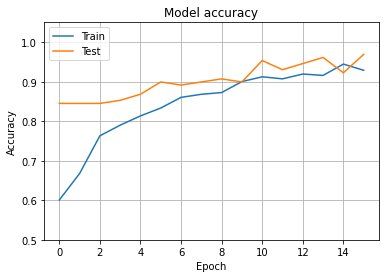

In [ ]:
plt.plot(result_list[study.best_trial.number].history["accuracy"])
plt.plot(result_list[study.best_trial.number].history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(0.5, 1.05)
plt.grid()
plt.show()

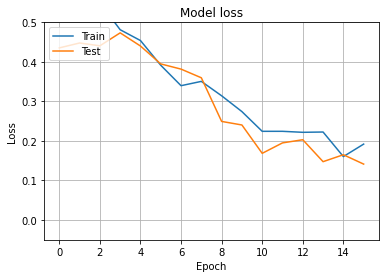

In [ ]:
plt.plot(result_list[study.best_trial.number].history["loss"])
plt.plot(result_list[study.best_trial.number].history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(-0.05, 0.5)
plt.grid()
plt.show()

In [ ]:
model_list[study.best_trial.number].save("kaibara.h5")